# Import Libraries

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

from matplotlib import pyplot
from dateutil import parser
import datetime

import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Import Data

In [2]:
train_df = pd.read_csv('./train.csv', parse_dates=['Date'])
train_df.drop(['ID', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'], inplace=True, axis=1)

# Create 2 new dataframes

In [3]:
train_df.columns

Index(['Province_State', 'Date', 'Confirmed', 'Deaths'], dtype='object')

In [22]:
confirmed_df = train_df[['Province_State', 'Date', 'Confirmed']]
deaths_df = train_df[['Province_State', 'Date', 'Deaths']]

In [5]:
state_names = train_df.Province_State.unique()
state_names

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

# Confirmed Dataset Modeling

### Make plots for each state

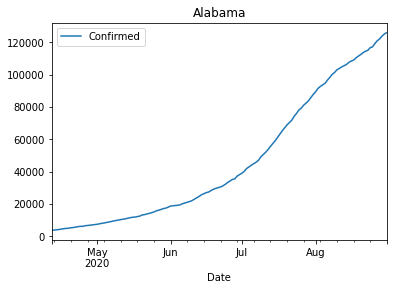

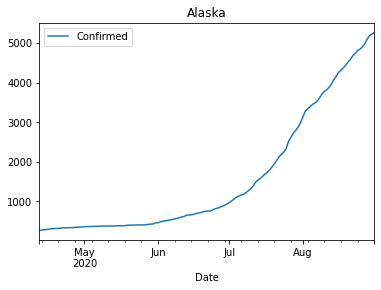

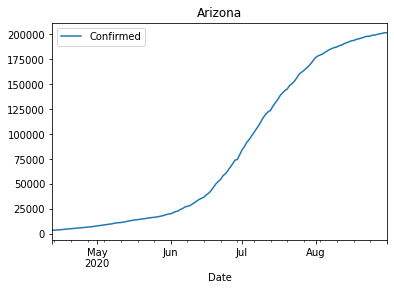

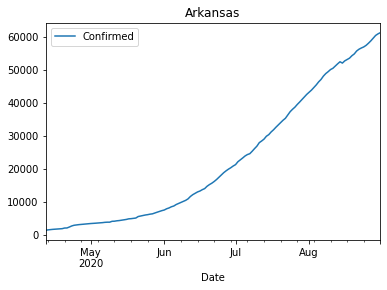

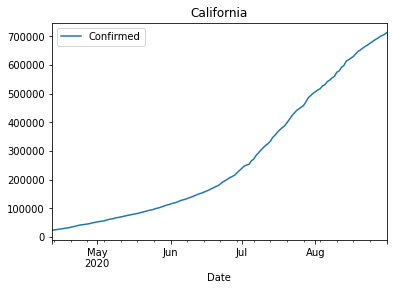

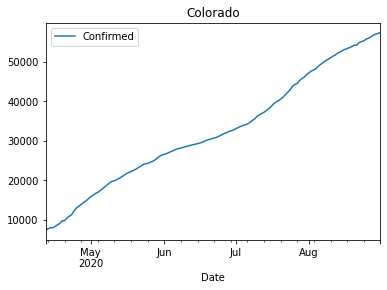

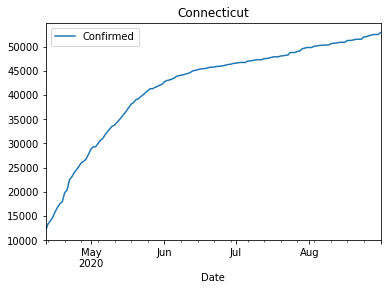

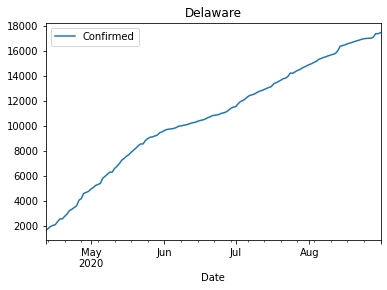

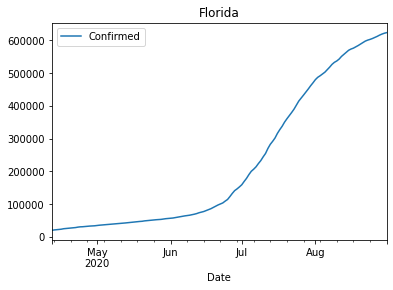

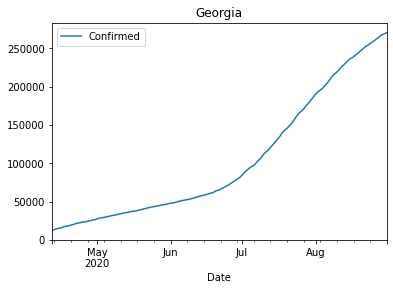

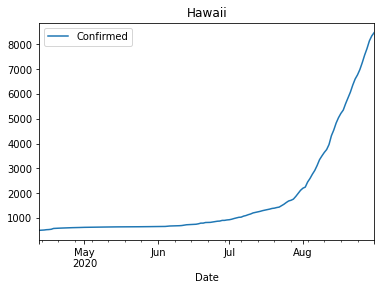

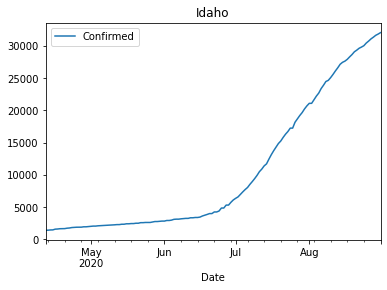

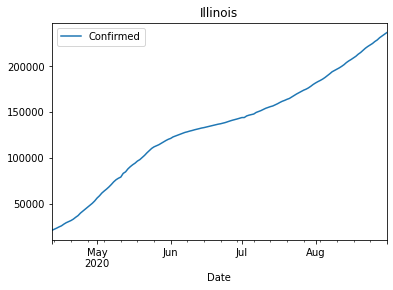

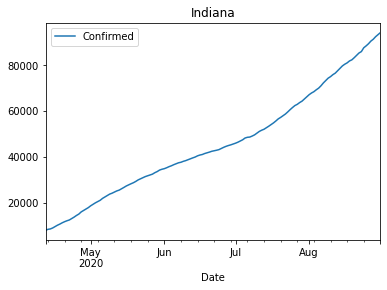

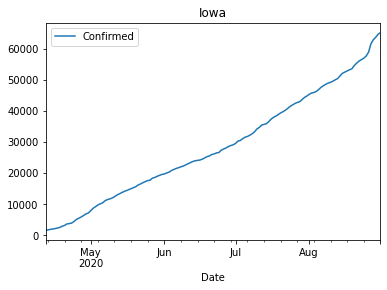

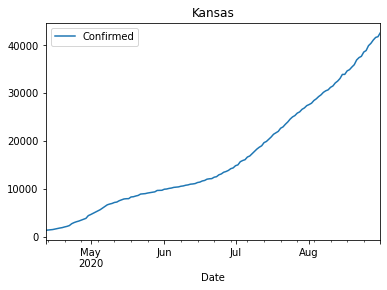

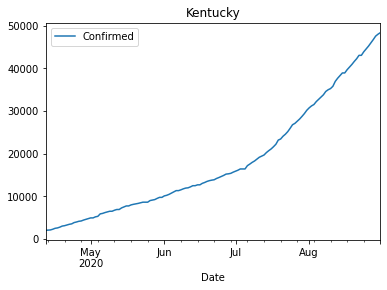

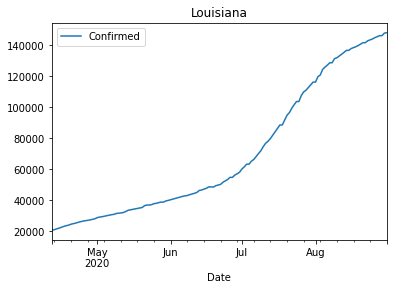

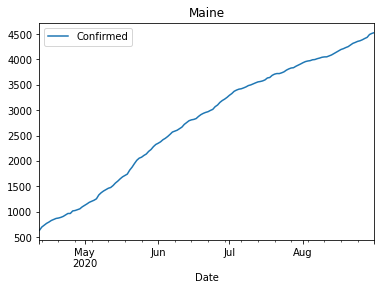

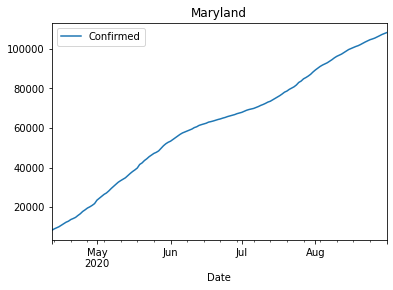

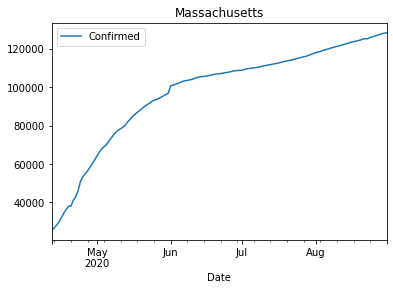

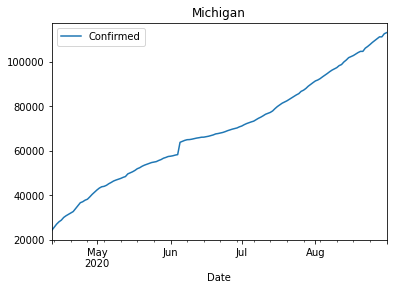

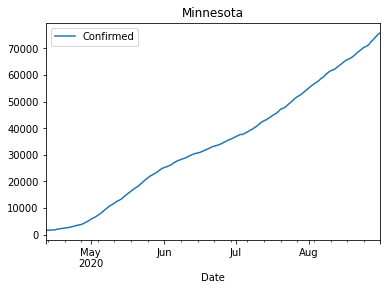

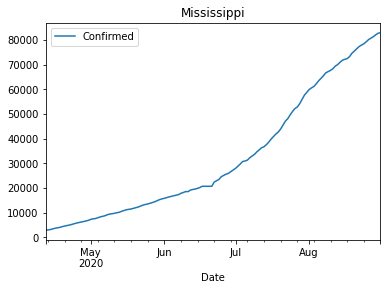

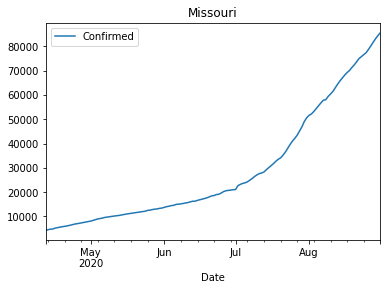

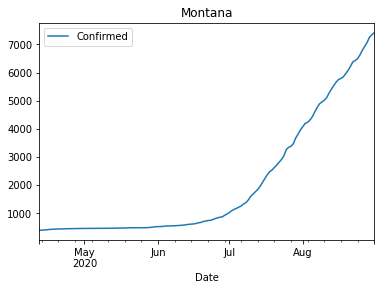

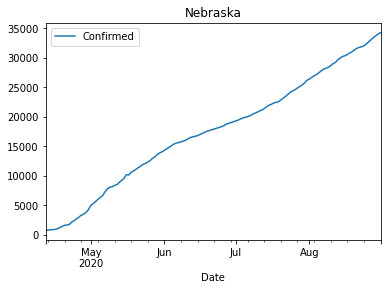

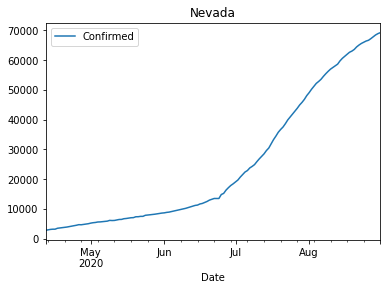

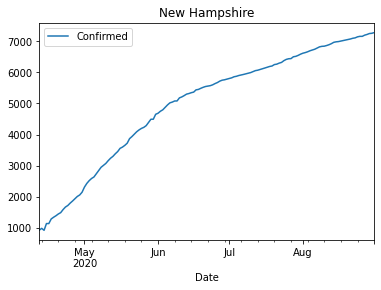

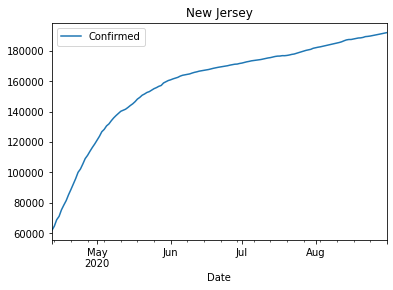

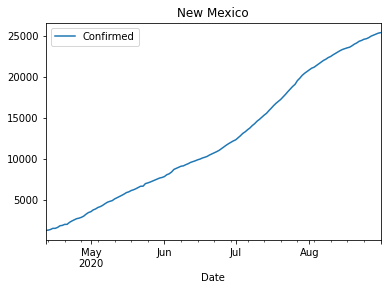

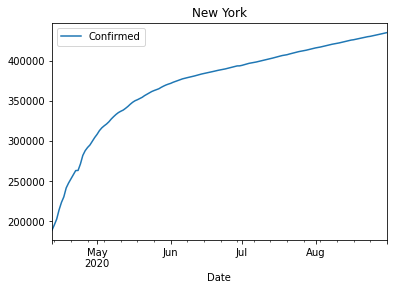

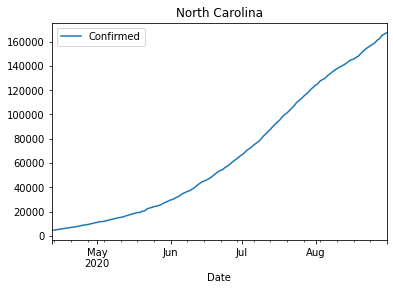

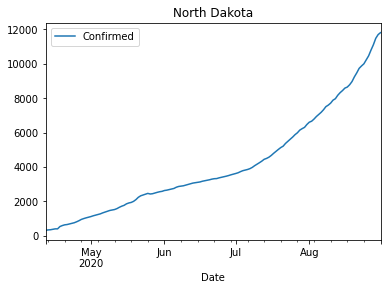

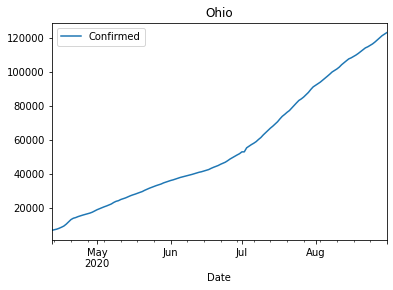

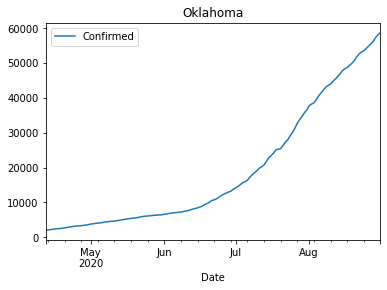

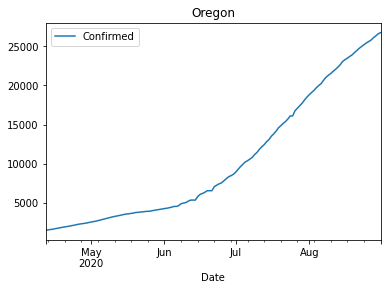

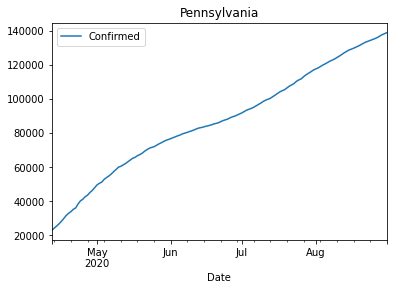

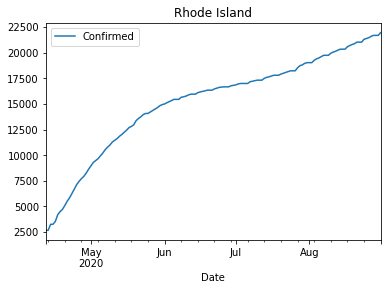

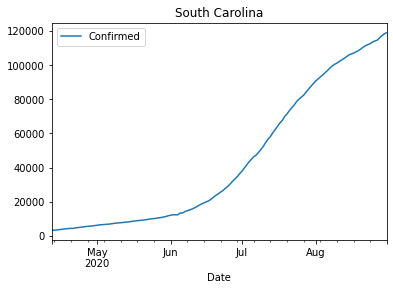

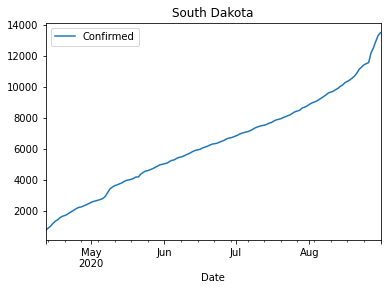

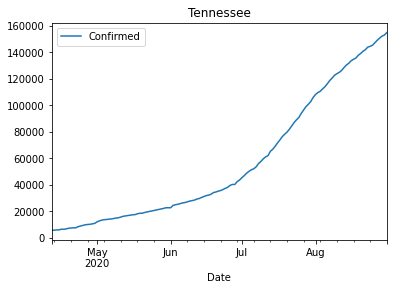

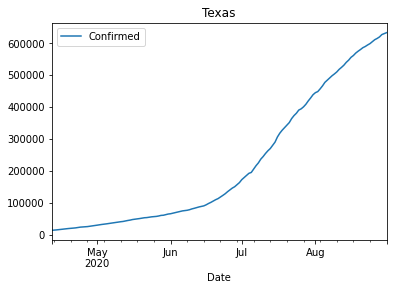

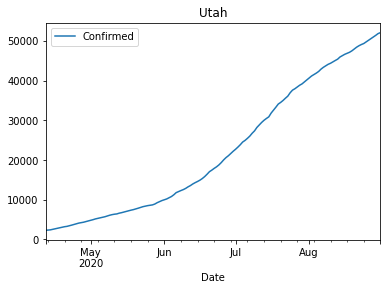

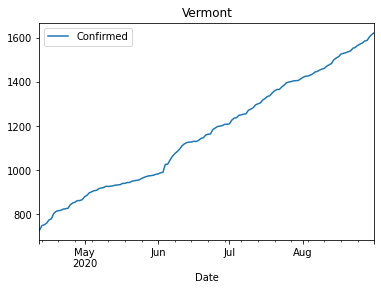

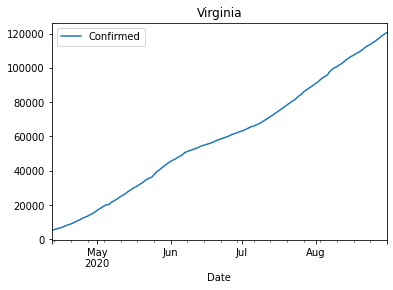

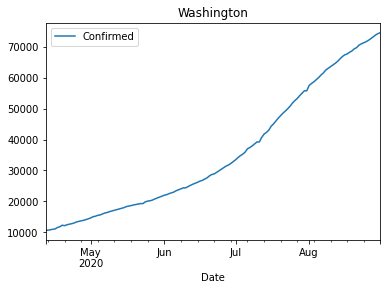

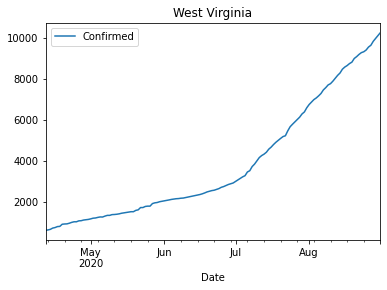

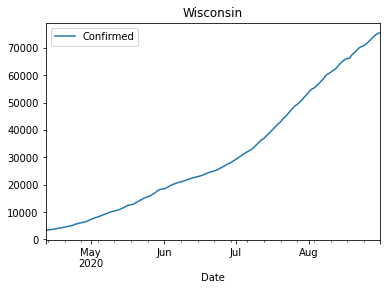

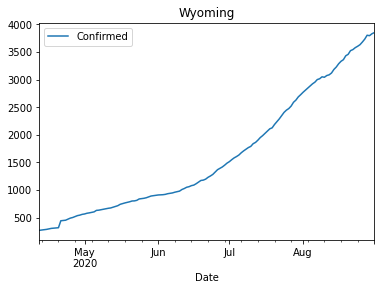

In [6]:
for state in state_names:
    state_df = confirmed_df[confirmed_df.Province_State == state][['Date', 'Confirmed']]
    state_df.plot('Date','Confirmed', title=state)
    pyplot.show()

We can see that the confirmed dataset for each state has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

### Create Autocorrelation Plots

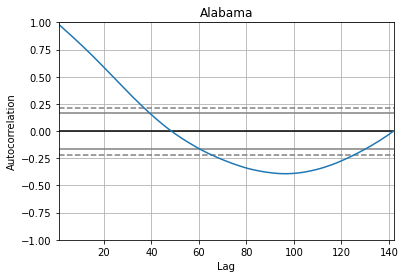

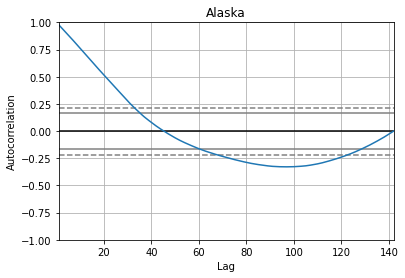

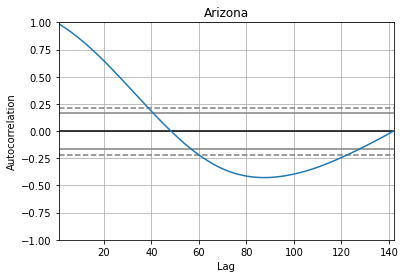

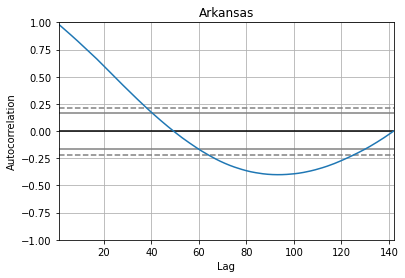

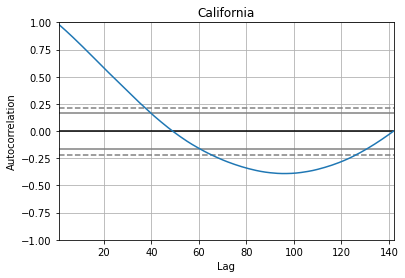

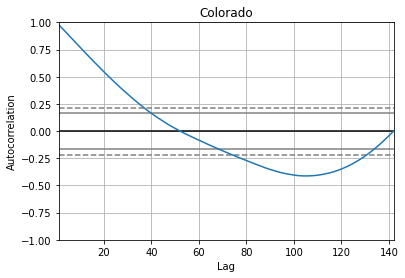

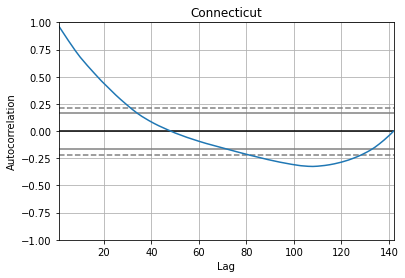

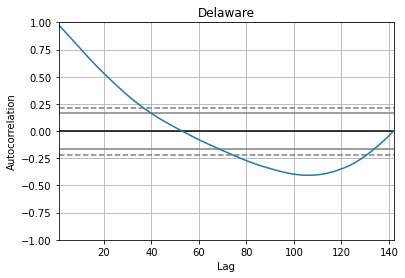

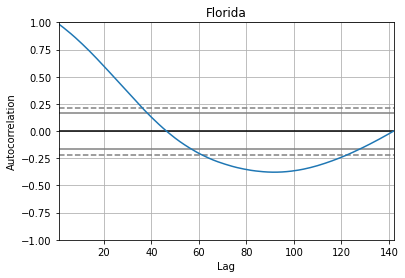

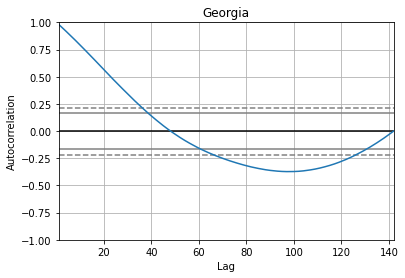

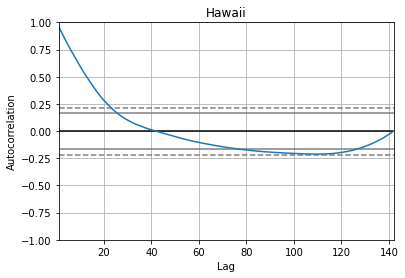

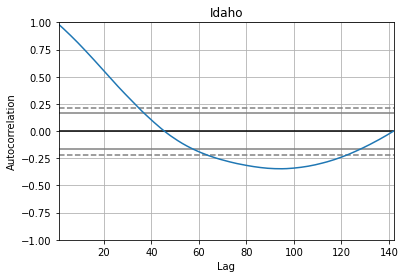

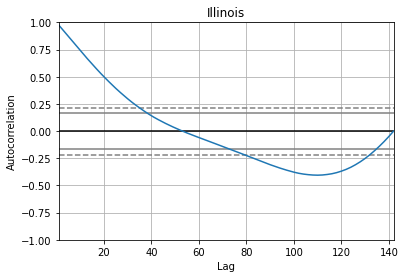

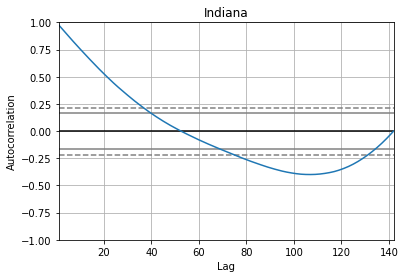

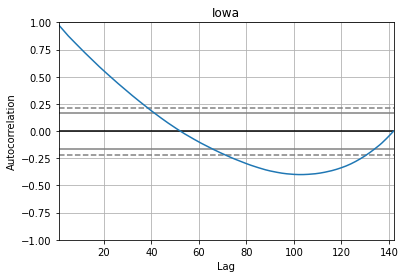

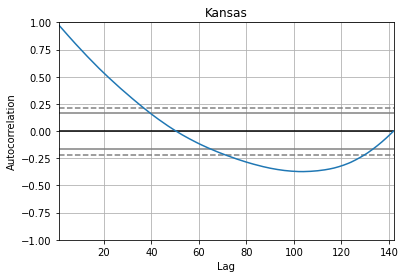

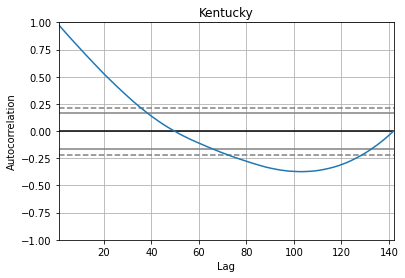

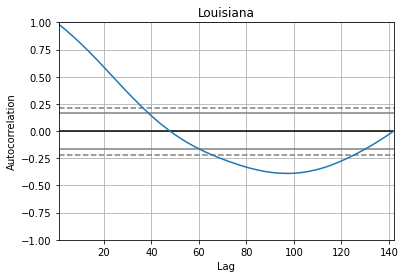

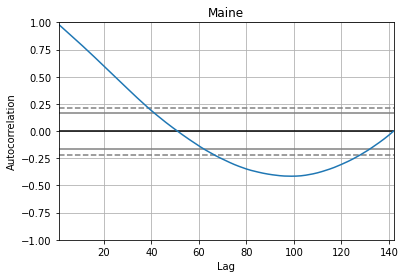

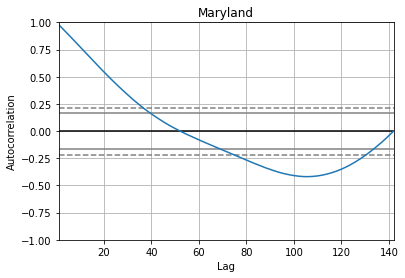

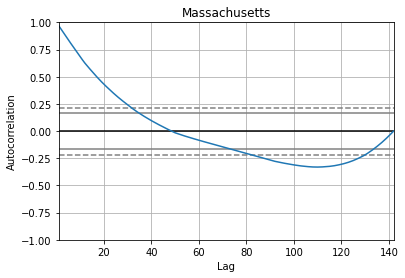

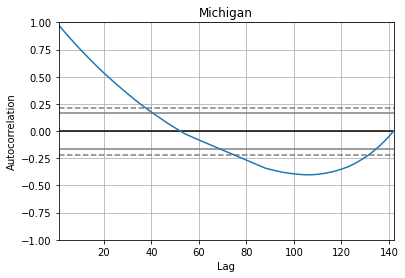

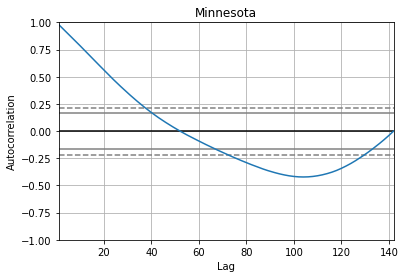

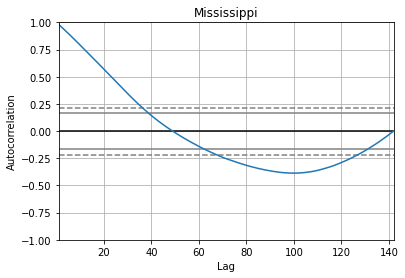

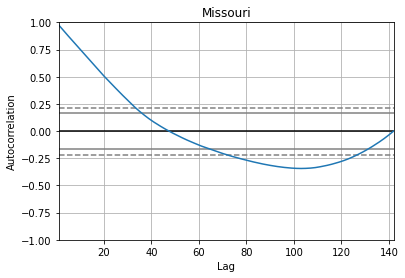

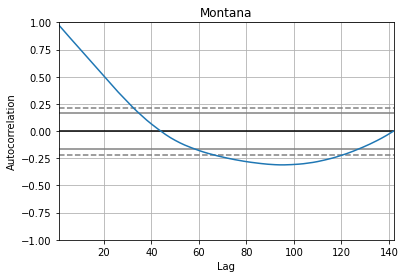

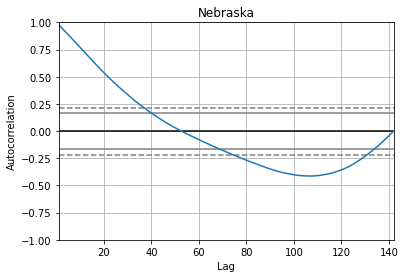

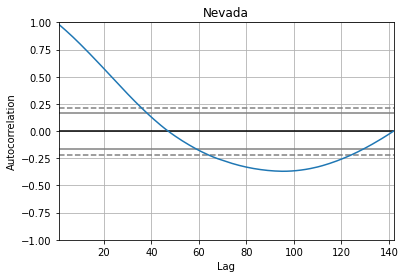

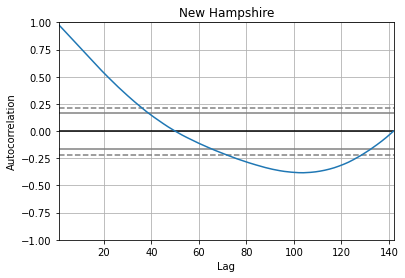

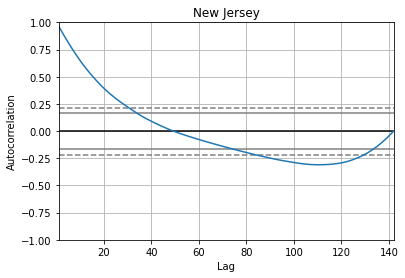

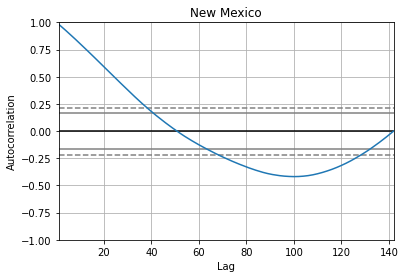

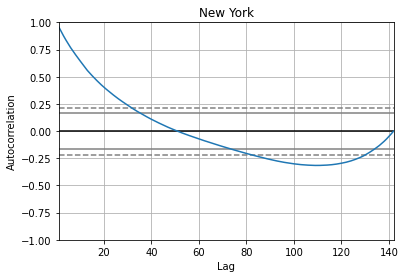

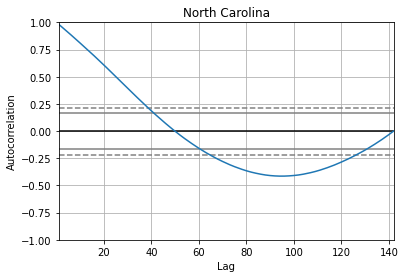

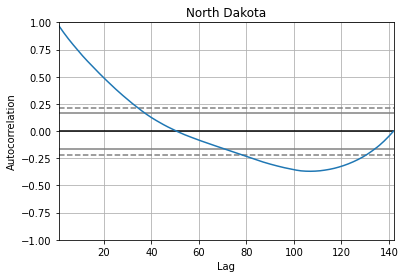

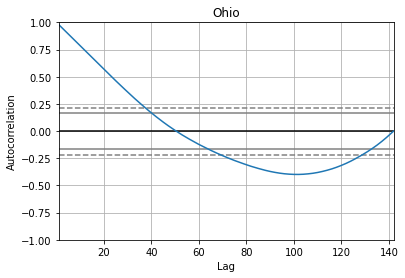

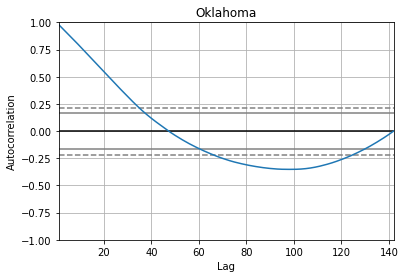

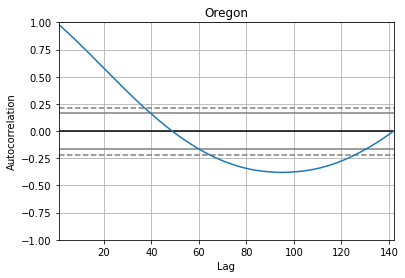

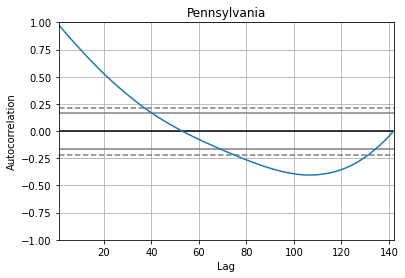

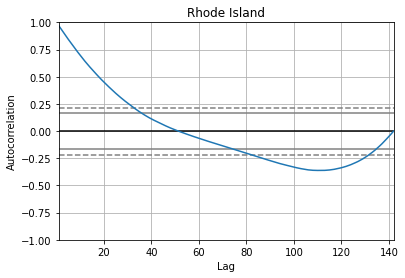

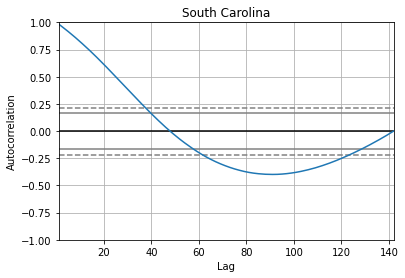

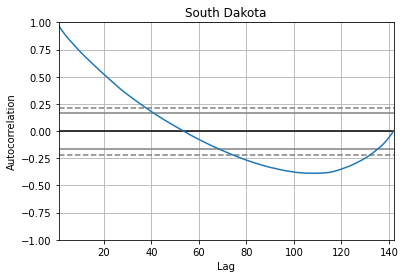

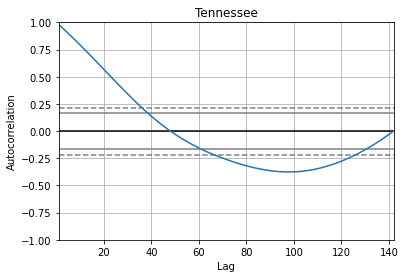

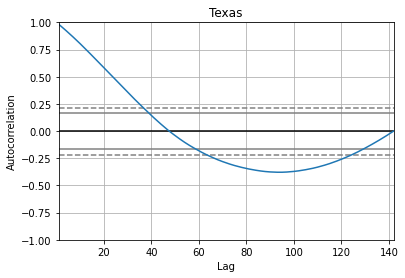

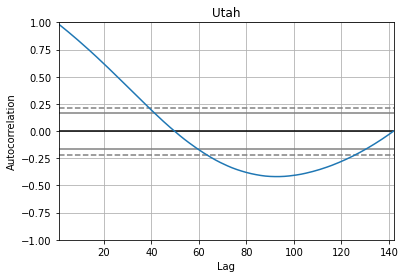

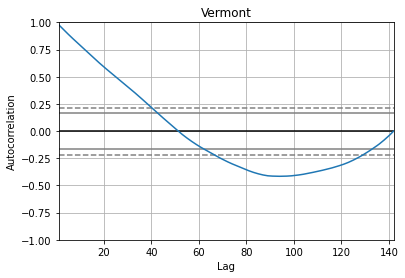

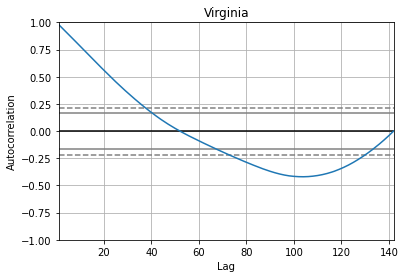

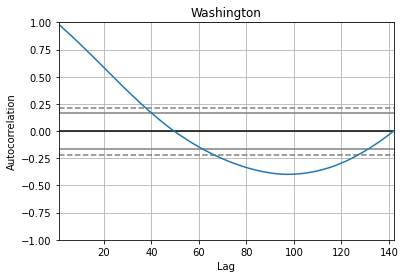

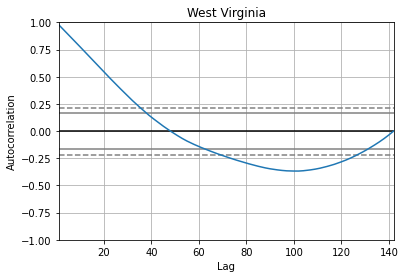

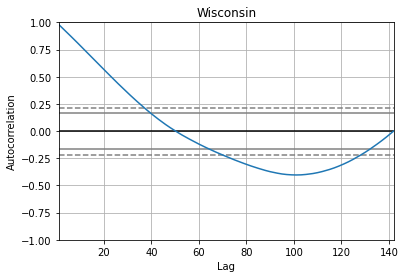

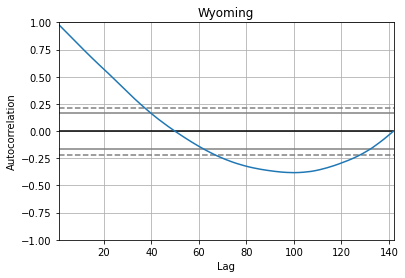

In [7]:
for state in state_names:
    state_df = confirmed_df[confirmed_df.Province_State == state][['Date', 'Confirmed']]
    autocorrelation_plot(state_df['Confirmed'])
    pyplot.title(state)
    pyplot.show()

It can be seen that for a majority of states, there is a positive correlation till the first 45-50 lags, but is most significant for the first 33-35 lags. This is fairly consistent across all of the states.

### Create Autocorrelation and Partial Autocorrelation Plots

From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

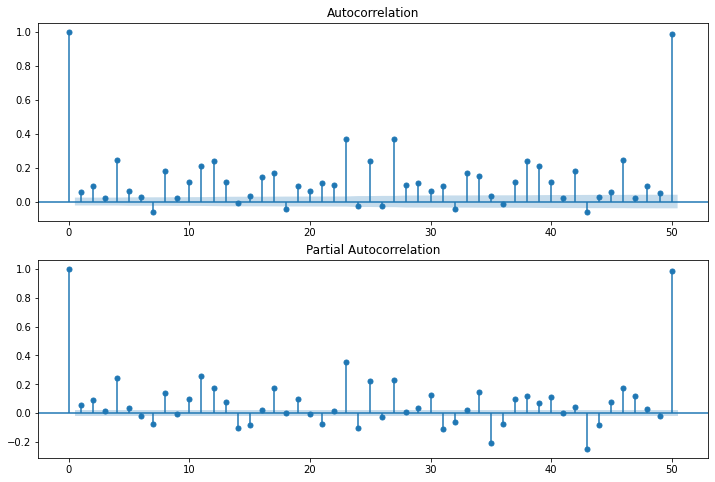

In [8]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(confirmed_df.Confirmed, lags=50, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(confirmed_df.Confirmed, lags=50, ax=ax2)# , lags=40

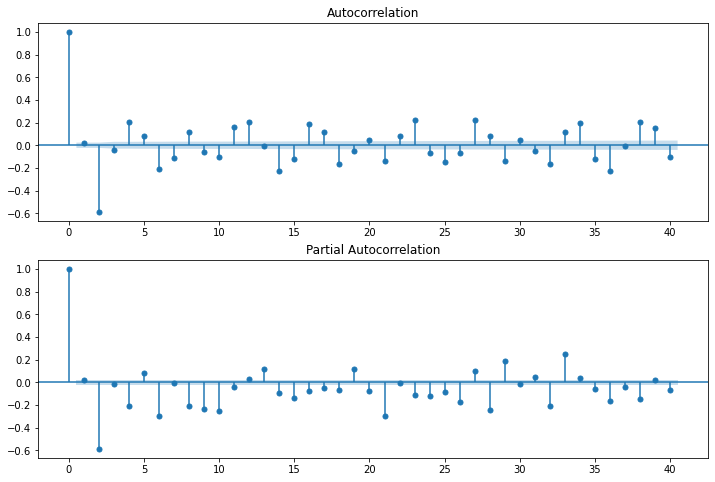

In [9]:
first_diff = confirmed_df.Confirmed - confirmed_df.Confirmed.shift(2)
first_diff = first_diff.dropna(inplace = False)

fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

### Fit Model

#### Train Validation Split

Training Data is from April to August 15th, Validation is August 15th - August 30th

In [10]:
confirmed_train = confirmed_df[confirmed_df.Date < '2020-08-15']
confirmed_test = confirmed_df[confirmed_df.Date >= '2020-08-15']

In [16]:
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_ARIMA_model(train_dataframe, test_dataframe, state, arima_order=(35,1,0)):
    '''
        Ideal inputs:
            train_dataframe: confirmed_train
            test_dataframe: confirmed_test
            state: state_name
            arima_order: use default
        Returns:
            - dataframe with predictions for September
            - MAPE on validation data
    '''
    print("Running ARIMA for {}".format(state))
    # Split into state specific train and evaluation
    train = train_dataframe[train_dataframe.Province_State == state].reset_index(drop=True)
    test  = test_dataframe[test_dataframe.Province_State == state].reset_index(drop=True)
    # Get Data
    data = train.Confirmed
    history = [x for x in data]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.Confirmed[t]
        #history.append(obs)
        history.append(yhat)
        print('Date: %s, predicted=%f, expected=%f' % (test.Date[t], yhat, obs))
    error = mean_absolute_percentage_error(test.Confirmed, predictions)
    print('Validation MAPE: %.3f' % error)
    # Plot
    ground_truth, = pyplot.plot(test.Confirmed, label='ground truth')
    prediction_,  = pyplot.plot(predictions, color='red', label='predictions')
    pyplot.legend(handles=[ground_truth, prediction_])
    pyplot.title(state)
    pyplot.ylabel('Confirmed')
    pyplot.xlabel('Day in August')
    pyplot.show()
    # predict for september
    history = [x for x in data]
    for val in list(test.Confirmed):
        history.append(val)
    base = parser.parse('2020-09-01')
    september = [base + datetime.timedelta(days=x) for x in range(26)]
    predictions = list()
    for t in range(len(september)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
        print('Date: %s, predicted=%f' % (september[t], yhat))
    print()
    df_data = {
        'Province_State': [state]*len(predictions),
        'Date': september,
        'Confirmed': predictions
    }
    september_results = pd.DataFrame(df_data)
    return september_results, error

Running ARIMA for Alabama
Date: 2020-08-15 00:00:00, predicted=107460.653508, expected=107580.000000
Date: 2020-08-16 00:00:00, predicted=108795.065590, expected=108433.000000
Date: 2020-08-17 00:00:00, predicted=109933.715934, expected=109004.000000
Date: 2020-08-18 00:00:00, predicted=110584.203646, expected=110361.000000
Date: 2020-08-19 00:00:00, predicted=110626.990779, expected=111478.000000
Date: 2020-08-20 00:00:00, predicted=111439.766549, expected=112449.000000
Date: 2020-08-21 00:00:00, predicted=111962.673912, expected=113632.000000
Date: 2020-08-22 00:00:00, predicted=112826.000385, expected=114532.000000
Date: 2020-08-23 00:00:00, predicted=113683.361053, expected=115060.000000
Date: 2020-08-24 00:00:00, predicted=114608.719204, expected=116710.000000
Date: 2020-08-25 00:00:00, predicted=115120.532240, expected=117242.000000
Date: 2020-08-26 00:00:00, predicted=115604.656889, expected=119254.000000
Date: 2020-08-27 00:00:00, predicted=115822.707030, expected=121023.000000

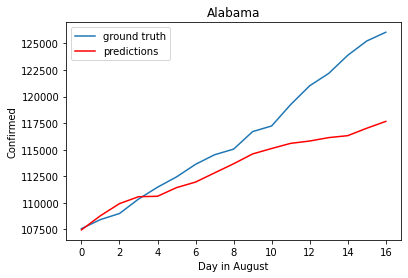

Date: 2020-09-01 00:00:00, predicted=127413.853159
Date: 2020-09-02 00:00:00, predicted=128418.564290
Date: 2020-09-03 00:00:00, predicted=130035.474153
Date: 2020-09-04 00:00:00, predicted=131690.817119
Date: 2020-09-05 00:00:00, predicted=133407.670707
Date: 2020-09-06 00:00:00, predicted=134758.094389
Date: 2020-09-07 00:00:00, predicted=136372.802813
Date: 2020-09-08 00:00:00, predicted=137362.804807
Date: 2020-09-09 00:00:00, predicted=138994.219540
Date: 2020-09-10 00:00:00, predicted=140128.638056
Date: 2020-09-11 00:00:00, predicted=141650.024761
Date: 2020-09-12 00:00:00, predicted=143463.260138
Date: 2020-09-13 00:00:00, predicted=145040.852304
Date: 2020-09-14 00:00:00, predicted=146742.117600
Date: 2020-09-15 00:00:00, predicted=148342.754840
Date: 2020-09-16 00:00:00, predicted=149630.096987
Date: 2020-09-17 00:00:00, predicted=151219.579764
Date: 2020-09-18 00:00:00, predicted=152397.243658
Date: 2020-09-19 00:00:00, predicted=153790.544734
Date: 2020-09-20 00:00:00, pred

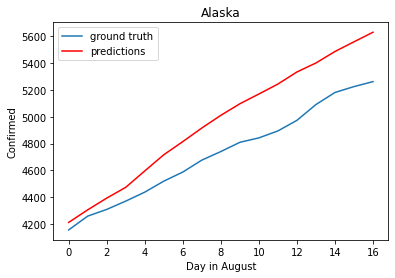

Date: 2020-09-01 00:00:00, predicted=5321.012704
Date: 2020-09-02 00:00:00, predicted=5405.703179
Date: 2020-09-03 00:00:00, predicted=5507.077159
Date: 2020-09-04 00:00:00, predicted=5565.247725
Date: 2020-09-05 00:00:00, predicted=5593.073491
Date: 2020-09-06 00:00:00, predicted=5600.586701
Date: 2020-09-07 00:00:00, predicted=5631.944494
Date: 2020-09-08 00:00:00, predicted=5673.557164
Date: 2020-09-09 00:00:00, predicted=5720.987784
Date: 2020-09-10 00:00:00, predicted=5787.241900
Date: 2020-09-11 00:00:00, predicted=5833.042941
Date: 2020-09-12 00:00:00, predicted=5865.446546
Date: 2020-09-13 00:00:00, predicted=5874.508581
Date: 2020-09-14 00:00:00, predicted=5916.337297
Date: 2020-09-15 00:00:00, predicted=5974.173544
Date: 2020-09-16 00:00:00, predicted=6046.680391
Date: 2020-09-17 00:00:00, predicted=6106.302353
Date: 2020-09-18 00:00:00, predicted=6136.426909
Date: 2020-09-19 00:00:00, predicted=6147.399948
Date: 2020-09-20 00:00:00, predicted=6170.592311
Date: 2020-09-21 00:

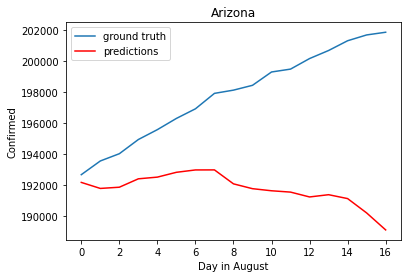

Date: 2020-09-01 00:00:00, predicted=202304.483038
Date: 2020-09-02 00:00:00, predicted=202556.468731
Date: 2020-09-03 00:00:00, predicted=203122.530137
Date: 2020-09-04 00:00:00, predicted=203660.500450
Date: 2020-09-05 00:00:00, predicted=204424.001704
Date: 2020-09-06 00:00:00, predicted=204566.127249
Date: 2020-09-07 00:00:00, predicted=204694.433900
Date: 2020-09-08 00:00:00, predicted=205218.308511
Date: 2020-09-09 00:00:00, predicted=205503.070127
Date: 2020-09-10 00:00:00, predicted=206103.605577
Date: 2020-09-11 00:00:00, predicted=206640.204705
Date: 2020-09-12 00:00:00, predicted=207155.730395
Date: 2020-09-13 00:00:00, predicted=207343.195907
Date: 2020-09-14 00:00:00, predicted=207615.011285
Date: 2020-09-15 00:00:00, predicted=207975.530696
Date: 2020-09-16 00:00:00, predicted=208267.385066
Date: 2020-09-17 00:00:00, predicted=208772.475490
Date: 2020-09-18 00:00:00, predicted=209197.486968
Date: 2020-09-19 00:00:00, predicted=209776.481576
Date: 2020-09-20 00:00:00, pred

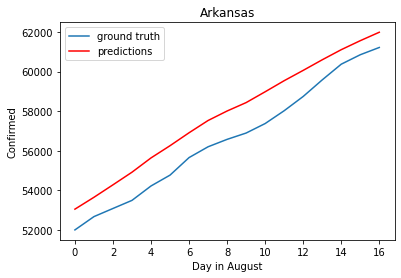

Date: 2020-09-01 00:00:00, predicted=61895.320446
Date: 2020-09-02 00:00:00, predicted=62537.412378
Date: 2020-09-03 00:00:00, predicted=63270.693089
Date: 2020-09-04 00:00:00, predicted=63824.273176
Date: 2020-09-05 00:00:00, predicted=64434.523946
Date: 2020-09-06 00:00:00, predicted=65055.538210
Date: 2020-09-07 00:00:00, predicted=65603.733246
Date: 2020-09-08 00:00:00, predicted=66001.968555
Date: 2020-09-09 00:00:00, predicted=66442.711183
Date: 2020-09-10 00:00:00, predicted=67177.986959
Date: 2020-09-11 00:00:00, predicted=67641.809913
Date: 2020-09-12 00:00:00, predicted=68213.520626
Date: 2020-09-13 00:00:00, predicted=68407.045812
Date: 2020-09-14 00:00:00, predicted=68874.380249
Date: 2020-09-15 00:00:00, predicted=69434.751477
Date: 2020-09-16 00:00:00, predicted=69974.022123
Date: 2020-09-17 00:00:00, predicted=70511.311096
Date: 2020-09-18 00:00:00, predicted=70944.539443
Date: 2020-09-19 00:00:00, predicted=71697.174259
Date: 2020-09-20 00:00:00, predicted=71938.759203


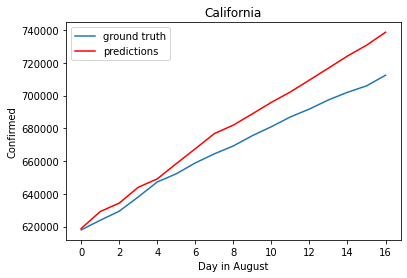

Date: 2020-09-01 00:00:00, predicted=716226.452507
Date: 2020-09-02 00:00:00, predicted=722638.370710
Date: 2020-09-03 00:00:00, predicted=727984.575543
Date: 2020-09-04 00:00:00, predicted=732656.386225
Date: 2020-09-05 00:00:00, predicted=737143.136450
Date: 2020-09-06 00:00:00, predicted=740811.171549
Date: 2020-09-07 00:00:00, predicted=745394.117897
Date: 2020-09-08 00:00:00, predicted=748098.073910
Date: 2020-09-09 00:00:00, predicted=752518.904640
Date: 2020-09-10 00:00:00, predicted=756244.797951
Date: 2020-09-11 00:00:00, predicted=760939.332780
Date: 2020-09-12 00:00:00, predicted=763135.439135
Date: 2020-09-13 00:00:00, predicted=766520.350029
Date: 2020-09-14 00:00:00, predicted=769567.027011
Date: 2020-09-15 00:00:00, predicted=774826.243732
Date: 2020-09-16 00:00:00, predicted=776779.163990
Date: 2020-09-17 00:00:00, predicted=781522.835008
Date: 2020-09-18 00:00:00, predicted=783730.028250
Date: 2020-09-19 00:00:00, predicted=787713.883015
Date: 2020-09-20 00:00:00, pred

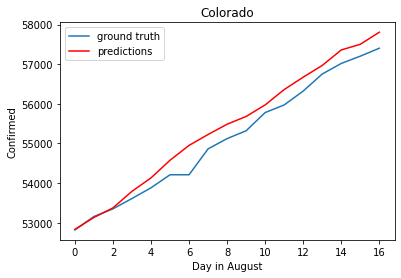

Date: 2020-09-01 00:00:00, predicted=57599.066674
Date: 2020-09-02 00:00:00, predicted=57734.425833
Date: 2020-09-03 00:00:00, predicted=58157.853707
Date: 2020-09-04 00:00:00, predicted=58351.851498
Date: 2020-09-05 00:00:00, predicted=58713.381488
Date: 2020-09-06 00:00:00, predicted=58975.751774
Date: 2020-09-07 00:00:00, predicted=59218.946032
Date: 2020-09-08 00:00:00, predicted=59456.015706
Date: 2020-09-09 00:00:00, predicted=59903.006144
Date: 2020-09-10 00:00:00, predicted=60178.215492
Date: 2020-09-11 00:00:00, predicted=60475.001832
Date: 2020-09-12 00:00:00, predicted=60837.651630
Date: 2020-09-13 00:00:00, predicted=61016.056249
Date: 2020-09-14 00:00:00, predicted=61286.196468
Date: 2020-09-15 00:00:00, predicted=61459.829884
Date: 2020-09-16 00:00:00, predicted=61779.090025
Date: 2020-09-17 00:00:00, predicted=62079.750179
Date: 2020-09-18 00:00:00, predicted=62334.721447
Date: 2020-09-19 00:00:00, predicted=62745.436370
Date: 2020-09-20 00:00:00, predicted=62948.826191


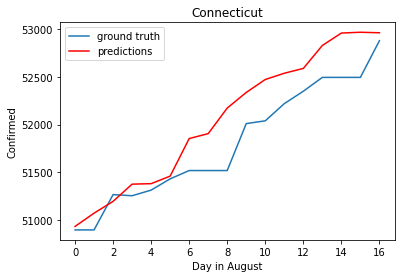

Date: 2020-09-01 00:00:00, predicted=52927.780557
Date: 2020-09-02 00:00:00, predicted=52941.203071
Date: 2020-09-03 00:00:00, predicted=53050.685998
Date: 2020-09-04 00:00:00, predicted=53308.561766
Date: 2020-09-05 00:00:00, predicted=53342.429986
Date: 2020-09-06 00:00:00, predicted=53305.061178
Date: 2020-09-07 00:00:00, predicted=53513.906311
Date: 2020-09-08 00:00:00, predicted=53670.006746
Date: 2020-09-09 00:00:00, predicted=53690.454589
Date: 2020-09-10 00:00:00, predicted=53929.628058
Date: 2020-09-11 00:00:00, predicted=54148.856545
Date: 2020-09-12 00:00:00, predicted=54178.378306
Date: 2020-09-13 00:00:00, predicted=54228.891929
Date: 2020-09-14 00:00:00, predicted=54438.825368
Date: 2020-09-15 00:00:00, predicted=54469.905486
Date: 2020-09-16 00:00:00, predicted=54486.884279
Date: 2020-09-17 00:00:00, predicted=54724.396044
Date: 2020-09-18 00:00:00, predicted=54982.033923
Date: 2020-09-19 00:00:00, predicted=55113.838549
Date: 2020-09-20 00:00:00, predicted=55189.624225


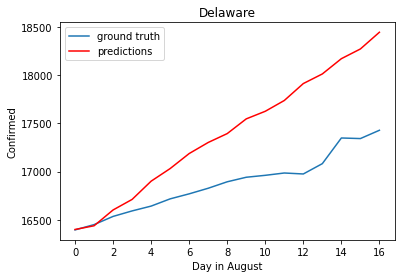

Date: 2020-09-01 00:00:00, predicted=17562.873836
Date: 2020-09-02 00:00:00, predicted=17673.547669
Date: 2020-09-03 00:00:00, predicted=17681.455253
Date: 2020-09-04 00:00:00, predicted=17751.745714
Date: 2020-09-05 00:00:00, predicted=17782.680109
Date: 2020-09-06 00:00:00, predicted=17819.315941
Date: 2020-09-07 00:00:00, predicted=17901.949882
Date: 2020-09-08 00:00:00, predicted=17986.187943
Date: 2020-09-09 00:00:00, predicted=18044.527575
Date: 2020-09-10 00:00:00, predicted=18114.505024
Date: 2020-09-11 00:00:00, predicted=18179.587641
Date: 2020-09-12 00:00:00, predicted=18214.313151
Date: 2020-09-13 00:00:00, predicted=18278.565256
Date: 2020-09-14 00:00:00, predicted=18271.429970
Date: 2020-09-15 00:00:00, predicted=18337.461187
Date: 2020-09-16 00:00:00, predicted=18483.244852
Date: 2020-09-17 00:00:00, predicted=18623.509168
Date: 2020-09-18 00:00:00, predicted=18654.790854
Date: 2020-09-19 00:00:00, predicted=18756.438379
Date: 2020-09-20 00:00:00, predicted=18806.919832


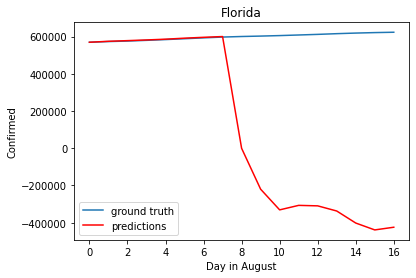

Date: 2020-09-01 00:00:00, predicted=624723.299760
Date: 2020-09-02 00:00:00, predicted=626645.736298
Date: 2020-09-03 00:00:00, predicted=628997.701273
Date: 2020-09-04 00:00:00, predicted=631428.398633
Date: 2020-09-05 00:00:00, predicted=633463.241259
Date: 2020-09-06 00:00:00, predicted=634820.312003
Date: 2020-09-07 00:00:00, predicted=636172.468673
Date: 2020-09-08 00:00:00, predicted=637868.213338
Date: 2020-09-09 00:00:00, predicted=639328.252991
Date: 2020-09-10 00:00:00, predicted=641260.784792
Date: 2020-09-11 00:00:00, predicted=643643.272809
Date: 2020-09-12 00:00:00, predicted=644962.035232
Date: 2020-09-13 00:00:00, predicted=645763.982971
Date: 2020-09-14 00:00:00, predicted=646932.266874
Date: 2020-09-15 00:00:00, predicted=647886.842764
Date: 2020-09-16 00:00:00, predicted=649079.601326
Date: 2020-09-17 00:00:00, predicted=650539.864079
Date: 2020-09-18 00:00:00, predicted=651958.219547
Date: 2020-09-19 00:00:00, predicted=652940.258204
Date: 2020-09-20 00:00:00, pred

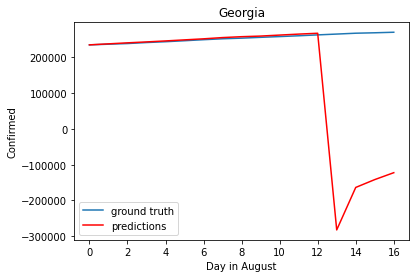

Date: 2020-09-01 00:00:00, predicted=272281.925307
Date: 2020-09-02 00:00:00, predicted=274077.154948
Date: 2020-09-03 00:00:00, predicted=275855.666796
Date: 2020-09-04 00:00:00, predicted=277864.003004
Date: 2020-09-05 00:00:00, predicted=279566.847738
Date: 2020-09-06 00:00:00, predicted=281102.655763
Date: 2020-09-07 00:00:00, predicted=282198.208130
Date: 2020-09-08 00:00:00, predicted=283982.030075
Date: 2020-09-09 00:00:00, predicted=285841.899654
Date: 2020-09-10 00:00:00, predicted=287343.486384
Date: 2020-09-11 00:00:00, predicted=289197.957967
Date: 2020-09-12 00:00:00, predicted=290697.864977
Date: 2020-09-13 00:00:00, predicted=291717.783574
Date: 2020-09-14 00:00:00, predicted=292660.299132
Date: 2020-09-15 00:00:00, predicted=294005.575403
Date: 2020-09-16 00:00:00, predicted=295313.544013
Date: 2020-09-17 00:00:00, predicted=296606.189355
Date: 2020-09-18 00:00:00, predicted=298113.980616
Date: 2020-09-19 00:00:00, predicted=299405.318554
Date: 2020-09-20 00:00:00, pred

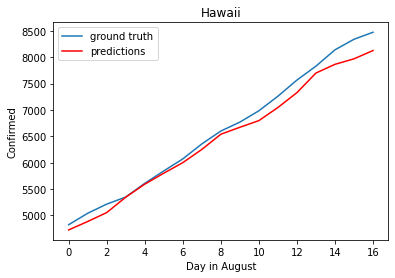

Date: 2020-09-01 00:00:00, predicted=8703.680672
Date: 2020-09-02 00:00:00, predicted=8896.955140
Date: 2020-09-03 00:00:00, predicted=9205.276222
Date: 2020-09-04 00:00:00, predicted=9613.724278
Date: 2020-09-05 00:00:00, predicted=9957.722730
Date: 2020-09-06 00:00:00, predicted=10185.611930
Date: 2020-09-07 00:00:00, predicted=10353.347071
Date: 2020-09-08 00:00:00, predicted=10598.108803
Date: 2020-09-09 00:00:00, predicted=10855.760449
Date: 2020-09-10 00:00:00, predicted=11102.828881
Date: 2020-09-11 00:00:00, predicted=11462.594584
Date: 2020-09-12 00:00:00, predicted=11730.300753
Date: 2020-09-13 00:00:00, predicted=12008.481098
Date: 2020-09-14 00:00:00, predicted=12262.959134
Date: 2020-09-15 00:00:00, predicted=12501.101981
Date: 2020-09-16 00:00:00, predicted=12730.651537
Date: 2020-09-17 00:00:00, predicted=13068.022429
Date: 2020-09-18 00:00:00, predicted=13439.087998
Date: 2020-09-19 00:00:00, predicted=13744.910541
Date: 2020-09-20 00:00:00, predicted=13975.914548
Date:

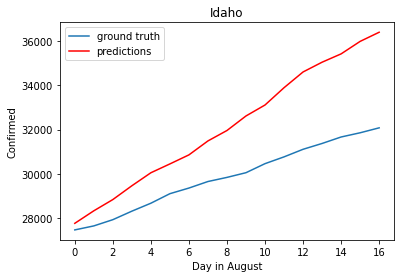

Date: 2020-09-01 00:00:00, predicted=32459.845388
Date: 2020-09-02 00:00:00, predicted=32925.280910
Date: 2020-09-03 00:00:00, predicted=33177.510303
Date: 2020-09-04 00:00:00, predicted=33574.930522
Date: 2020-09-05 00:00:00, predicted=33722.461927
Date: 2020-09-06 00:00:00, predicted=33932.748607
Date: 2020-09-07 00:00:00, predicted=34067.287216
Date: 2020-09-08 00:00:00, predicted=34383.635532
Date: 2020-09-09 00:00:00, predicted=34820.260136
Date: 2020-09-10 00:00:00, predicted=35129.043401
Date: 2020-09-11 00:00:00, predicted=35386.974668
Date: 2020-09-12 00:00:00, predicted=35605.699447
Date: 2020-09-13 00:00:00, predicted=35760.322038
Date: 2020-09-14 00:00:00, predicted=35932.030859
Date: 2020-09-15 00:00:00, predicted=36187.485512
Date: 2020-09-16 00:00:00, predicted=36520.542736
Date: 2020-09-17 00:00:00, predicted=36853.495566
Date: 2020-09-18 00:00:00, predicted=37045.167869
Date: 2020-09-19 00:00:00, predicted=37233.157057
Date: 2020-09-20 00:00:00, predicted=37428.849086


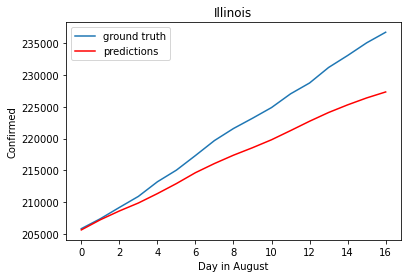

Date: 2020-09-01 00:00:00, predicted=238400.254645
Date: 2020-09-02 00:00:00, predicted=240059.685769
Date: 2020-09-03 00:00:00, predicted=241980.207110
Date: 2020-09-04 00:00:00, predicted=243889.331144
Date: 2020-09-05 00:00:00, predicted=245575.178285
Date: 2020-09-06 00:00:00, predicted=247134.562388
Date: 2020-09-07 00:00:00, predicted=248924.751707
Date: 2020-09-08 00:00:00, predicted=250476.952519
Date: 2020-09-09 00:00:00, predicted=252285.427760
Date: 2020-09-10 00:00:00, predicted=253934.005805
Date: 2020-09-11 00:00:00, predicted=255641.203345
Date: 2020-09-12 00:00:00, predicted=257217.752501
Date: 2020-09-13 00:00:00, predicted=258760.205629
Date: 2020-09-14 00:00:00, predicted=259988.434373
Date: 2020-09-15 00:00:00, predicted=261308.672816
Date: 2020-09-16 00:00:00, predicted=262743.964074
Date: 2020-09-17 00:00:00, predicted=264039.569475
Date: 2020-09-18 00:00:00, predicted=265685.139481
Date: 2020-09-19 00:00:00, predicted=266936.216792
Date: 2020-09-20 00:00:00, pred

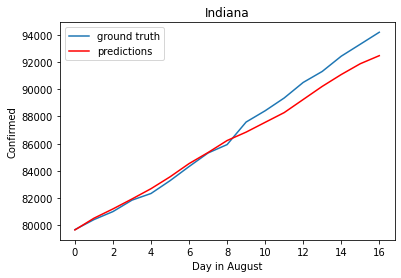

Date: 2020-09-01 00:00:00, predicted=94931.553574
Date: 2020-09-02 00:00:00, predicted=95878.732472
Date: 2020-09-03 00:00:00, predicted=96865.215444
Date: 2020-09-04 00:00:00, predicted=97702.832425
Date: 2020-09-05 00:00:00, predicted=98561.896744
Date: 2020-09-06 00:00:00, predicted=99121.649678
Date: 2020-09-07 00:00:00, predicted=100049.791780
Date: 2020-09-08 00:00:00, predicted=100791.136961
Date: 2020-09-09 00:00:00, predicted=101709.348880
Date: 2020-09-10 00:00:00, predicted=102769.758171
Date: 2020-09-11 00:00:00, predicted=103705.846891
Date: 2020-09-12 00:00:00, predicted=104655.612280
Date: 2020-09-13 00:00:00, predicted=105627.830930
Date: 2020-09-14 00:00:00, predicted=106468.925165
Date: 2020-09-15 00:00:00, predicted=107057.338623
Date: 2020-09-16 00:00:00, predicted=108105.128329
Date: 2020-09-17 00:00:00, predicted=108906.123003
Date: 2020-09-18 00:00:00, predicted=109847.403719
Date: 2020-09-19 00:00:00, predicted=110683.686136
Date: 2020-09-20 00:00:00, predicted=

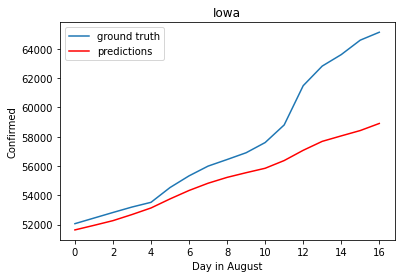

Date: 2020-09-01 00:00:00, predicted=66315.247498
Date: 2020-09-02 00:00:00, predicted=68268.409212
Date: 2020-09-03 00:00:00, predicted=70086.472408
Date: 2020-09-04 00:00:00, predicted=71451.726270
Date: 2020-09-05 00:00:00, predicted=72513.244250
Date: 2020-09-06 00:00:00, predicted=73689.250704
Date: 2020-09-07 00:00:00, predicted=74644.016961
Date: 2020-09-08 00:00:00, predicted=76337.976967
Date: 2020-09-09 00:00:00, predicted=78458.774834
Date: 2020-09-10 00:00:00, predicted=79907.179452
Date: 2020-09-11 00:00:00, predicted=81020.293867
Date: 2020-09-12 00:00:00, predicted=82030.884796
Date: 2020-09-13 00:00:00, predicted=83043.923812
Date: 2020-09-14 00:00:00, predicted=84179.227700
Date: 2020-09-15 00:00:00, predicted=85780.320976
Date: 2020-09-16 00:00:00, predicted=87476.655507
Date: 2020-09-17 00:00:00, predicted=88899.171473
Date: 2020-09-18 00:00:00, predicted=90097.973863
Date: 2020-09-19 00:00:00, predicted=90793.618126
Date: 2020-09-20 00:00:00, predicted=91377.646484


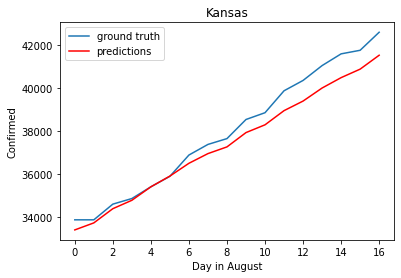

Date: 2020-09-01 00:00:00, predicted=43112.196606
Date: 2020-09-02 00:00:00, predicted=43926.675670
Date: 2020-09-03 00:00:00, predicted=44446.002460
Date: 2020-09-04 00:00:00, predicted=45132.674817
Date: 2020-09-05 00:00:00, predicted=45665.909555
Date: 2020-09-06 00:00:00, predicted=45955.745786
Date: 2020-09-07 00:00:00, predicted=46714.121458
Date: 2020-09-08 00:00:00, predicted=47095.033114
Date: 2020-09-09 00:00:00, predicted=47698.510657
Date: 2020-09-10 00:00:00, predicted=48148.083677
Date: 2020-09-11 00:00:00, predicted=48729.564997
Date: 2020-09-12 00:00:00, predicted=49363.699095
Date: 2020-09-13 00:00:00, predicted=49627.413274
Date: 2020-09-14 00:00:00, predicted=50256.456227
Date: 2020-09-15 00:00:00, predicted=50485.194643
Date: 2020-09-16 00:00:00, predicted=51154.262018
Date: 2020-09-17 00:00:00, predicted=51513.753881
Date: 2020-09-18 00:00:00, predicted=52011.747753
Date: 2020-09-19 00:00:00, predicted=52682.190824
Date: 2020-09-20 00:00:00, predicted=52678.558838


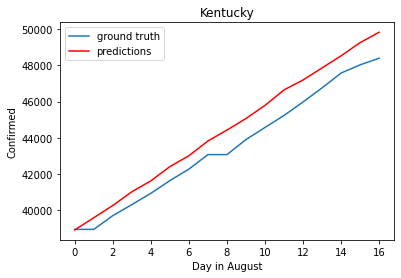

Date: 2020-09-01 00:00:00, predicted=49107.259538
Date: 2020-09-02 00:00:00, predicted=49972.711181
Date: 2020-09-03 00:00:00, predicted=50666.377757
Date: 2020-09-04 00:00:00, predicted=51273.140538
Date: 2020-09-05 00:00:00, predicted=52047.799709
Date: 2020-09-06 00:00:00, predicted=52600.975042
Date: 2020-09-07 00:00:00, predicted=53143.982388
Date: 2020-09-08 00:00:00, predicted=53769.759348
Date: 2020-09-09 00:00:00, predicted=54464.961505
Date: 2020-09-10 00:00:00, predicted=55189.293985
Date: 2020-09-11 00:00:00, predicted=56063.923756
Date: 2020-09-12 00:00:00, predicted=56633.030029
Date: 2020-09-13 00:00:00, predicted=57114.435830
Date: 2020-09-14 00:00:00, predicted=57592.591518
Date: 2020-09-15 00:00:00, predicted=58411.643490
Date: 2020-09-16 00:00:00, predicted=59103.330687
Date: 2020-09-17 00:00:00, predicted=59658.977869
Date: 2020-09-18 00:00:00, predicted=60589.463970
Date: 2020-09-19 00:00:00, predicted=61095.356250
Date: 2020-09-20 00:00:00, predicted=61700.996575


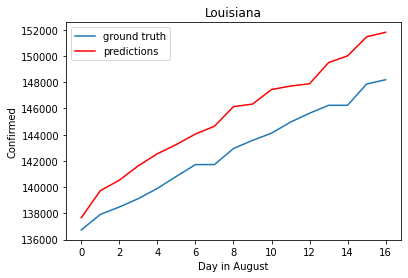

Date: 2020-09-01 00:00:00, predicted=148570.725296
Date: 2020-09-02 00:00:00, predicted=149246.105519
Date: 2020-09-03 00:00:00, predicted=149973.802221
Date: 2020-09-04 00:00:00, predicted=150251.189099
Date: 2020-09-05 00:00:00, predicted=150808.253375
Date: 2020-09-06 00:00:00, predicted=151897.419313
Date: 2020-09-07 00:00:00, predicted=152550.469126
Date: 2020-09-08 00:00:00, predicted=153491.633322
Date: 2020-09-09 00:00:00, predicted=153915.792278
Date: 2020-09-10 00:00:00, predicted=154742.648799
Date: 2020-09-11 00:00:00, predicted=155071.248994
Date: 2020-09-12 00:00:00, predicted=155737.501990
Date: 2020-09-13 00:00:00, predicted=156603.538341
Date: 2020-09-14 00:00:00, predicted=157156.052338
Date: 2020-09-15 00:00:00, predicted=157965.356178
Date: 2020-09-16 00:00:00, predicted=158428.403585
Date: 2020-09-17 00:00:00, predicted=159242.711751
Date: 2020-09-18 00:00:00, predicted=159708.324317
Date: 2020-09-19 00:00:00, predicted=160303.628802
Date: 2020-09-20 00:00:00, pred

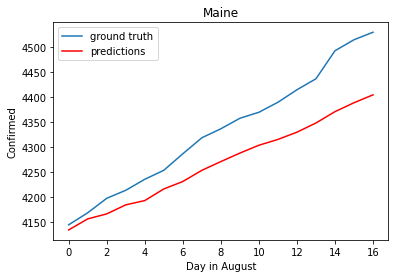

Date: 2020-09-01 00:00:00, predicted=4543.328716
Date: 2020-09-02 00:00:00, predicted=4564.690490
Date: 2020-09-03 00:00:00, predicted=4585.014520
Date: 2020-09-04 00:00:00, predicted=4611.833309
Date: 2020-09-05 00:00:00, predicted=4646.645114
Date: 2020-09-06 00:00:00, predicted=4670.930680
Date: 2020-09-07 00:00:00, predicted=4684.582842
Date: 2020-09-08 00:00:00, predicted=4701.562967
Date: 2020-09-09 00:00:00, predicted=4718.290700
Date: 2020-09-10 00:00:00, predicted=4740.534498
Date: 2020-09-11 00:00:00, predicted=4767.989677
Date: 2020-09-12 00:00:00, predicted=4794.345314
Date: 2020-09-13 00:00:00, predicted=4817.243777
Date: 2020-09-14 00:00:00, predicted=4833.318999
Date: 2020-09-15 00:00:00, predicted=4845.753541
Date: 2020-09-16 00:00:00, predicted=4855.539629
Date: 2020-09-17 00:00:00, predicted=4874.619152
Date: 2020-09-18 00:00:00, predicted=4898.064050
Date: 2020-09-19 00:00:00, predicted=4923.042828
Date: 2020-09-20 00:00:00, predicted=4941.711505
Date: 2020-09-21 00:

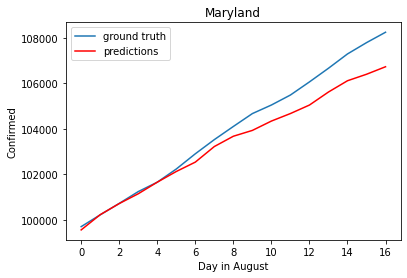

Date: 2020-09-01 00:00:00, predicted=108625.807576
Date: 2020-09-02 00:00:00, predicted=109082.601882
Date: 2020-09-03 00:00:00, predicted=109570.121758
Date: 2020-09-04 00:00:00, predicted=110226.722084
Date: 2020-09-05 00:00:00, predicted=110887.103805
Date: 2020-09-06 00:00:00, predicted=111456.757757
Date: 2020-09-07 00:00:00, predicted=111941.971872
Date: 2020-09-08 00:00:00, predicted=112380.436133
Date: 2020-09-09 00:00:00, predicted=112795.771795
Date: 2020-09-10 00:00:00, predicted=113360.282595
Date: 2020-09-11 00:00:00, predicted=114024.577188
Date: 2020-09-12 00:00:00, predicted=114611.127454
Date: 2020-09-13 00:00:00, predicted=115177.555681
Date: 2020-09-14 00:00:00, predicted=115650.946464
Date: 2020-09-15 00:00:00, predicted=116124.504500
Date: 2020-09-16 00:00:00, predicted=116660.227713
Date: 2020-09-17 00:00:00, predicted=117260.168546
Date: 2020-09-18 00:00:00, predicted=117923.502472
Date: 2020-09-19 00:00:00, predicted=118580.809122
Date: 2020-09-20 00:00:00, pred

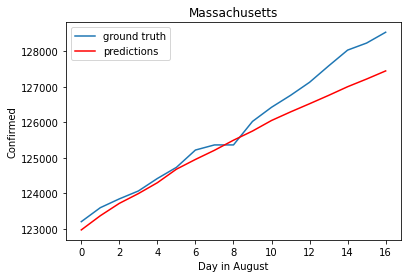

Date: 2020-09-01 00:00:00, predicted=128708.372385
Date: 2020-09-02 00:00:00, predicted=129081.356109
Date: 2020-09-03 00:00:00, predicted=129280.164473
Date: 2020-09-04 00:00:00, predicted=129425.625743
Date: 2020-09-05 00:00:00, predicted=129807.897324
Date: 2020-09-06 00:00:00, predicted=130103.451813
Date: 2020-09-07 00:00:00, predicted=130351.531200
Date: 2020-09-08 00:00:00, predicted=130573.972610
Date: 2020-09-09 00:00:00, predicted=130944.475000
Date: 2020-09-10 00:00:00, predicted=131239.725303
Date: 2020-09-11 00:00:00, predicted=131476.177133
Date: 2020-09-12 00:00:00, predicted=131694.921136
Date: 2020-09-13 00:00:00, predicted=131875.736058
Date: 2020-09-14 00:00:00, predicted=132143.234603
Date: 2020-09-15 00:00:00, predicted=132343.449438
Date: 2020-09-16 00:00:00, predicted=132546.729505
Date: 2020-09-17 00:00:00, predicted=132752.479771
Date: 2020-09-18 00:00:00, predicted=132961.852443
Date: 2020-09-19 00:00:00, predicted=133175.529056
Date: 2020-09-20 00:00:00, pred

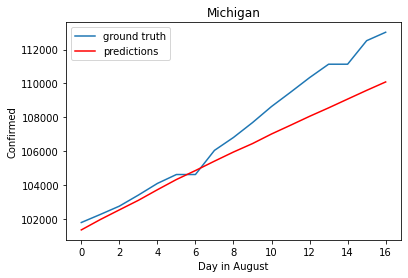

Date: 2020-09-01 00:00:00, predicted=113662.298577
Date: 2020-09-02 00:00:00, predicted=114341.037333
Date: 2020-09-03 00:00:00, predicted=114914.859034
Date: 2020-09-04 00:00:00, predicted=115541.275632
Date: 2020-09-05 00:00:00, predicted=116072.845864
Date: 2020-09-06 00:00:00, predicted=116628.246654
Date: 2020-09-07 00:00:00, predicted=117174.739462
Date: 2020-09-08 00:00:00, predicted=117741.898660
Date: 2020-09-09 00:00:00, predicted=118296.903496
Date: 2020-09-10 00:00:00, predicted=118873.888400
Date: 2020-09-11 00:00:00, predicted=119496.542947
Date: 2020-09-12 00:00:00, predicted=120037.558252
Date: 2020-09-13 00:00:00, predicted=120622.607583
Date: 2020-09-14 00:00:00, predicted=121131.660673
Date: 2020-09-15 00:00:00, predicted=121700.370707
Date: 2020-09-16 00:00:00, predicted=122208.127553
Date: 2020-09-17 00:00:00, predicted=122730.650977
Date: 2020-09-18 00:00:00, predicted=123247.525971
Date: 2020-09-19 00:00:00, predicted=123769.022722
Date: 2020-09-20 00:00:00, pred

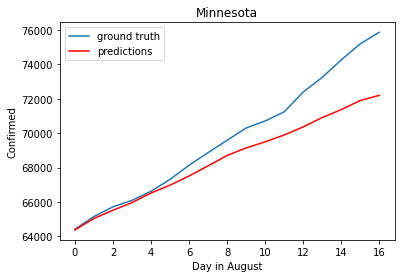

Date: 2020-09-01 00:00:00, predicted=76499.967595
Date: 2020-09-02 00:00:00, predicted=77295.350290
Date: 2020-09-03 00:00:00, predicted=78308.496698
Date: 2020-09-04 00:00:00, predicted=79286.457864
Date: 2020-09-05 00:00:00, predicted=80279.335453
Date: 2020-09-06 00:00:00, predicted=81174.866617
Date: 2020-09-07 00:00:00, predicted=82118.844217
Date: 2020-09-08 00:00:00, predicted=82790.941824
Date: 2020-09-09 00:00:00, predicted=83671.732557
Date: 2020-09-10 00:00:00, predicted=84812.161778
Date: 2020-09-11 00:00:00, predicted=85860.430968
Date: 2020-09-12 00:00:00, predicted=86872.226738
Date: 2020-09-13 00:00:00, predicted=87922.433807
Date: 2020-09-14 00:00:00, predicted=88797.127741
Date: 2020-09-15 00:00:00, predicted=89620.085743
Date: 2020-09-16 00:00:00, predicted=90526.289630
Date: 2020-09-17 00:00:00, predicted=91638.351571
Date: 2020-09-18 00:00:00, predicted=92714.102233
Date: 2020-09-19 00:00:00, predicted=93660.828969
Date: 2020-09-20 00:00:00, predicted=94681.601965


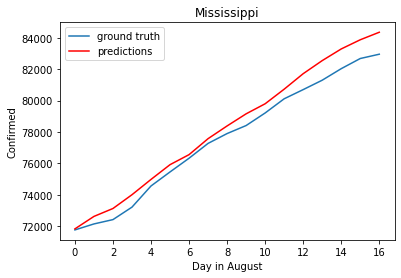

Date: 2020-09-01 00:00:00, predicted=83440.877037
Date: 2020-09-02 00:00:00, predicted=84222.151136
Date: 2020-09-03 00:00:00, predicted=84773.080522
Date: 2020-09-04 00:00:00, predicted=85140.560949
Date: 2020-09-05 00:00:00, predicted=85604.919448
Date: 2020-09-06 00:00:00, predicted=85956.241405
Date: 2020-09-07 00:00:00, predicted=86080.515540
Date: 2020-09-08 00:00:00, predicted=86367.303210
Date: 2020-09-09 00:00:00, predicted=86862.006416
Date: 2020-09-10 00:00:00, predicted=87163.234025
Date: 2020-09-11 00:00:00, predicted=87378.309359
Date: 2020-09-12 00:00:00, predicted=87707.018585
Date: 2020-09-13 00:00:00, predicted=88025.225297
Date: 2020-09-14 00:00:00, predicted=88137.714571
Date: 2020-09-15 00:00:00, predicted=88337.303665
Date: 2020-09-16 00:00:00, predicted=88775.894882
Date: 2020-09-17 00:00:00, predicted=89210.966065
Date: 2020-09-18 00:00:00, predicted=89422.262226
Date: 2020-09-19 00:00:00, predicted=89709.191637
Date: 2020-09-20 00:00:00, predicted=89990.938612


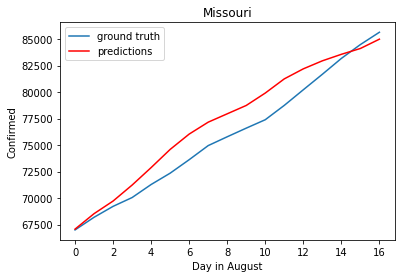

Date: 2020-09-01 00:00:00, predicted=86871.904563
Date: 2020-09-02 00:00:00, predicted=88253.993420
Date: 2020-09-03 00:00:00, predicted=89665.912638
Date: 2020-09-04 00:00:00, predicted=91295.916414
Date: 2020-09-05 00:00:00, predicted=92612.477160
Date: 2020-09-06 00:00:00, predicted=93836.379211
Date: 2020-09-07 00:00:00, predicted=94854.212355
Date: 2020-09-08 00:00:00, predicted=95805.266329
Date: 2020-09-09 00:00:00, predicted=96764.660297
Date: 2020-09-10 00:00:00, predicted=97931.326476
Date: 2020-09-11 00:00:00, predicted=99329.041944
Date: 2020-09-12 00:00:00, predicted=100732.526035
Date: 2020-09-13 00:00:00, predicted=101849.495128
Date: 2020-09-14 00:00:00, predicted=102843.467724
Date: 2020-09-15 00:00:00, predicted=103673.576212
Date: 2020-09-16 00:00:00, predicted=104759.195912
Date: 2020-09-17 00:00:00, predicted=106055.507995
Date: 2020-09-18 00:00:00, predicted=107504.018890
Date: 2020-09-19 00:00:00, predicted=108889.527884
Date: 2020-09-20 00:00:00, predicted=10995

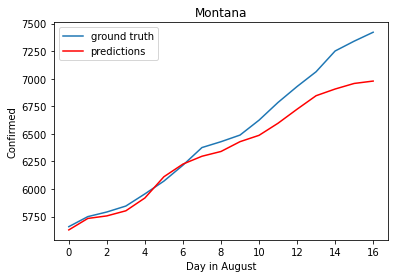

Date: 2020-09-01 00:00:00, predicted=7517.062995
Date: 2020-09-02 00:00:00, predicted=7664.568825
Date: 2020-09-03 00:00:00, predicted=7803.423733
Date: 2020-09-04 00:00:00, predicted=7967.017748
Date: 2020-09-05 00:00:00, predicted=8106.101434
Date: 2020-09-06 00:00:00, predicted=8243.073469
Date: 2020-09-07 00:00:00, predicted=8331.910772
Date: 2020-09-08 00:00:00, predicted=8476.256277
Date: 2020-09-09 00:00:00, predicted=8637.156714
Date: 2020-09-10 00:00:00, predicted=8805.116931
Date: 2020-09-11 00:00:00, predicted=8954.427843
Date: 2020-09-12 00:00:00, predicted=9138.256748
Date: 2020-09-13 00:00:00, predicted=9269.232581
Date: 2020-09-14 00:00:00, predicted=9370.268142
Date: 2020-09-15 00:00:00, predicted=9476.052411
Date: 2020-09-16 00:00:00, predicted=9640.176177
Date: 2020-09-17 00:00:00, predicted=9781.899902
Date: 2020-09-18 00:00:00, predicted=9939.034951
Date: 2020-09-19 00:00:00, predicted=10094.623966
Date: 2020-09-20 00:00:00, predicted=10222.768216
Date: 2020-09-21 0

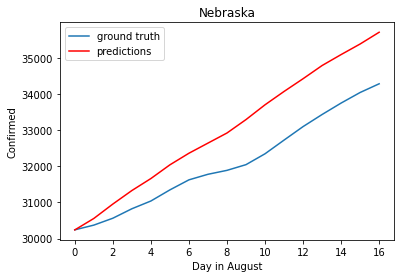

Date: 2020-09-01 00:00:00, predicted=34651.715211
Date: 2020-09-02 00:00:00, predicted=35064.694310
Date: 2020-09-03 00:00:00, predicted=35465.163409
Date: 2020-09-04 00:00:00, predicted=35746.555200
Date: 2020-09-05 00:00:00, predicted=36022.518769
Date: 2020-09-06 00:00:00, predicted=36311.747797
Date: 2020-09-07 00:00:00, predicted=36646.134593
Date: 2020-09-08 00:00:00, predicted=36974.245042
Date: 2020-09-09 00:00:00, predicted=37402.491928
Date: 2020-09-10 00:00:00, predicted=37809.041759
Date: 2020-09-11 00:00:00, predicted=38078.273133
Date: 2020-09-12 00:00:00, predicted=38288.502405
Date: 2020-09-13 00:00:00, predicted=38555.346860
Date: 2020-09-14 00:00:00, predicted=38872.832108
Date: 2020-09-15 00:00:00, predicted=39161.939623
Date: 2020-09-16 00:00:00, predicted=39483.437063
Date: 2020-09-17 00:00:00, predicted=39807.739258
Date: 2020-09-18 00:00:00, predicted=40070.756361
Date: 2020-09-19 00:00:00, predicted=40215.787113
Date: 2020-09-20 00:00:00, predicted=40419.361897


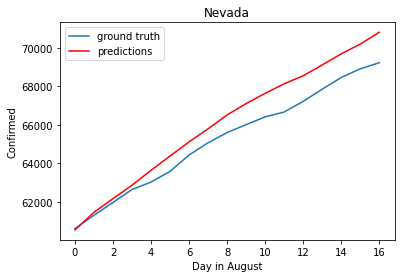

Date: 2020-09-01 00:00:00, predicted=69609.507081
Date: 2020-09-02 00:00:00, predicted=69947.945354
Date: 2020-09-03 00:00:00, predicted=70278.540255
Date: 2020-09-04 00:00:00, predicted=70852.794502
Date: 2020-09-05 00:00:00, predicted=71414.076058
Date: 2020-09-06 00:00:00, predicted=71688.817391
Date: 2020-09-07 00:00:00, predicted=71841.677657
Date: 2020-09-08 00:00:00, predicted=72088.160111
Date: 2020-09-09 00:00:00, predicted=72252.768825
Date: 2020-09-10 00:00:00, predicted=72416.958599
Date: 2020-09-11 00:00:00, predicted=72815.947791
Date: 2020-09-12 00:00:00, predicted=73129.620440
Date: 2020-09-13 00:00:00, predicted=73296.527723
Date: 2020-09-14 00:00:00, predicted=73401.760262
Date: 2020-09-15 00:00:00, predicted=73572.797245
Date: 2020-09-16 00:00:00, predicted=73695.117717
Date: 2020-09-17 00:00:00, predicted=73849.230444
Date: 2020-09-18 00:00:00, predicted=74142.658199
Date: 2020-09-19 00:00:00, predicted=74403.523846
Date: 2020-09-20 00:00:00, predicted=74527.686092


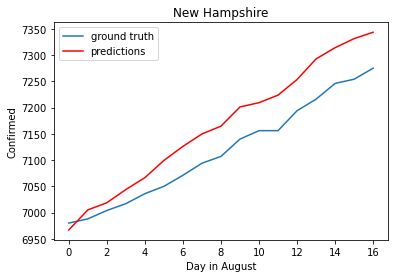

Date: 2020-09-01 00:00:00, predicted=7288.874151
Date: 2020-09-02 00:00:00, predicted=7306.957300
Date: 2020-09-03 00:00:00, predicted=7337.637005
Date: 2020-09-04 00:00:00, predicted=7364.595640
Date: 2020-09-05 00:00:00, predicted=7379.675626
Date: 2020-09-06 00:00:00, predicted=7392.950127
Date: 2020-09-07 00:00:00, predicted=7410.096444
Date: 2020-09-08 00:00:00, predicted=7428.459714
Date: 2020-09-09 00:00:00, predicted=7450.880499
Date: 2020-09-10 00:00:00, predicted=7475.813788
Date: 2020-09-11 00:00:00, predicted=7504.223952
Date: 2020-09-12 00:00:00, predicted=7527.934965
Date: 2020-09-13 00:00:00, predicted=7554.125798
Date: 2020-09-14 00:00:00, predicted=7564.662227
Date: 2020-09-15 00:00:00, predicted=7578.547896
Date: 2020-09-16 00:00:00, predicted=7596.234435
Date: 2020-09-17 00:00:00, predicted=7628.209142
Date: 2020-09-18 00:00:00, predicted=7652.710118
Date: 2020-09-19 00:00:00, predicted=7675.914073
Date: 2020-09-20 00:00:00, predicted=7692.505196
Date: 2020-09-21 00:

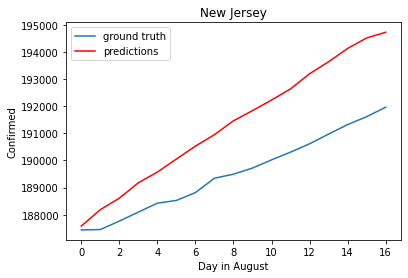

Date: 2020-09-01 00:00:00, predicted=192267.626452
Date: 2020-09-02 00:00:00, predicted=192649.289075
Date: 2020-09-03 00:00:00, predicted=192964.740820
Date: 2020-09-04 00:00:00, predicted=193283.479890
Date: 2020-09-05 00:00:00, predicted=193495.479861
Date: 2020-09-06 00:00:00, predicted=193618.071978
Date: 2020-09-07 00:00:00, predicted=193907.835546
Date: 2020-09-08 00:00:00, predicted=194223.295242
Date: 2020-09-09 00:00:00, predicted=194622.913613
Date: 2020-09-10 00:00:00, predicted=194882.651907
Date: 2020-09-11 00:00:00, predicted=195116.949132
Date: 2020-09-12 00:00:00, predicted=195354.426771
Date: 2020-09-13 00:00:00, predicted=195496.394007
Date: 2020-09-14 00:00:00, predicted=195577.881332
Date: 2020-09-15 00:00:00, predicted=195830.013516
Date: 2020-09-16 00:00:00, predicted=196145.913843
Date: 2020-09-17 00:00:00, predicted=196375.093984
Date: 2020-09-18 00:00:00, predicted=196560.904556
Date: 2020-09-19 00:00:00, predicted=196789.391165
Date: 2020-09-20 00:00:00, pred

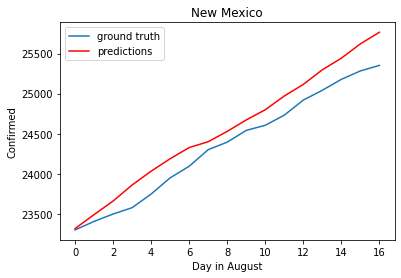

Date: 2020-09-01 00:00:00, predicted=25464.690688
Date: 2020-09-02 00:00:00, predicted=25581.225607
Date: 2020-09-03 00:00:00, predicted=25736.986577
Date: 2020-09-04 00:00:00, predicted=25857.716951
Date: 2020-09-05 00:00:00, predicted=25978.681306
Date: 2020-09-06 00:00:00, predicted=26066.907188
Date: 2020-09-07 00:00:00, predicted=26150.042266
Date: 2020-09-08 00:00:00, predicted=26253.598279
Date: 2020-09-09 00:00:00, predicted=26339.348866
Date: 2020-09-10 00:00:00, predicted=26482.917001
Date: 2020-09-11 00:00:00, predicted=26609.049897
Date: 2020-09-12 00:00:00, predicted=26717.355900
Date: 2020-09-13 00:00:00, predicted=26821.737448
Date: 2020-09-14 00:00:00, predicted=26912.352747
Date: 2020-09-15 00:00:00, predicted=27000.223868
Date: 2020-09-16 00:00:00, predicted=27098.659895
Date: 2020-09-17 00:00:00, predicted=27200.217976
Date: 2020-09-18 00:00:00, predicted=27312.679877
Date: 2020-09-19 00:00:00, predicted=27411.379816
Date: 2020-09-20 00:00:00, predicted=27513.468384


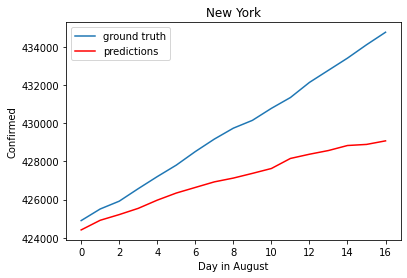

Date: 2020-09-01 00:00:00, predicted=435241.512532
Date: 2020-09-02 00:00:00, predicted=436052.744375
Date: 2020-09-03 00:00:00, predicted=436706.644258
Date: 2020-09-04 00:00:00, predicted=437369.502256
Date: 2020-09-05 00:00:00, predicted=437865.682511
Date: 2020-09-06 00:00:00, predicted=438360.123128
Date: 2020-09-07 00:00:00, predicted=438613.426917
Date: 2020-09-08 00:00:00, predicted=439087.328565
Date: 2020-09-09 00:00:00, predicted=439685.655074
Date: 2020-09-10 00:00:00, predicted=440028.405098
Date: 2020-09-11 00:00:00, predicted=440449.021601
Date: 2020-09-12 00:00:00, predicted=440921.959402
Date: 2020-09-13 00:00:00, predicted=441180.142592
Date: 2020-09-14 00:00:00, predicted=441422.601902
Date: 2020-09-15 00:00:00, predicted=441722.750412
Date: 2020-09-16 00:00:00, predicted=442157.825830
Date: 2020-09-17 00:00:00, predicted=442481.212238
Date: 2020-09-18 00:00:00, predicted=442830.555940
Date: 2020-09-19 00:00:00, predicted=443035.592101
Date: 2020-09-20 00:00:00, pred

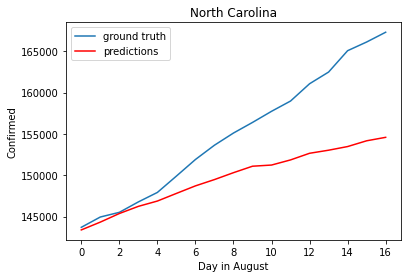

Date: 2020-09-01 00:00:00, predicted=168388.653073
Date: 2020-09-02 00:00:00, predicted=169738.325112
Date: 2020-09-03 00:00:00, predicted=171504.367098
Date: 2020-09-04 00:00:00, predicted=173276.068559
Date: 2020-09-05 00:00:00, predicted=175160.764954
Date: 2020-09-06 00:00:00, predicted=176417.033465
Date: 2020-09-07 00:00:00, predicted=177531.377466
Date: 2020-09-08 00:00:00, predicted=178828.479569
Date: 2020-09-09 00:00:00, predicted=179883.700060
Date: 2020-09-10 00:00:00, predicted=181483.617958
Date: 2020-09-11 00:00:00, predicted=183139.481241
Date: 2020-09-12 00:00:00, predicted=184765.913903
Date: 2020-09-13 00:00:00, predicted=185966.086369
Date: 2020-09-14 00:00:00, predicted=186913.188238
Date: 2020-09-15 00:00:00, predicted=187792.106227
Date: 2020-09-16 00:00:00, predicted=188876.948127
Date: 2020-09-17 00:00:00, predicted=190440.611686
Date: 2020-09-18 00:00:00, predicted=191904.443129
Date: 2020-09-19 00:00:00, predicted=193405.502723
Date: 2020-09-20 00:00:00, pred

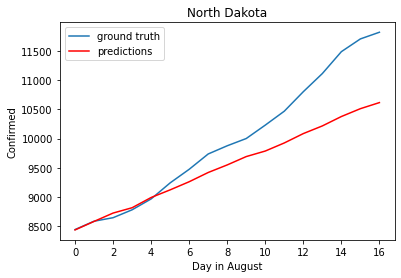

Date: 2020-09-01 00:00:00, predicted=12043.722362
Date: 2020-09-02 00:00:00, predicted=12290.112717
Date: 2020-09-03 00:00:00, predicted=12606.597616
Date: 2020-09-04 00:00:00, predicted=12964.294935
Date: 2020-09-05 00:00:00, predicted=13329.956426
Date: 2020-09-06 00:00:00, predicted=13575.254717
Date: 2020-09-07 00:00:00, predicted=13788.916195
Date: 2020-09-08 00:00:00, predicted=13986.394923
Date: 2020-09-09 00:00:00, predicted=14204.868250
Date: 2020-09-10 00:00:00, predicted=14552.062443
Date: 2020-09-11 00:00:00, predicted=14896.353852
Date: 2020-09-12 00:00:00, predicted=15268.467172
Date: 2020-09-13 00:00:00, predicted=15584.434585
Date: 2020-09-14 00:00:00, predicted=15822.885911
Date: 2020-09-15 00:00:00, predicted=16033.980614
Date: 2020-09-16 00:00:00, predicted=16280.101005
Date: 2020-09-17 00:00:00, predicted=16599.335585
Date: 2020-09-18 00:00:00, predicted=16936.841155
Date: 2020-09-19 00:00:00, predicted=17294.605792
Date: 2020-09-20 00:00:00, predicted=17632.231270


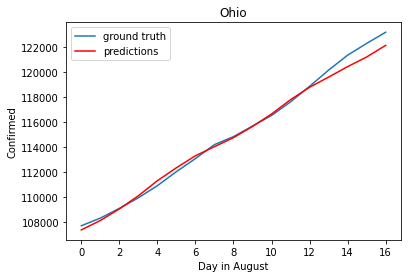

Date: 2020-09-01 00:00:00, predicted=124116.262988
Date: 2020-09-02 00:00:00, predicted=125229.770363
Date: 2020-09-03 00:00:00, predicted=126375.501138
Date: 2020-09-04 00:00:00, predicted=127468.855974
Date: 2020-09-05 00:00:00, predicted=128465.700021
Date: 2020-09-06 00:00:00, predicted=129299.489897
Date: 2020-09-07 00:00:00, predicted=130155.976387
Date: 2020-09-08 00:00:00, predicted=131273.160289
Date: 2020-09-09 00:00:00, predicted=132455.906380
Date: 2020-09-10 00:00:00, predicted=133727.287197
Date: 2020-09-11 00:00:00, predicted=135009.915657
Date: 2020-09-12 00:00:00, predicted=136203.914450
Date: 2020-09-13 00:00:00, predicted=137175.947214
Date: 2020-09-14 00:00:00, predicted=138178.169109
Date: 2020-09-15 00:00:00, predicted=139306.068808
Date: 2020-09-16 00:00:00, predicted=140564.660654
Date: 2020-09-17 00:00:00, predicted=141817.450496
Date: 2020-09-18 00:00:00, predicted=143002.172650
Date: 2020-09-19 00:00:00, predicted=144077.693276
Date: 2020-09-20 00:00:00, pred

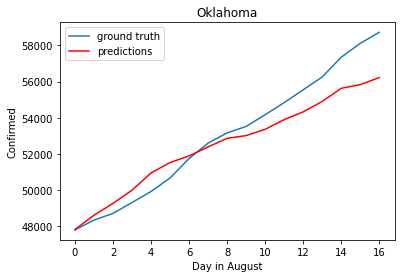

Date: 2020-09-01 00:00:00, predicted=59330.814538
Date: 2020-09-02 00:00:00, predicted=60048.487282
Date: 2020-09-03 00:00:00, predicted=60666.473644
Date: 2020-09-04 00:00:00, predicted=61592.071574
Date: 2020-09-05 00:00:00, predicted=62509.905008
Date: 2020-09-06 00:00:00, predicted=63180.832464
Date: 2020-09-07 00:00:00, predicted=63709.213337
Date: 2020-09-08 00:00:00, predicted=64376.414497
Date: 2020-09-09 00:00:00, predicted=65027.322858
Date: 2020-09-10 00:00:00, predicted=65760.510291
Date: 2020-09-11 00:00:00, predicted=66523.488872
Date: 2020-09-12 00:00:00, predicted=67458.714278
Date: 2020-09-13 00:00:00, predicted=68189.071968
Date: 2020-09-14 00:00:00, predicted=68797.560588
Date: 2020-09-15 00:00:00, predicted=69405.699426
Date: 2020-09-16 00:00:00, predicted=70017.930365
Date: 2020-09-17 00:00:00, predicted=70603.784768
Date: 2020-09-18 00:00:00, predicted=71391.258354
Date: 2020-09-19 00:00:00, predicted=72291.209694
Date: 2020-09-20 00:00:00, predicted=73054.681797


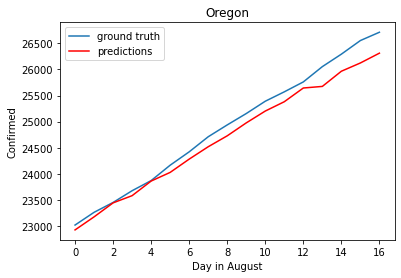

Date: 2020-09-01 00:00:00, predicted=26942.099522
Date: 2020-09-02 00:00:00, predicted=27144.633967
Date: 2020-09-03 00:00:00, predicted=27335.962526
Date: 2020-09-04 00:00:00, predicted=27545.492747
Date: 2020-09-05 00:00:00, predicted=27747.238698
Date: 2020-09-06 00:00:00, predicted=27961.994338
Date: 2020-09-07 00:00:00, predicted=28136.942342
Date: 2020-09-08 00:00:00, predicted=28328.154375
Date: 2020-09-09 00:00:00, predicted=28533.035609
Date: 2020-09-10 00:00:00, predicted=28748.717031
Date: 2020-09-11 00:00:00, predicted=28951.203205
Date: 2020-09-12 00:00:00, predicted=29121.351656
Date: 2020-09-13 00:00:00, predicted=29306.623797
Date: 2020-09-14 00:00:00, predicted=29512.335134
Date: 2020-09-15 00:00:00, predicted=29678.367531
Date: 2020-09-16 00:00:00, predicted=29853.031536
Date: 2020-09-17 00:00:00, predicted=30043.648455
Date: 2020-09-18 00:00:00, predicted=30268.702887
Date: 2020-09-19 00:00:00, predicted=30445.838783
Date: 2020-09-20 00:00:00, predicted=30592.300545


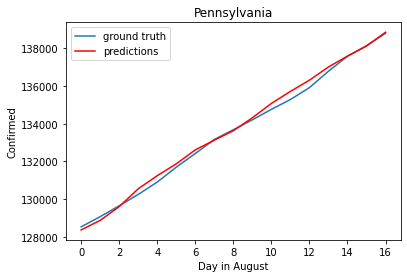

Date: 2020-09-01 00:00:00, predicted=139476.171006
Date: 2020-09-02 00:00:00, predicted=140001.426283
Date: 2020-09-03 00:00:00, predicted=140652.236812
Date: 2020-09-04 00:00:00, predicted=141387.245862
Date: 2020-09-05 00:00:00, predicted=142020.444478
Date: 2020-09-06 00:00:00, predicted=142521.208100
Date: 2020-09-07 00:00:00, predicted=143116.773830
Date: 2020-09-08 00:00:00, predicted=143680.108176
Date: 2020-09-09 00:00:00, predicted=144196.342546
Date: 2020-09-10 00:00:00, predicted=144709.893722
Date: 2020-09-11 00:00:00, predicted=145371.322437
Date: 2020-09-12 00:00:00, predicted=145921.098154
Date: 2020-09-13 00:00:00, predicted=146457.363787
Date: 2020-09-14 00:00:00, predicted=147133.624713
Date: 2020-09-15 00:00:00, predicted=147723.237134
Date: 2020-09-16 00:00:00, predicted=148337.586100
Date: 2020-09-17 00:00:00, predicted=148961.622507
Date: 2020-09-18 00:00:00, predicted=149610.279621
Date: 2020-09-19 00:00:00, predicted=150226.286152
Date: 2020-09-20 00:00:00, pred

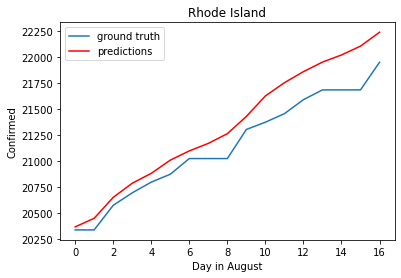

Date: 2020-09-01 00:00:00, predicted=22071.742380
Date: 2020-09-02 00:00:00, predicted=22123.936004
Date: 2020-09-03 00:00:00, predicted=22261.606282
Date: 2020-09-04 00:00:00, predicted=22348.439537
Date: 2020-09-05 00:00:00, predicted=22339.111428
Date: 2020-09-06 00:00:00, predicted=22396.809103
Date: 2020-09-07 00:00:00, predicted=22619.012058
Date: 2020-09-08 00:00:00, predicted=22707.414678
Date: 2020-09-09 00:00:00, predicted=22775.799623
Date: 2020-09-10 00:00:00, predicted=22862.233319
Date: 2020-09-11 00:00:00, predicted=22970.532374
Date: 2020-09-12 00:00:00, predicted=22978.317118
Date: 2020-09-13 00:00:00, predicted=23014.763402
Date: 2020-09-14 00:00:00, predicted=23229.430133
Date: 2020-09-15 00:00:00, predicted=23342.053765
Date: 2020-09-16 00:00:00, predicted=23426.866260
Date: 2020-09-17 00:00:00, predicted=23513.509699
Date: 2020-09-18 00:00:00, predicted=23584.533655
Date: 2020-09-19 00:00:00, predicted=23628.121939
Date: 2020-09-20 00:00:00, predicted=23659.609935


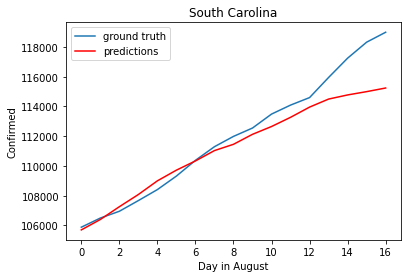

Date: 2020-09-01 00:00:00, predicted=119824.705153
Date: 2020-09-02 00:00:00, predicted=120688.105877
Date: 2020-09-03 00:00:00, predicted=121672.812111
Date: 2020-09-04 00:00:00, predicted=122916.596902
Date: 2020-09-05 00:00:00, predicted=124109.223687
Date: 2020-09-06 00:00:00, predicted=125125.339598
Date: 2020-09-07 00:00:00, predicted=126339.130794
Date: 2020-09-08 00:00:00, predicted=127608.040837
Date: 2020-09-09 00:00:00, predicted=128739.858880
Date: 2020-09-10 00:00:00, predicted=129877.855190
Date: 2020-09-11 00:00:00, predicted=131374.307533
Date: 2020-09-12 00:00:00, predicted=132979.975271
Date: 2020-09-13 00:00:00, predicted=134355.983962
Date: 2020-09-14 00:00:00, predicted=135649.120729
Date: 2020-09-15 00:00:00, predicted=136994.584777
Date: 2020-09-16 00:00:00, predicted=138384.562113
Date: 2020-09-17 00:00:00, predicted=139875.217782
Date: 2020-09-18 00:00:00, predicted=141568.783970
Date: 2020-09-19 00:00:00, predicted=143231.407830
Date: 2020-09-20 00:00:00, pred

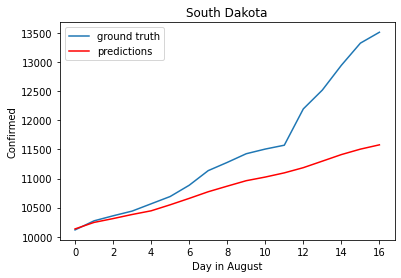

Date: 2020-09-01 00:00:00, predicted=13793.466287
Date: 2020-09-02 00:00:00, predicted=14165.786081
Date: 2020-09-03 00:00:00, predicted=14552.363306
Date: 2020-09-04 00:00:00, predicted=15106.369587
Date: 2020-09-05 00:00:00, predicted=15432.338522
Date: 2020-09-06 00:00:00, predicted=15748.949694
Date: 2020-09-07 00:00:00, predicted=16133.636327
Date: 2020-09-08 00:00:00, predicted=16338.946569
Date: 2020-09-09 00:00:00, predicted=16790.923210
Date: 2020-09-10 00:00:00, predicted=17286.180628
Date: 2020-09-11 00:00:00, predicted=17840.795462
Date: 2020-09-12 00:00:00, predicted=18291.887555
Date: 2020-09-13 00:00:00, predicted=18613.083237
Date: 2020-09-14 00:00:00, predicted=18970.362942
Date: 2020-09-15 00:00:00, predicted=19307.589752
Date: 2020-09-16 00:00:00, predicted=19738.339133
Date: 2020-09-17 00:00:00, predicted=20310.172698
Date: 2020-09-18 00:00:00, predicted=20773.723303
Date: 2020-09-19 00:00:00, predicted=21187.551438
Date: 2020-09-20 00:00:00, predicted=21593.177532


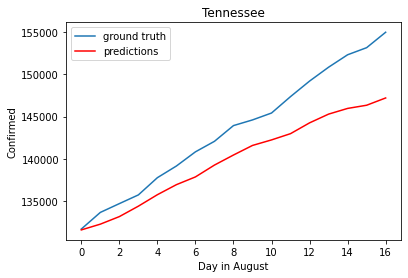

Date: 2020-09-01 00:00:00, predicted=156052.019547
Date: 2020-09-02 00:00:00, predicted=157090.376708
Date: 2020-09-03 00:00:00, predicted=158202.797641
Date: 2020-09-04 00:00:00, predicted=159590.931973
Date: 2020-09-05 00:00:00, predicted=161297.484743
Date: 2020-09-06 00:00:00, predicted=162817.804849
Date: 2020-09-07 00:00:00, predicted=164181.567811
Date: 2020-09-08 00:00:00, predicted=165129.398496
Date: 2020-09-09 00:00:00, predicted=166417.043512
Date: 2020-09-10 00:00:00, predicted=167804.154762
Date: 2020-09-11 00:00:00, predicted=168749.244810
Date: 2020-09-12 00:00:00, predicted=170220.926786
Date: 2020-09-13 00:00:00, predicted=171531.712375
Date: 2020-09-14 00:00:00, predicted=172862.153004
Date: 2020-09-15 00:00:00, predicted=173941.705413
Date: 2020-09-16 00:00:00, predicted=174830.236898
Date: 2020-09-17 00:00:00, predicted=176027.512324
Date: 2020-09-18 00:00:00, predicted=176969.895168
Date: 2020-09-19 00:00:00, predicted=178753.051897
Date: 2020-09-20 00:00:00, pred

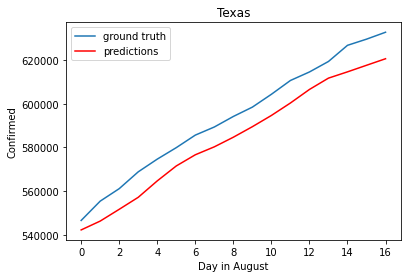

Date: 2020-09-01 00:00:00, predicted=637552.456008
Date: 2020-09-02 00:00:00, predicted=641070.287789
Date: 2020-09-03 00:00:00, predicted=645784.777562
Date: 2020-09-04 00:00:00, predicted=650722.510154
Date: 2020-09-05 00:00:00, predicted=655046.278790
Date: 2020-09-06 00:00:00, predicted=657274.977195
Date: 2020-09-07 00:00:00, predicted=660152.485555
Date: 2020-09-08 00:00:00, predicted=663810.364040
Date: 2020-09-09 00:00:00, predicted=666786.970958
Date: 2020-09-10 00:00:00, predicted=669695.339592
Date: 2020-09-11 00:00:00, predicted=673309.186251
Date: 2020-09-12 00:00:00, predicted=676678.408553
Date: 2020-09-13 00:00:00, predicted=679244.274896
Date: 2020-09-14 00:00:00, predicted=682164.651110
Date: 2020-09-15 00:00:00, predicted=685052.604090
Date: 2020-09-16 00:00:00, predicted=687728.565647
Date: 2020-09-17 00:00:00, predicted=690332.663330
Date: 2020-09-18 00:00:00, predicted=693174.361230
Date: 2020-09-19 00:00:00, predicted=695404.455043
Date: 2020-09-20 00:00:00, pred

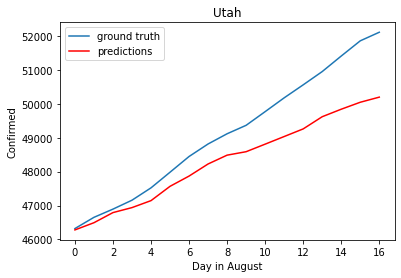

Date: 2020-09-01 00:00:00, predicted=52452.041407
Date: 2020-09-02 00:00:00, predicted=52840.679977
Date: 2020-09-03 00:00:00, predicted=53307.659049
Date: 2020-09-04 00:00:00, predicted=53821.174890
Date: 2020-09-05 00:00:00, predicted=54150.590345
Date: 2020-09-06 00:00:00, predicted=54514.127290
Date: 2020-09-07 00:00:00, predicted=54924.820253
Date: 2020-09-08 00:00:00, predicted=55295.622052
Date: 2020-09-09 00:00:00, predicted=55704.330793
Date: 2020-09-10 00:00:00, predicted=56142.966905
Date: 2020-09-11 00:00:00, predicted=56615.945139
Date: 2020-09-12 00:00:00, predicted=57089.994158
Date: 2020-09-13 00:00:00, predicted=57454.595915
Date: 2020-09-14 00:00:00, predicted=57774.604510
Date: 2020-09-15 00:00:00, predicted=58159.704113
Date: 2020-09-16 00:00:00, predicted=58597.699684
Date: 2020-09-17 00:00:00, predicted=59056.322548
Date: 2020-09-18 00:00:00, predicted=59548.695059
Date: 2020-09-19 00:00:00, predicted=59954.412818
Date: 2020-09-20 00:00:00, predicted=60315.586640


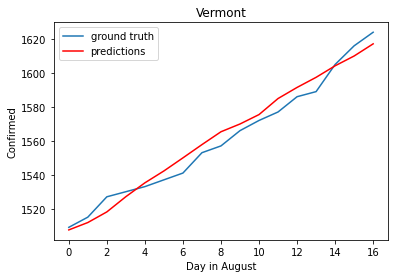

Date: 2020-09-01 00:00:00, predicted=1633.897553
Date: 2020-09-02 00:00:00, predicted=1636.867922
Date: 2020-09-03 00:00:00, predicted=1643.444053
Date: 2020-09-04 00:00:00, predicted=1651.449586
Date: 2020-09-05 00:00:00, predicted=1658.961828
Date: 2020-09-06 00:00:00, predicted=1666.534843
Date: 2020-09-07 00:00:00, predicted=1671.190091
Date: 2020-09-08 00:00:00, predicted=1677.580861
Date: 2020-09-09 00:00:00, predicted=1680.944735
Date: 2020-09-10 00:00:00, predicted=1683.956101
Date: 2020-09-11 00:00:00, predicted=1693.107340
Date: 2020-09-12 00:00:00, predicted=1700.641294
Date: 2020-09-13 00:00:00, predicted=1708.485688
Date: 2020-09-14 00:00:00, predicted=1716.041170
Date: 2020-09-15 00:00:00, predicted=1721.164371
Date: 2020-09-16 00:00:00, predicted=1728.862847
Date: 2020-09-17 00:00:00, predicted=1733.848709
Date: 2020-09-18 00:00:00, predicted=1740.639258
Date: 2020-09-19 00:00:00, predicted=1749.581342
Date: 2020-09-20 00:00:00, predicted=1757.546259
Date: 2020-09-21 00:

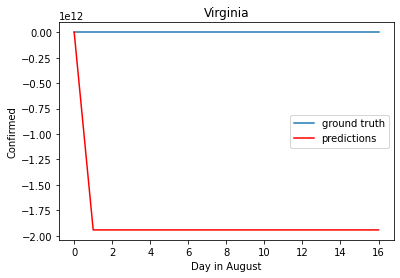

Date: 2020-09-01 00:00:00, predicted=121580.673522
Date: 2020-09-02 00:00:00, predicted=122591.939524
Date: 2020-09-03 00:00:00, predicted=123794.911923
Date: 2020-09-04 00:00:00, predicted=124752.221772
Date: 2020-09-05 00:00:00, predicted=125681.140745
Date: 2020-09-06 00:00:00, predicted=126492.363656
Date: 2020-09-07 00:00:00, predicted=127478.662395
Date: 2020-09-08 00:00:00, predicted=128254.556101
Date: 2020-09-09 00:00:00, predicted=129195.125062
Date: 2020-09-10 00:00:00, predicted=130366.760386
Date: 2020-09-11 00:00:00, predicted=131496.058799
Date: 2020-09-12 00:00:00, predicted=132334.818830
Date: 2020-09-13 00:00:00, predicted=133167.152186
Date: 2020-09-14 00:00:00, predicted=134005.291799
Date: 2020-09-15 00:00:00, predicted=134799.956483
Date: 2020-09-16 00:00:00, predicted=135832.786483
Date: 2020-09-17 00:00:00, predicted=136849.306827
Date: 2020-09-18 00:00:00, predicted=137821.138973
Date: 2020-09-19 00:00:00, predicted=138672.670275
Date: 2020-09-20 00:00:00, pred

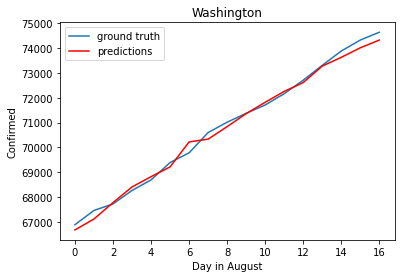

Date: 2020-09-01 00:00:00, predicted=75153.636614
Date: 2020-09-02 00:00:00, predicted=75396.556099
Date: 2020-09-03 00:00:00, predicted=76140.790592
Date: 2020-09-04 00:00:00, predicted=76535.545499
Date: 2020-09-05 00:00:00, predicted=77121.574014
Date: 2020-09-06 00:00:00, predicted=77413.363408
Date: 2020-09-07 00:00:00, predicted=77754.220654
Date: 2020-09-08 00:00:00, predicted=78092.368138
Date: 2020-09-09 00:00:00, predicted=78466.109997
Date: 2020-09-10 00:00:00, predicted=79013.495782
Date: 2020-09-11 00:00:00, predicted=79464.748817
Date: 2020-09-12 00:00:00, predicted=79906.628949
Date: 2020-09-13 00:00:00, predicted=80222.335446
Date: 2020-09-14 00:00:00, predicted=80531.546675
Date: 2020-09-15 00:00:00, predicted=80879.173589
Date: 2020-09-16 00:00:00, predicted=81216.976638
Date: 2020-09-17 00:00:00, predicted=81666.136006
Date: 2020-09-18 00:00:00, predicted=82091.398956
Date: 2020-09-19 00:00:00, predicted=82442.295897
Date: 2020-09-20 00:00:00, predicted=82737.790615


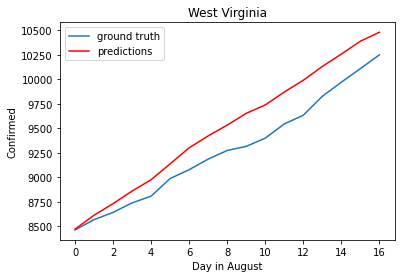

Date: 2020-09-01 00:00:00, predicted=10348.411295
Date: 2020-09-02 00:00:00, predicted=10488.686635
Date: 2020-09-03 00:00:00, predicted=10660.163933
Date: 2020-09-04 00:00:00, predicted=10850.907375
Date: 2020-09-05 00:00:00, predicted=10982.706799
Date: 2020-09-06 00:00:00, predicted=11124.558393
Date: 2020-09-07 00:00:00, predicted=11232.499887
Date: 2020-09-08 00:00:00, predicted=11336.989630
Date: 2020-09-09 00:00:00, predicted=11453.806730
Date: 2020-09-10 00:00:00, predicted=11595.230150
Date: 2020-09-11 00:00:00, predicted=11733.171302
Date: 2020-09-12 00:00:00, predicted=11909.931699
Date: 2020-09-13 00:00:00, predicted=12016.709158
Date: 2020-09-14 00:00:00, predicted=12140.988569
Date: 2020-09-15 00:00:00, predicted=12260.906725
Date: 2020-09-16 00:00:00, predicted=12375.377874
Date: 2020-09-17 00:00:00, predicted=12559.638429
Date: 2020-09-18 00:00:00, predicted=12726.277895
Date: 2020-09-19 00:00:00, predicted=12879.631854
Date: 2020-09-20 00:00:00, predicted=13032.021063


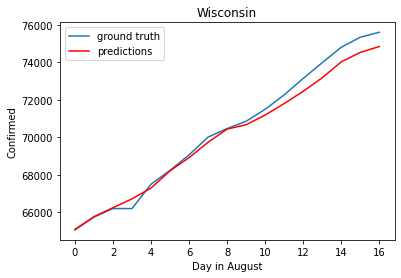

Date: 2020-09-01 00:00:00, predicted=76053.736483
Date: 2020-09-02 00:00:00, predicted=76898.888688
Date: 2020-09-03 00:00:00, predicted=77685.832015
Date: 2020-09-04 00:00:00, predicted=78544.027245
Date: 2020-09-05 00:00:00, predicted=79053.195558
Date: 2020-09-06 00:00:00, predicted=79608.615348
Date: 2020-09-07 00:00:00, predicted=79903.146166
Date: 2020-09-08 00:00:00, predicted=80274.606062
Date: 2020-09-09 00:00:00, predicted=81104.965410
Date: 2020-09-10 00:00:00, predicted=81863.232036
Date: 2020-09-11 00:00:00, predicted=82390.209790
Date: 2020-09-12 00:00:00, predicted=83154.086367
Date: 2020-09-13 00:00:00, predicted=83532.674836
Date: 2020-09-14 00:00:00, predicted=83736.828078
Date: 2020-09-15 00:00:00, predicted=84310.895381
Date: 2020-09-16 00:00:00, predicted=84839.301719
Date: 2020-09-17 00:00:00, predicted=85641.631426
Date: 2020-09-18 00:00:00, predicted=86295.967605
Date: 2020-09-19 00:00:00, predicted=86739.657242
Date: 2020-09-20 00:00:00, predicted=87275.271956


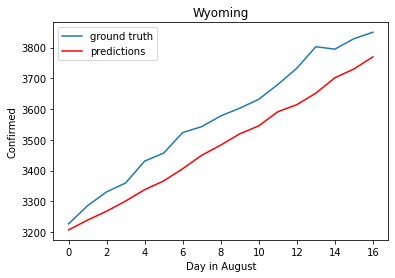

Date: 2020-09-01 00:00:00, predicted=3863.879011
Date: 2020-09-02 00:00:00, predicted=3896.049111
Date: 2020-09-03 00:00:00, predicted=3914.232805
Date: 2020-09-04 00:00:00, predicted=3926.964757
Date: 2020-09-05 00:00:00, predicted=3946.055900
Date: 2020-09-06 00:00:00, predicted=3954.013430
Date: 2020-09-07 00:00:00, predicted=3982.179916
Date: 2020-09-08 00:00:00, predicted=4013.743835
Date: 2020-09-09 00:00:00, predicted=4055.943415
Date: 2020-09-10 00:00:00, predicted=4091.938507
Date: 2020-09-11 00:00:00, predicted=4136.406065
Date: 2020-09-12 00:00:00, predicted=4163.958969
Date: 2020-09-13 00:00:00, predicted=4196.591132
Date: 2020-09-14 00:00:00, predicted=4229.623114
Date: 2020-09-15 00:00:00, predicted=4254.619414
Date: 2020-09-16 00:00:00, predicted=4282.844898
Date: 2020-09-17 00:00:00, predicted=4313.444338
Date: 2020-09-18 00:00:00, predicted=4337.511918
Date: 2020-09-19 00:00:00, predicted=4374.678301
Date: 2020-09-20 00:00:00, predicted=4397.177281
Date: 2020-09-21 00:

In [17]:
cumulative_MAPE = 0
confirmed_output_df = pd.DataFrame()

for state in state_names:
    results, err = evaluate_ARIMA_model(confirmed_train, confirmed_test, state)
    cumulative_MAPE += err
    confirmed_output_df = confirmed_output_df.append(results)
    
overall_average_MAPE = cumulative_MAPE/50

In [20]:
# Adjust MAPE for troublesome values (Florida, Georgia, Virginia)
# Reason for negative predictions likely a result of 
overall_average_MAPE = ((overall_average_MAPE*50)-79.602-39.977-1614843320.068)/47

print("Average MAPE for Confirmed: {}%".format(overall_average_MAPE))
f = open("ARIMA_Confirmed_MAPE.txt", "w")
f.write(str(overall_average_MAPE))
f.close()

# Actual MAPE: 1.817574468

confirmed_output_df = confirmed_output_df.sort_values(by=['Date', 'Province_State'])
confirmed_output_df.to_csv('ARIMA_Confirmed_Predictions.csv', index=False)

Average MAPE for Confirmed: -34358369.12275457%


# Deaths Dataset Modeling

### Make Plots For Each State

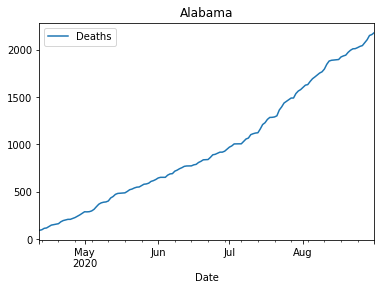

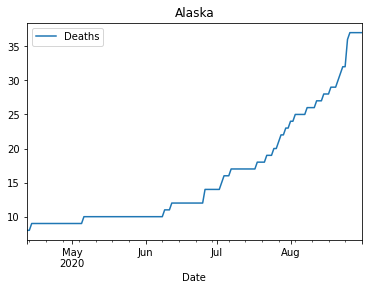

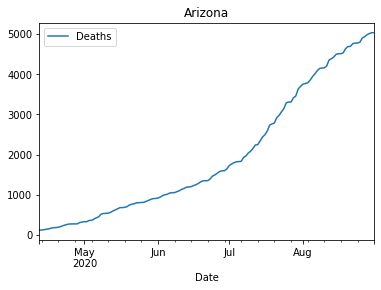

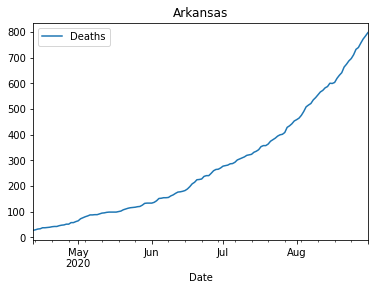

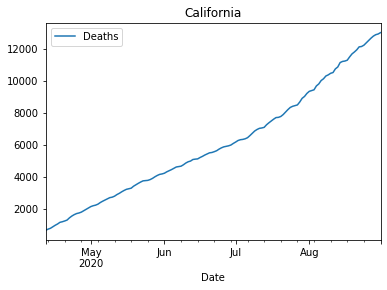

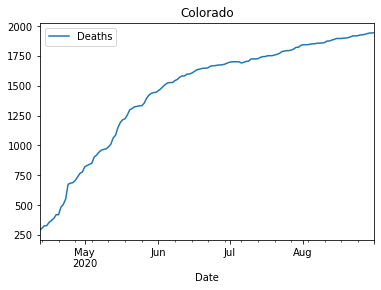

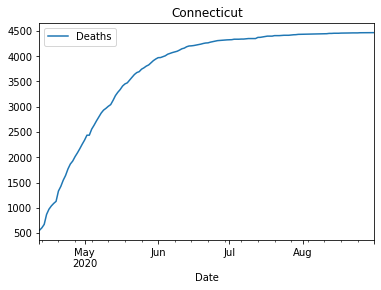

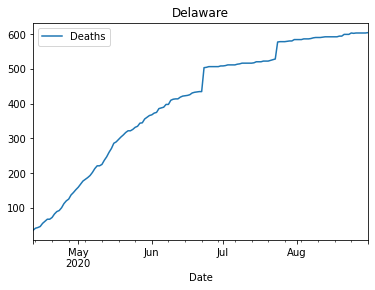

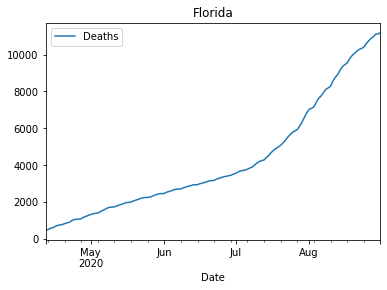

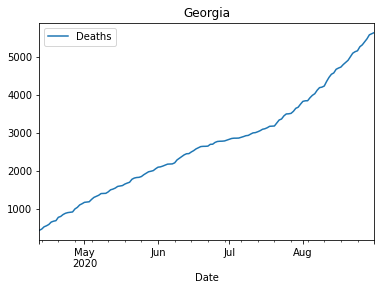

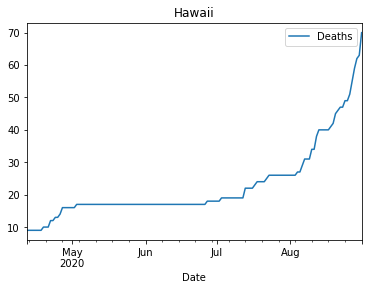

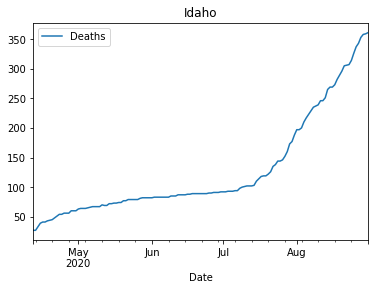

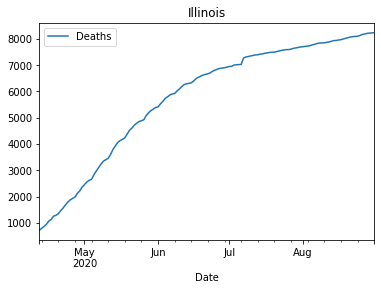

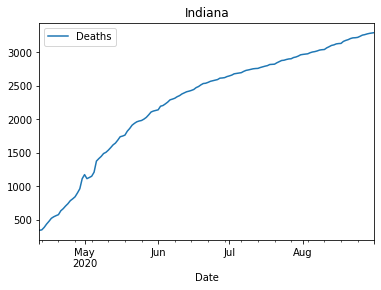

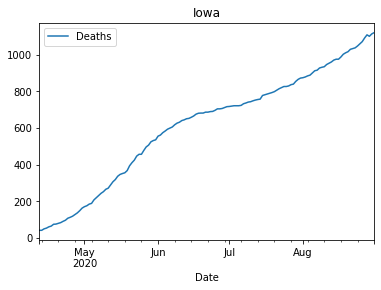

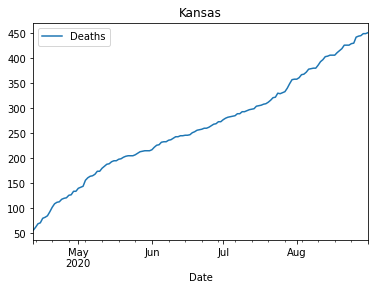

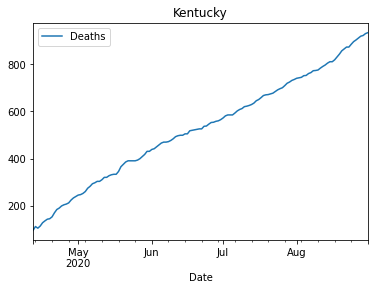

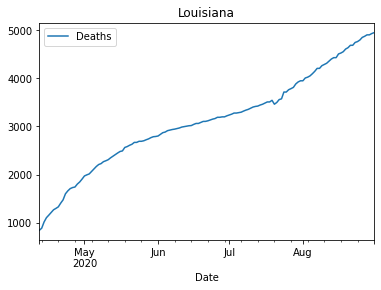

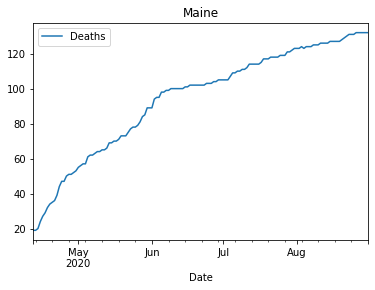

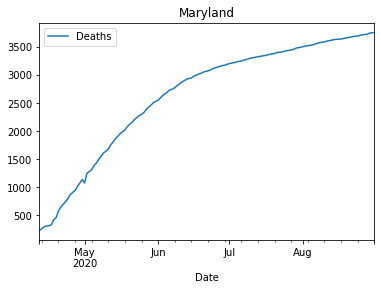

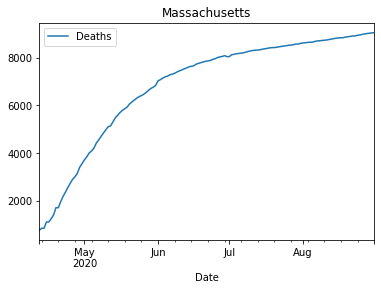

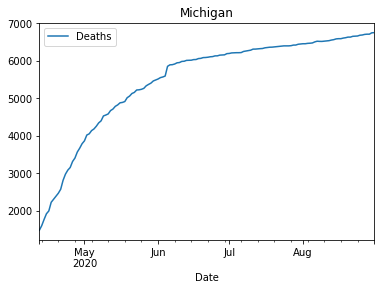

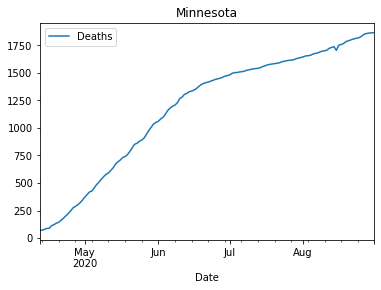

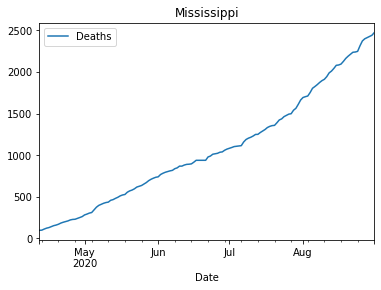

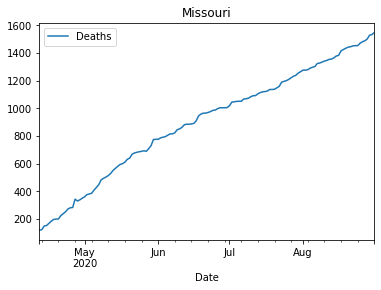

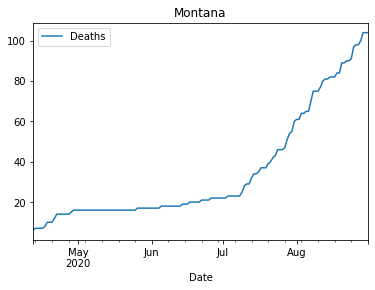

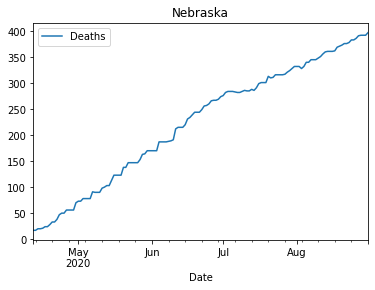

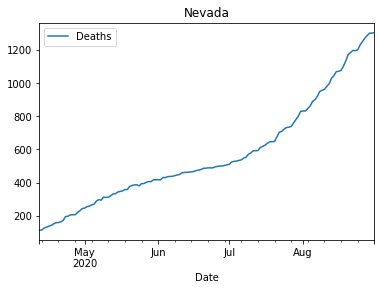

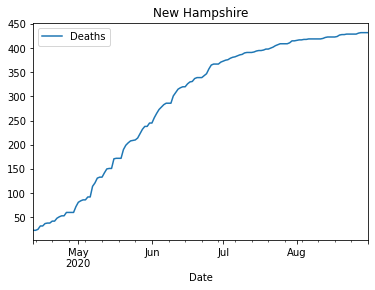

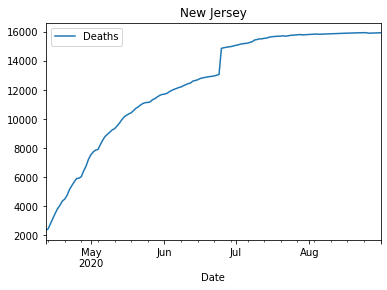

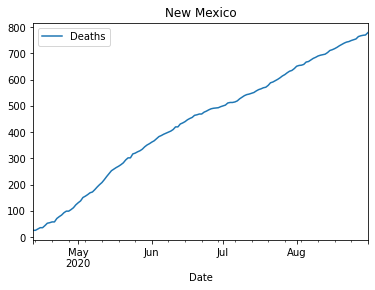

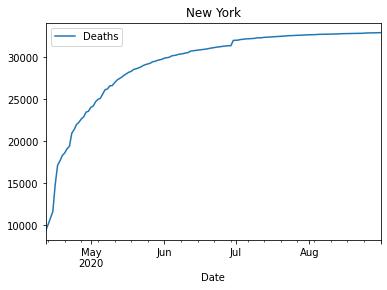

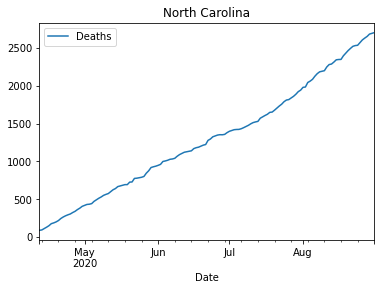

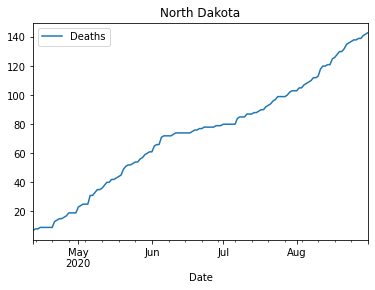

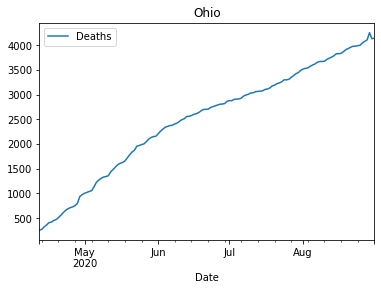

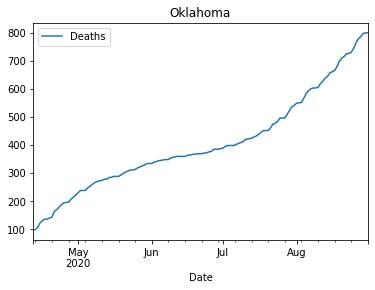

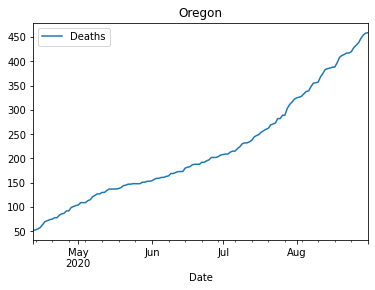

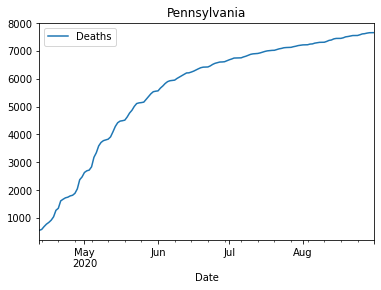

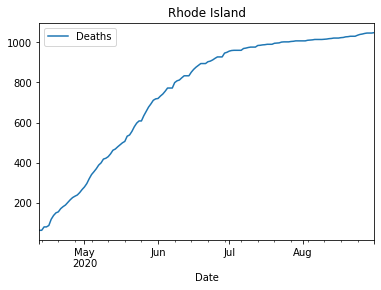

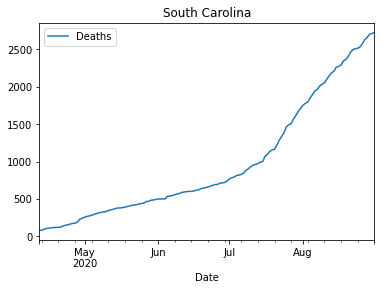

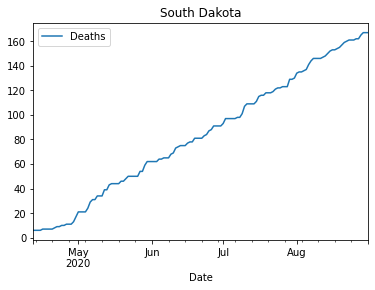

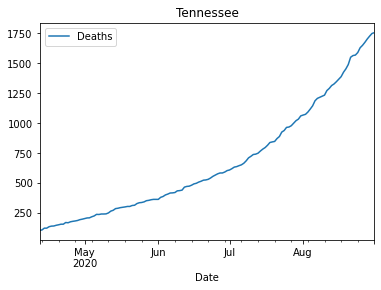

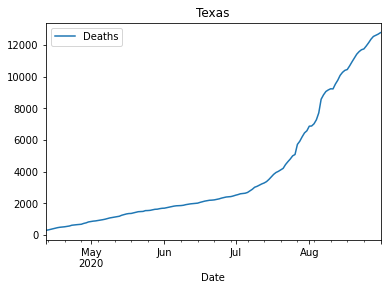

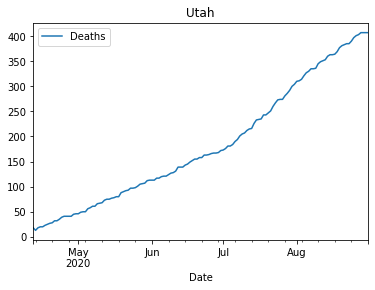

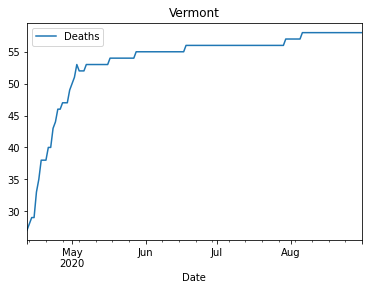

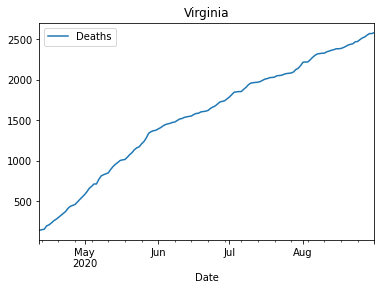

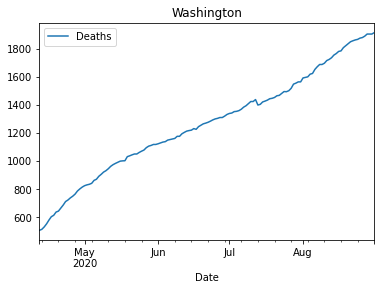

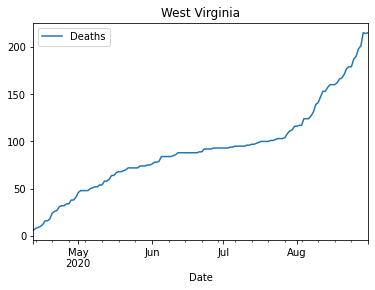

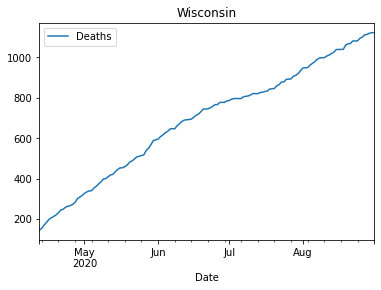

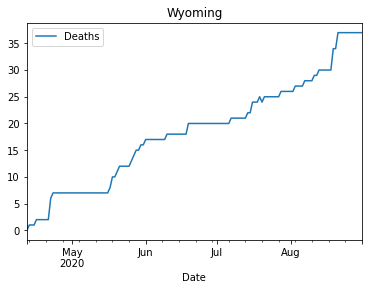

In [23]:
for state in state_names:
    state_df = deaths_df[deaths_df.Province_State == state][['Date', 'Deaths']]
    state_df.plot('Date','Deaths', title=state)
    pyplot.show()

We can see that the deaths dataset for each state has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

### Create Autocorrelation Plots

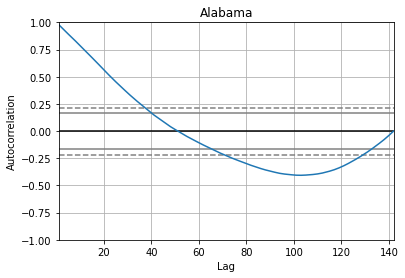

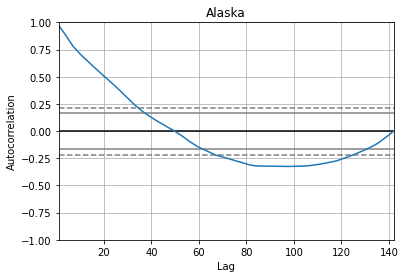

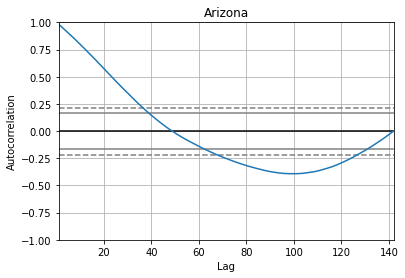

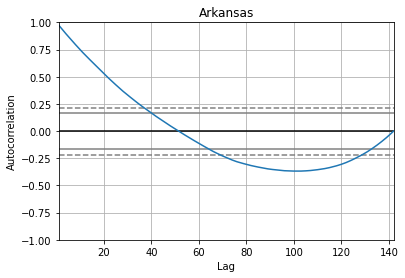

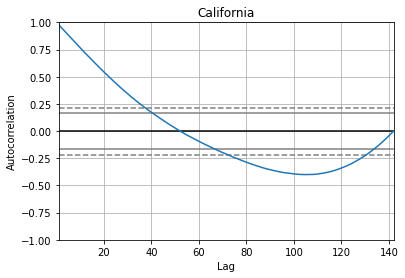

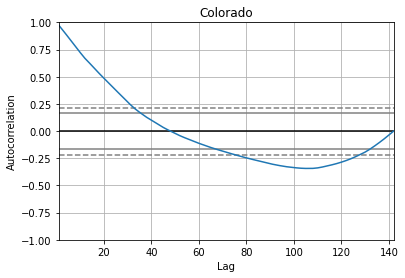

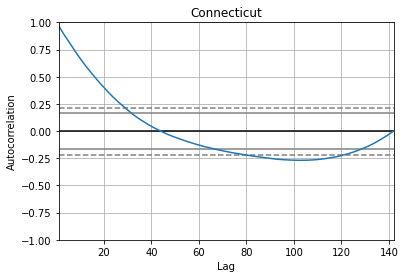

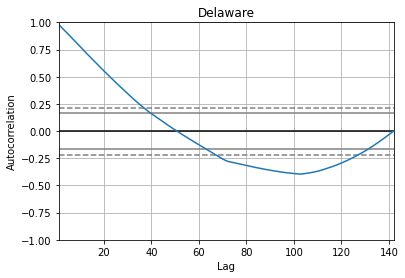

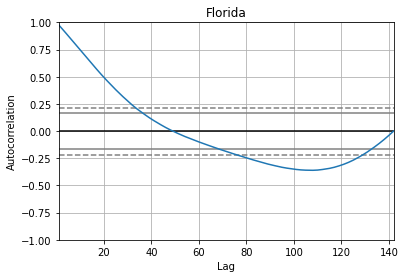

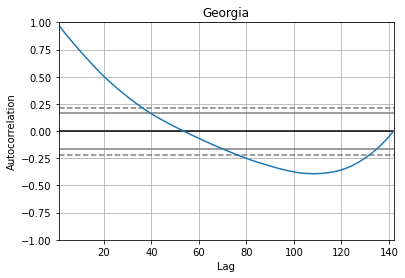

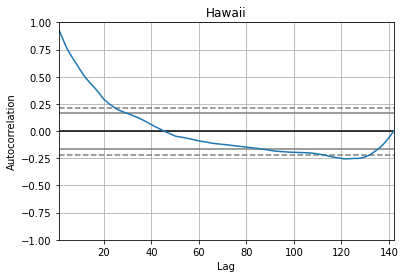

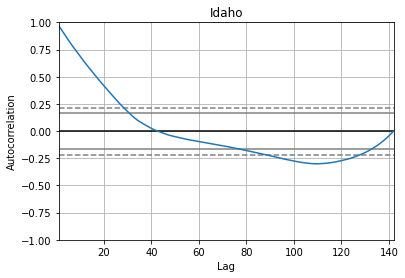

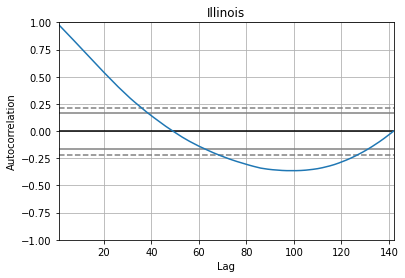

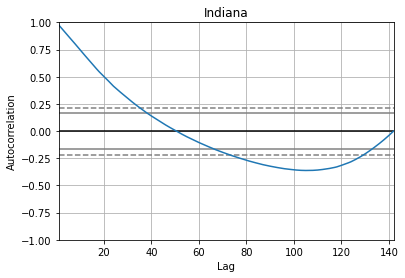

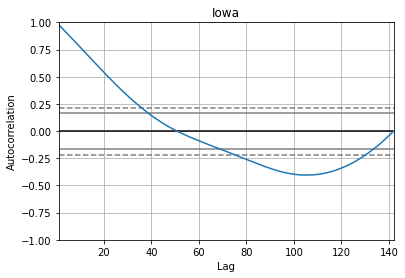

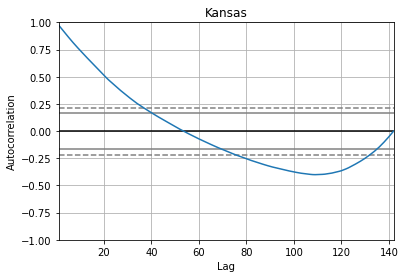

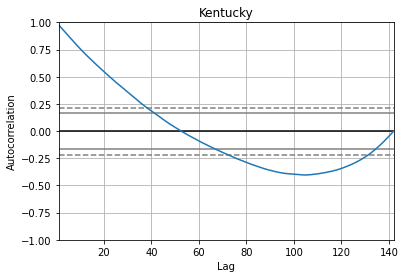

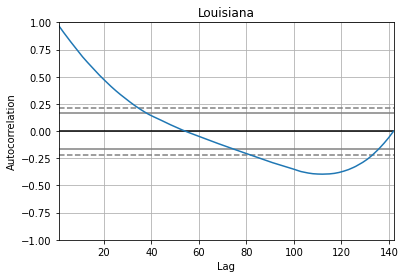

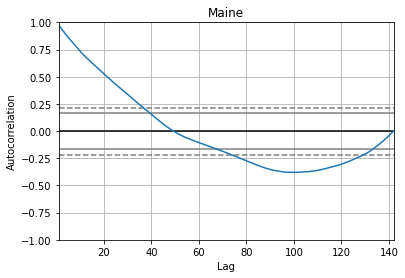

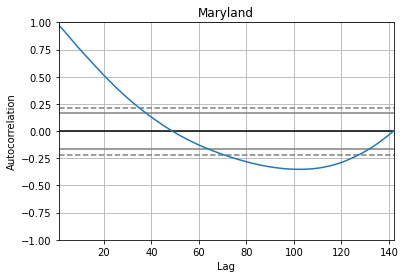

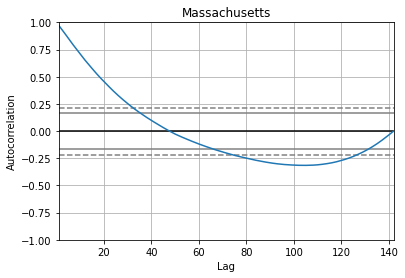

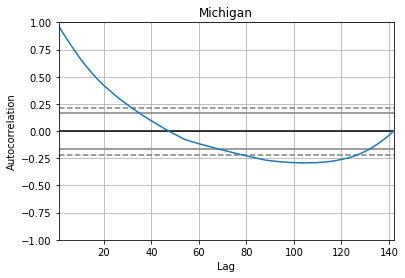

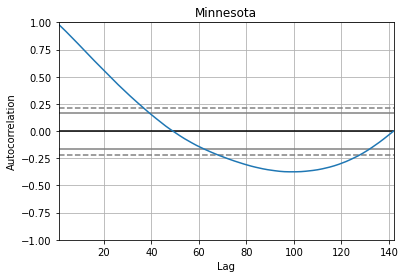

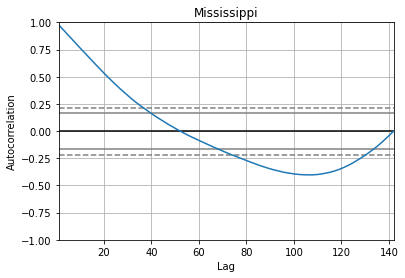

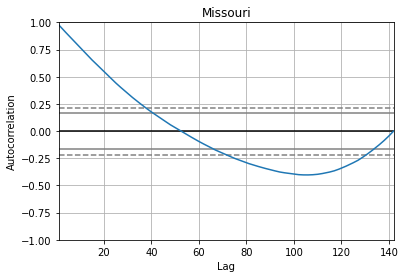

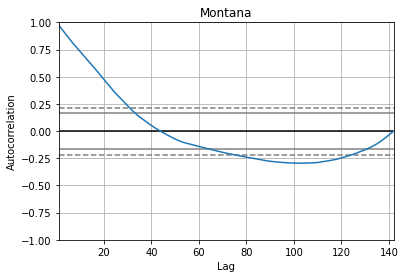

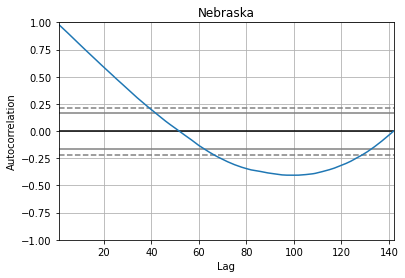

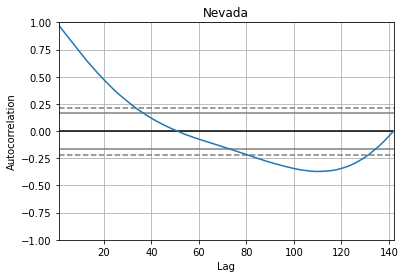

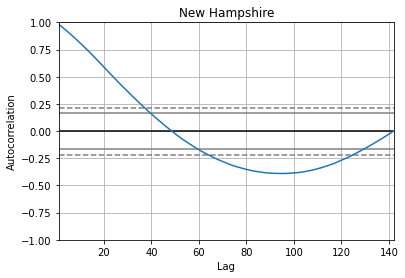

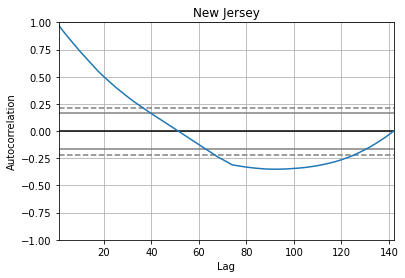

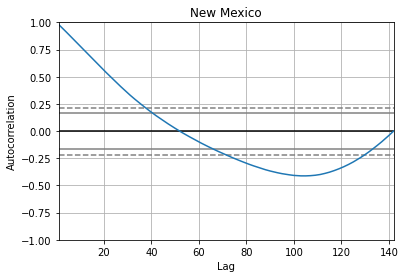

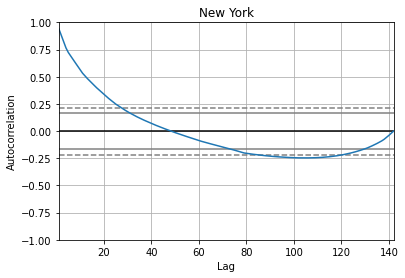

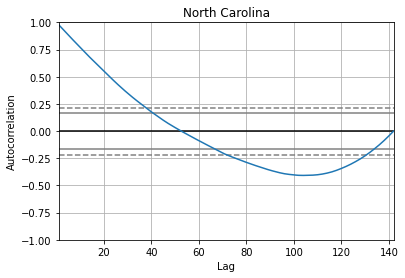

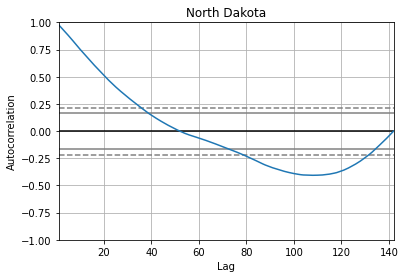

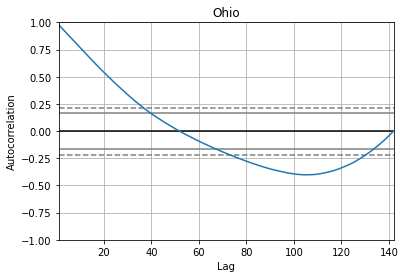

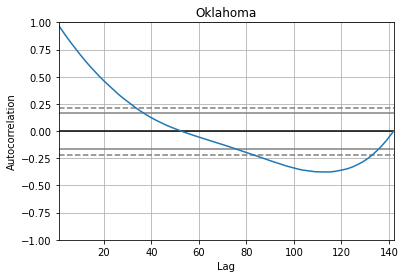

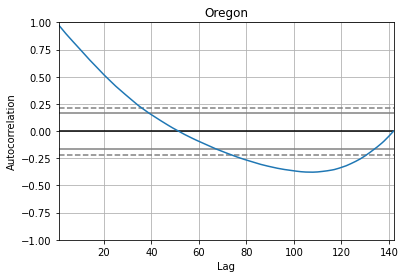

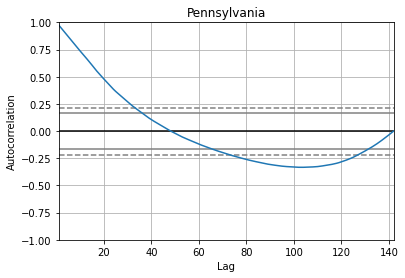

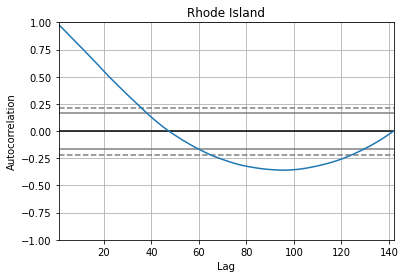

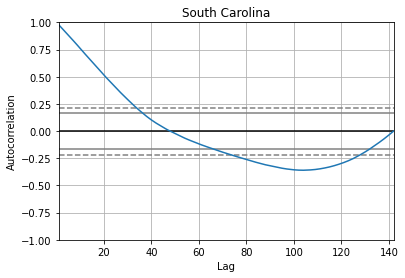

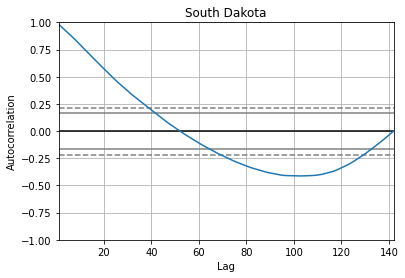

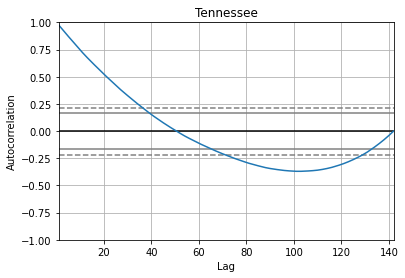

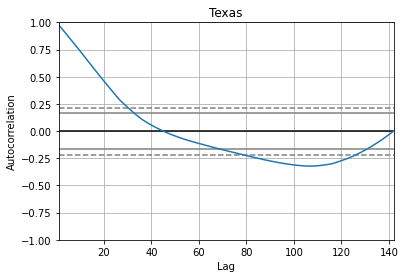

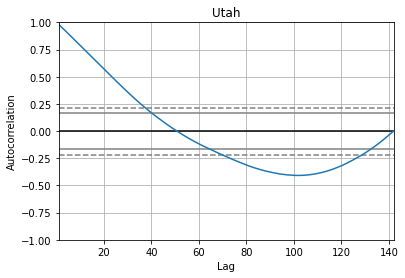

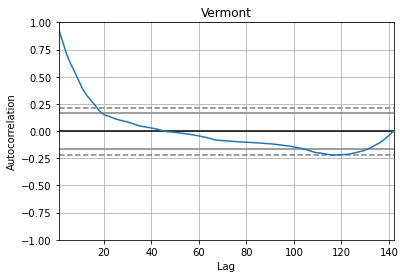

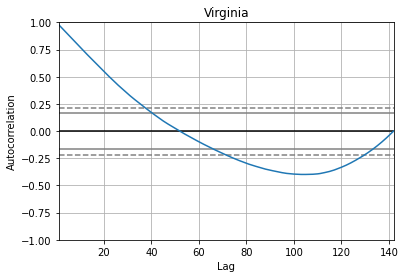

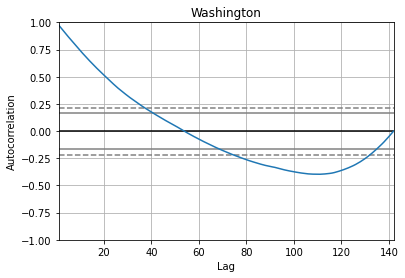

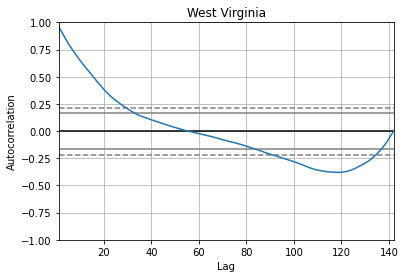

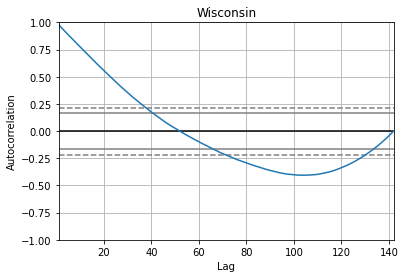

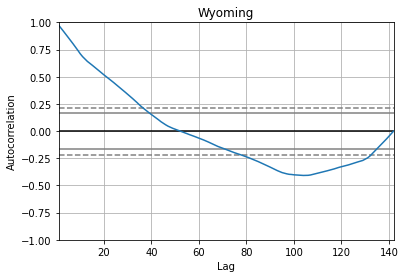

In [24]:
for state in state_names:
    state_df = deaths_df[deaths_df.Province_State == state][['Date', 'Deaths']]
    autocorrelation_plot(state_df['Deaths'])
    pyplot.title(state)
    pyplot.show()

It can be seen that for a majority of states, there is a positive correlation till the first 45-50 lags.

### Create Autocorrelation and Partial Autocorrelation Plots

From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

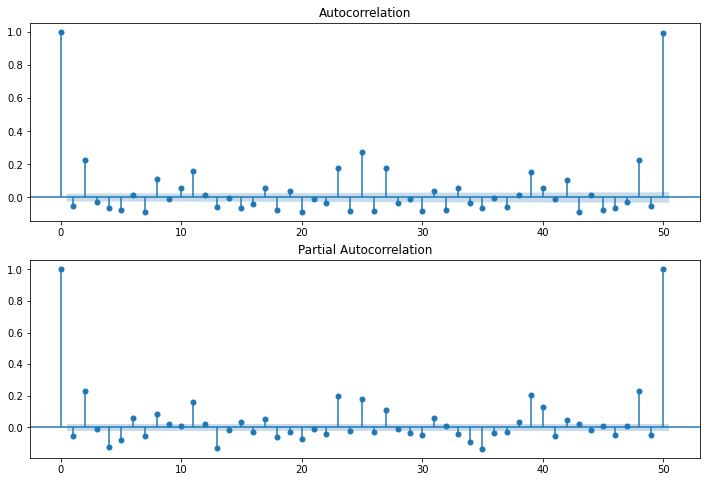

In [25]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(deaths_df.Deaths, lags=50, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(deaths_df.Deaths, lags=50, ax=ax2)# , lags=40

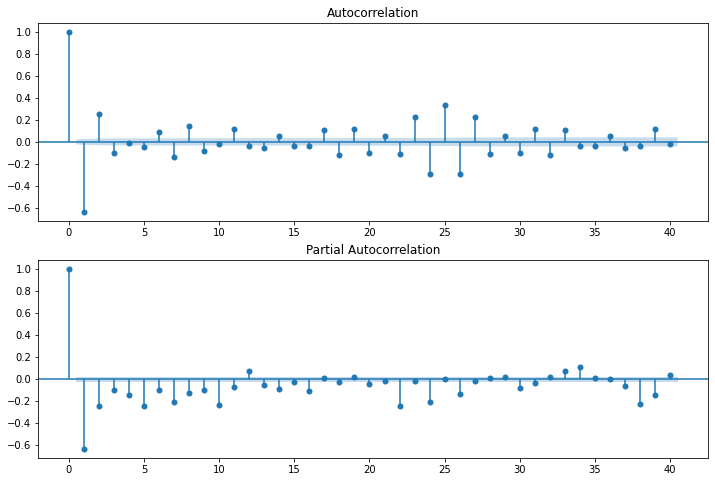

In [26]:
first_diff = deaths_df.Deaths - deaths_df.Deaths.shift(1)
first_diff = first_diff.dropna(inplace = False)

fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

### Fit Model

Training data is from April to August 15th, validation is from August 15th to August 30th

In [27]:
deaths_train = deaths_df[deaths_df.Date < '2020-08-15']
deaths_test = deaths_df[deaths_df.Date >= '2020-08-15']

In [28]:
def evaluate_ARIMA_model(train_dataframe, test_dataframe, state, arima_order=(45,1,0)):
    '''
        Ideal inputs:
            train_dataframe: deaths_train
            test_dataframe: deaths_test
            state: state_name
            arima_order: use default
        Returns:
            - dataframe with predictions for September
            - MAPE on validation data
    '''
    print("Running ARIMA for {}".format(state))
    # Split into state specific train and evaluation
    train = train_dataframe[train_dataframe.Province_State == state].reset_index(drop=True)
    test  = test_dataframe[test_dataframe.Province_State == state].reset_index(drop=True)
    # Get Data
    data = train.Deaths
    history = [x for x in data]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.Deaths[t]
        history.append(yhat)
        print('Date: %s, predicted=%f, expected=%f' % (test.Date[t], yhat, obs))
    error = mean_absolute_percentage_error(test.Deaths, predictions)
    print('Validation MAPE: %.3f' % error)
    # Plot
    ground_truth, = pyplot.plot(test.Deaths, label='ground truth')
    prediction_,  = pyplot.plot(predictions, color='red', label='predictions')
    pyplot.legend(handles=[ground_truth, prediction_])
    pyplot.title(state)
    pyplot.ylabel('Deaths')
    pyplot.xlabel('Day in August')
    pyplot.show()
    # predict for september
    history = [x for x in data]
    for val in list(test.Deaths):
        history.append(val)
    base = parser.parse('2020-09-01')
    september = [base + datetime.timedelta(days=x) for x in range(26)]
    predictions = list()
    for t in range(len(september)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
        print('Date: %s, predicted=%f' % (september[t], yhat))
    print()
    df_data = {
        'Province_State': [state]*len(predictions),
        'Date': september,
        'Deaths': predictions
    }
    september_results = pd.DataFrame(df_data)
    return september_results, error

Running ARIMA for Alabama
Date: 2020-08-15 00:00:00, predicted=1909.214454, expected=1896.000000
Date: 2020-08-16 00:00:00, predicted=1927.852989, expected=1898.000000
Date: 2020-08-17 00:00:00, predicted=1948.393843, expected=1925.000000
Date: 2020-08-18 00:00:00, predicted=1988.125096, expected=1936.000000
Date: 2020-08-19 00:00:00, predicted=2031.912357, expected=1944.000000
Date: 2020-08-20 00:00:00, predicted=2043.806017, expected=1974.000000
Date: 2020-08-21 00:00:00, predicted=2044.323603, expected=1996.000000
Date: 2020-08-22 00:00:00, predicted=2039.860036, expected=2011.000000
Date: 2020-08-23 00:00:00, predicted=2064.694237, expected=2013.000000
Date: 2020-08-24 00:00:00, predicted=2076.453743, expected=2024.000000
Date: 2020-08-25 00:00:00, predicted=2109.528278, expected=2037.000000
Date: 2020-08-26 00:00:00, predicted=2154.031546, expected=2045.000000
Date: 2020-08-27 00:00:00, predicted=2174.054284, expected=2076.000000
Date: 2020-08-28 00:00:00, predicted=2182.371399, e

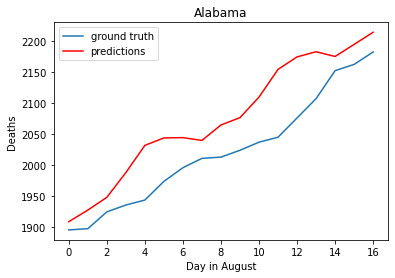

Date: 2020-09-01 00:00:00, predicted=2194.110899
Date: 2020-09-02 00:00:00, predicted=2191.651301
Date: 2020-09-03 00:00:00, predicted=2213.441828
Date: 2020-09-04 00:00:00, predicted=2237.251060
Date: 2020-09-05 00:00:00, predicted=2282.703413
Date: 2020-09-06 00:00:00, predicted=2302.979287
Date: 2020-09-07 00:00:00, predicted=2311.290910
Date: 2020-09-08 00:00:00, predicted=2325.633931
Date: 2020-09-09 00:00:00, predicted=2347.472243
Date: 2020-09-10 00:00:00, predicted=2367.935781
Date: 2020-09-11 00:00:00, predicted=2377.036304
Date: 2020-09-12 00:00:00, predicted=2399.424837
Date: 2020-09-13 00:00:00, predicted=2418.382756
Date: 2020-09-14 00:00:00, predicted=2435.753704
Date: 2020-09-15 00:00:00, predicted=2467.676723
Date: 2020-09-16 00:00:00, predicted=2496.052361
Date: 2020-09-17 00:00:00, predicted=2512.298084
Date: 2020-09-18 00:00:00, predicted=2530.512678
Date: 2020-09-19 00:00:00, predicted=2558.297895
Date: 2020-09-20 00:00:00, predicted=2571.711290
Date: 2020-09-21 00:

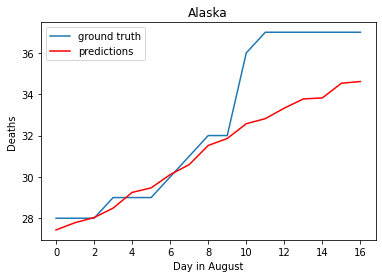

Date: 2020-09-01 00:00:00, predicted=37.819526
Date: 2020-09-02 00:00:00, predicted=38.301592
Date: 2020-09-03 00:00:00, predicted=38.900039
Date: 2020-09-04 00:00:00, predicted=39.142432
Date: 2020-09-05 00:00:00, predicted=39.702332
Date: 2020-09-06 00:00:00, predicted=40.242047
Date: 2020-09-07 00:00:00, predicted=39.899685
Date: 2020-09-08 00:00:00, predicted=40.882501
Date: 2020-09-09 00:00:00, predicted=41.051692
Date: 2020-09-10 00:00:00, predicted=40.937616
Date: 2020-09-11 00:00:00, predicted=41.535402
Date: 2020-09-12 00:00:00, predicted=42.404921
Date: 2020-09-13 00:00:00, predicted=42.963683
Date: 2020-09-14 00:00:00, predicted=42.661479
Date: 2020-09-15 00:00:00, predicted=44.004260
Date: 2020-09-16 00:00:00, predicted=45.597603
Date: 2020-09-17 00:00:00, predicted=45.988718
Date: 2020-09-18 00:00:00, predicted=47.464674
Date: 2020-09-19 00:00:00, predicted=48.441900
Date: 2020-09-20 00:00:00, predicted=49.187471
Date: 2020-09-21 00:00:00, predicted=49.676305
Date: 2020-09

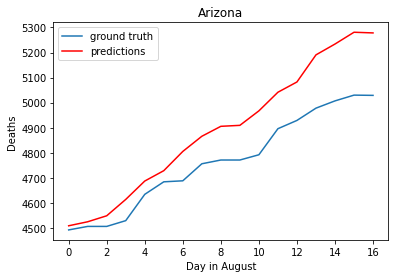

Date: 2020-09-01 00:00:00, predicted=5050.169255
Date: 2020-09-02 00:00:00, predicted=5142.244709
Date: 2020-09-03 00:00:00, predicted=5167.790211
Date: 2020-09-04 00:00:00, predicted=5228.227296
Date: 2020-09-05 00:00:00, predicted=5270.314821
Date: 2020-09-06 00:00:00, predicted=5292.690058
Date: 2020-09-07 00:00:00, predicted=5281.043207
Date: 2020-09-08 00:00:00, predicted=5313.633524
Date: 2020-09-09 00:00:00, predicted=5408.889893
Date: 2020-09-10 00:00:00, predicted=5475.347929
Date: 2020-09-11 00:00:00, predicted=5487.134820
Date: 2020-09-12 00:00:00, predicted=5533.046315
Date: 2020-09-13 00:00:00, predicted=5577.891352
Date: 2020-09-14 00:00:00, predicted=5562.485613
Date: 2020-09-15 00:00:00, predicted=5585.440582
Date: 2020-09-16 00:00:00, predicted=5664.220884
Date: 2020-09-17 00:00:00, predicted=5744.843978
Date: 2020-09-18 00:00:00, predicted=5771.236968
Date: 2020-09-19 00:00:00, predicted=5793.191658
Date: 2020-09-20 00:00:00, predicted=5846.672949
Date: 2020-09-21 00:

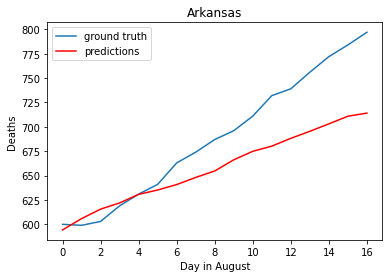

Date: 2020-09-01 00:00:00, predicted=811.007998
Date: 2020-09-02 00:00:00, predicted=825.602105
Date: 2020-09-03 00:00:00, predicted=835.643475
Date: 2020-09-04 00:00:00, predicted=845.789268
Date: 2020-09-05 00:00:00, predicted=858.699079
Date: 2020-09-06 00:00:00, predicted=871.989441
Date: 2020-09-07 00:00:00, predicted=882.597323
Date: 2020-09-08 00:00:00, predicted=900.096980
Date: 2020-09-09 00:00:00, predicted=911.466773
Date: 2020-09-10 00:00:00, predicted=921.111394
Date: 2020-09-11 00:00:00, predicted=934.872537
Date: 2020-09-12 00:00:00, predicted=952.101428
Date: 2020-09-13 00:00:00, predicted=966.638440
Date: 2020-09-14 00:00:00, predicted=975.455777
Date: 2020-09-15 00:00:00, predicted=993.268426
Date: 2020-09-16 00:00:00, predicted=1007.222966
Date: 2020-09-17 00:00:00, predicted=1022.768062
Date: 2020-09-18 00:00:00, predicted=1036.184800
Date: 2020-09-19 00:00:00, predicted=1054.083098
Date: 2020-09-20 00:00:00, predicted=1066.517544
Date: 2020-09-21 00:00:00, predicte

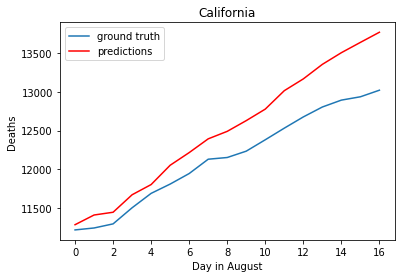

Date: 2020-09-01 00:00:00, predicted=13121.019514
Date: 2020-09-02 00:00:00, predicted=13238.579295
Date: 2020-09-03 00:00:00, predicted=13320.620785
Date: 2020-09-04 00:00:00, predicted=13503.601191
Date: 2020-09-05 00:00:00, predicted=13608.947731
Date: 2020-09-06 00:00:00, predicted=13592.696026
Date: 2020-09-07 00:00:00, predicted=13619.256912
Date: 2020-09-08 00:00:00, predicted=13758.699962
Date: 2020-09-09 00:00:00, predicted=13909.728187
Date: 2020-09-10 00:00:00, predicted=14017.313824
Date: 2020-09-11 00:00:00, predicted=14098.306975
Date: 2020-09-12 00:00:00, predicted=14203.676121
Date: 2020-09-13 00:00:00, predicted=14212.359755
Date: 2020-09-14 00:00:00, predicted=14281.174253
Date: 2020-09-15 00:00:00, predicted=14383.937547
Date: 2020-09-16 00:00:00, predicted=14498.515699
Date: 2020-09-17 00:00:00, predicted=14609.001055
Date: 2020-09-18 00:00:00, predicted=14741.144628
Date: 2020-09-19 00:00:00, predicted=14775.717496
Date: 2020-09-20 00:00:00, predicted=14781.377968


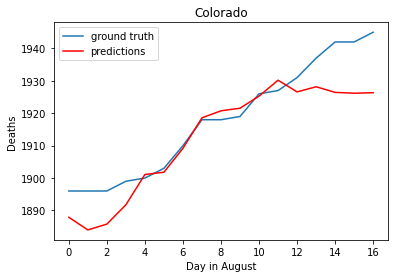

Date: 2020-09-01 00:00:00, predicted=1953.577130
Date: 2020-09-02 00:00:00, predicted=1958.433656
Date: 2020-09-03 00:00:00, predicted=1961.930515
Date: 2020-09-04 00:00:00, predicted=1969.538210
Date: 2020-09-05 00:00:00, predicted=1974.947896
Date: 2020-09-06 00:00:00, predicted=1981.001888
Date: 2020-09-07 00:00:00, predicted=1975.659626
Date: 2020-09-08 00:00:00, predicted=1982.725419
Date: 2020-09-09 00:00:00, predicted=1982.040514
Date: 2020-09-10 00:00:00, predicted=1983.998823
Date: 2020-09-11 00:00:00, predicted=1988.976804
Date: 2020-09-12 00:00:00, predicted=1995.809022
Date: 2020-09-13 00:00:00, predicted=1998.811434
Date: 2020-09-14 00:00:00, predicted=1998.118158
Date: 2020-09-15 00:00:00, predicted=2004.628927
Date: 2020-09-16 00:00:00, predicted=2008.788995
Date: 2020-09-17 00:00:00, predicted=2012.630902
Date: 2020-09-18 00:00:00, predicted=2018.731343
Date: 2020-09-19 00:00:00, predicted=2024.218557
Date: 2020-09-20 00:00:00, predicted=2025.131964
Date: 2020-09-21 00:

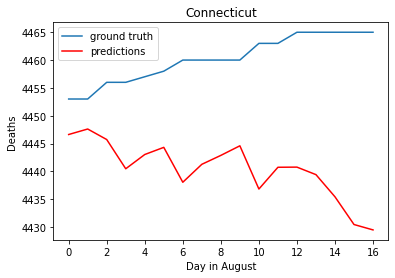

Date: 2020-09-01 00:00:00, predicted=4462.565738
Date: 2020-09-02 00:00:00, predicted=4464.113766
Date: 2020-09-03 00:00:00, predicted=4465.044051
Date: 2020-09-04 00:00:00, predicted=4467.734279
Date: 2020-09-05 00:00:00, predicted=4463.324333
Date: 2020-09-06 00:00:00, predicted=4468.370575
Date: 2020-09-07 00:00:00, predicted=4465.275453
Date: 2020-09-08 00:00:00, predicted=4468.471019
Date: 2020-09-09 00:00:00, predicted=4467.039719
Date: 2020-09-10 00:00:00, predicted=4466.901621
Date: 2020-09-11 00:00:00, predicted=4468.579819
Date: 2020-09-12 00:00:00, predicted=4465.878390
Date: 2020-09-13 00:00:00, predicted=4468.393234
Date: 2020-09-14 00:00:00, predicted=4464.708162
Date: 2020-09-15 00:00:00, predicted=4463.322305
Date: 2020-09-16 00:00:00, predicted=4464.516418
Date: 2020-09-17 00:00:00, predicted=4463.495525
Date: 2020-09-18 00:00:00, predicted=4466.504357
Date: 2020-09-19 00:00:00, predicted=4463.228125
Date: 2020-09-20 00:00:00, predicted=4464.230852
Date: 2020-09-21 00:

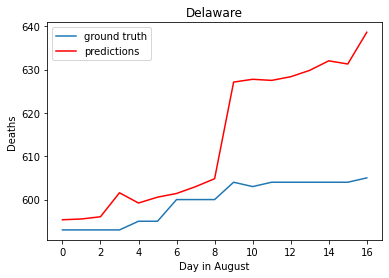

Date: 2020-09-01 00:00:00, predicted=608.108651
Date: 2020-09-02 00:00:00, predicted=610.209900
Date: 2020-09-03 00:00:00, predicted=611.050419
Date: 2020-09-04 00:00:00, predicted=615.898903
Date: 2020-09-05 00:00:00, predicted=614.773792
Date: 2020-09-06 00:00:00, predicted=608.945890
Date: 2020-09-07 00:00:00, predicted=608.720749
Date: 2020-09-08 00:00:00, predicted=609.420268
Date: 2020-09-09 00:00:00, predicted=611.153541
Date: 2020-09-10 00:00:00, predicted=610.777701
Date: 2020-09-11 00:00:00, predicted=610.853088
Date: 2020-09-12 00:00:00, predicted=611.375994
Date: 2020-09-13 00:00:00, predicted=611.360033
Date: 2020-09-14 00:00:00, predicted=612.068411
Date: 2020-09-15 00:00:00, predicted=613.006526
Date: 2020-09-16 00:00:00, predicted=613.187308
Date: 2020-09-17 00:00:00, predicted=614.248179
Date: 2020-09-18 00:00:00, predicted=615.447999
Date: 2020-09-19 00:00:00, predicted=615.522577
Date: 2020-09-20 00:00:00, predicted=615.595795
Date: 2020-09-21 00:00:00, predicted=617

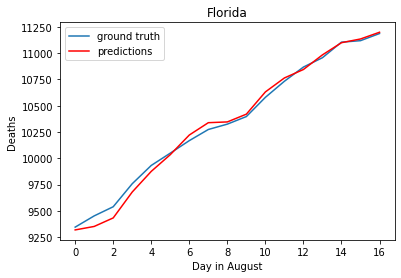

Date: 2020-09-01 00:00:00, predicted=11310.901617
Date: 2020-09-02 00:00:00, predicted=11398.253663
Date: 2020-09-03 00:00:00, predicted=11461.633816
Date: 2020-09-04 00:00:00, predicted=11513.137290
Date: 2020-09-05 00:00:00, predicted=11584.659244
Date: 2020-09-06 00:00:00, predicted=11548.369739
Date: 2020-09-07 00:00:00, predicted=11568.647342
Date: 2020-09-08 00:00:00, predicted=11642.604358
Date: 2020-09-09 00:00:00, predicted=11709.627237
Date: 2020-09-10 00:00:00, predicted=11753.506130
Date: 2020-09-11 00:00:00, predicted=11799.314380
Date: 2020-09-12 00:00:00, predicted=11828.706269
Date: 2020-09-13 00:00:00, predicted=11792.238147
Date: 2020-09-14 00:00:00, predicted=11794.159807
Date: 2020-09-15 00:00:00, predicted=11847.335789
Date: 2020-09-16 00:00:00, predicted=11888.750240
Date: 2020-09-17 00:00:00, predicted=11910.566320
Date: 2020-09-18 00:00:00, predicted=11906.634796
Date: 2020-09-19 00:00:00, predicted=11905.103588
Date: 2020-09-20 00:00:00, predicted=11871.292193


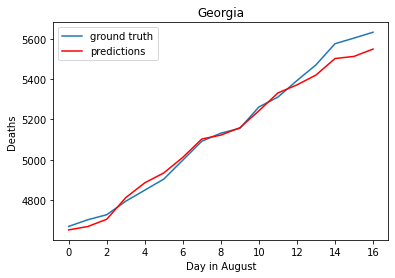

Date: 2020-09-01 00:00:00, predicted=5725.240120
Date: 2020-09-02 00:00:00, predicted=5799.371206
Date: 2020-09-03 00:00:00, predicted=5851.066474
Date: 2020-09-04 00:00:00, predicted=5961.172172
Date: 2020-09-05 00:00:00, predicted=6034.424058
Date: 2020-09-06 00:00:00, predicted=6059.100786
Date: 2020-09-07 00:00:00, predicted=6099.335163
Date: 2020-09-08 00:00:00, predicted=6158.455987
Date: 2020-09-09 00:00:00, predicted=6224.924412
Date: 2020-09-10 00:00:00, predicted=6289.039029
Date: 2020-09-11 00:00:00, predicted=6393.210285
Date: 2020-09-12 00:00:00, predicted=6477.598565
Date: 2020-09-13 00:00:00, predicted=6518.236401
Date: 2020-09-14 00:00:00, predicted=6541.417193
Date: 2020-09-15 00:00:00, predicted=6598.771110
Date: 2020-09-16 00:00:00, predicted=6681.123821
Date: 2020-09-17 00:00:00, predicted=6734.594065
Date: 2020-09-18 00:00:00, predicted=6820.844125
Date: 2020-09-19 00:00:00, predicted=6878.774544
Date: 2020-09-20 00:00:00, predicted=6913.649021
Date: 2020-09-21 00:

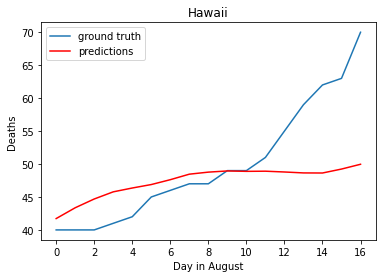

Date: 2020-09-01 00:00:00, predicted=73.207233
Date: 2020-09-02 00:00:00, predicted=75.948344
Date: 2020-09-03 00:00:00, predicted=80.875446
Date: 2020-09-04 00:00:00, predicted=84.224290
Date: 2020-09-05 00:00:00, predicted=87.432785
Date: 2020-09-06 00:00:00, predicted=91.609656
Date: 2020-09-07 00:00:00, predicted=95.695416
Date: 2020-09-08 00:00:00, predicted=98.523473
Date: 2020-09-09 00:00:00, predicted=101.840437
Date: 2020-09-10 00:00:00, predicted=104.486103
Date: 2020-09-11 00:00:00, predicted=107.960275
Date: 2020-09-12 00:00:00, predicted=110.607081
Date: 2020-09-13 00:00:00, predicted=112.195264
Date: 2020-09-14 00:00:00, predicted=116.341901
Date: 2020-09-15 00:00:00, predicted=119.588154
Date: 2020-09-16 00:00:00, predicted=122.387921
Date: 2020-09-17 00:00:00, predicted=126.855082
Date: 2020-09-18 00:00:00, predicted=130.509523
Date: 2020-09-19 00:00:00, predicted=135.224452
Date: 2020-09-20 00:00:00, predicted=138.104654
Date: 2020-09-21 00:00:00, predicted=144.806379


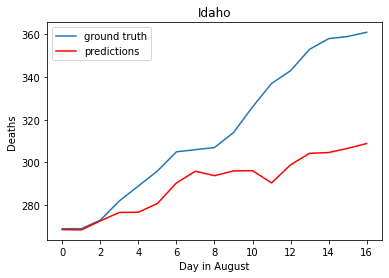

Date: 2020-09-01 00:00:00, predicted=367.081795
Date: 2020-09-02 00:00:00, predicted=377.546240
Date: 2020-09-03 00:00:00, predicted=383.932388
Date: 2020-09-04 00:00:00, predicted=391.226238
Date: 2020-09-05 00:00:00, predicted=393.165304
Date: 2020-09-06 00:00:00, predicted=393.538853
Date: 2020-09-07 00:00:00, predicted=398.233294
Date: 2020-09-08 00:00:00, predicted=404.077272
Date: 2020-09-09 00:00:00, predicted=408.928247
Date: 2020-09-10 00:00:00, predicted=410.786686
Date: 2020-09-11 00:00:00, predicted=419.340406
Date: 2020-09-12 00:00:00, predicted=427.265195
Date: 2020-09-13 00:00:00, predicted=428.360100
Date: 2020-09-14 00:00:00, predicted=430.167357
Date: 2020-09-15 00:00:00, predicted=437.298381
Date: 2020-09-16 00:00:00, predicted=443.072730
Date: 2020-09-17 00:00:00, predicted=448.115837
Date: 2020-09-18 00:00:00, predicted=455.522972
Date: 2020-09-19 00:00:00, predicted=460.156204
Date: 2020-09-20 00:00:00, predicted=460.226052
Date: 2020-09-21 00:00:00, predicted=461

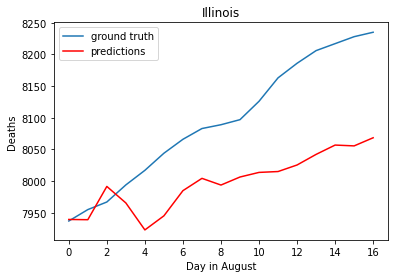

Date: 2020-09-01 00:00:00, predicted=8252.600538
Date: 2020-09-02 00:00:00, predicted=8279.773725
Date: 2020-09-03 00:00:00, predicted=8302.505096
Date: 2020-09-04 00:00:00, predicted=8324.198700
Date: 2020-09-05 00:00:00, predicted=8335.424070
Date: 2020-09-06 00:00:00, predicted=8344.880521
Date: 2020-09-07 00:00:00, predicted=8357.250273
Date: 2020-09-08 00:00:00, predicted=8373.687784
Date: 2020-09-09 00:00:00, predicted=8398.241819
Date: 2020-09-10 00:00:00, predicted=8420.333810
Date: 2020-09-11 00:00:00, predicted=8440.813000
Date: 2020-09-12 00:00:00, predicted=8449.898435
Date: 2020-09-13 00:00:00, predicted=8458.516301
Date: 2020-09-14 00:00:00, predicted=8469.312450
Date: 2020-09-15 00:00:00, predicted=8488.237235
Date: 2020-09-16 00:00:00, predicted=8512.308621
Date: 2020-09-17 00:00:00, predicted=8533.012750
Date: 2020-09-18 00:00:00, predicted=8548.361789
Date: 2020-09-19 00:00:00, predicted=8554.892478
Date: 2020-09-20 00:00:00, predicted=8563.518379
Date: 2020-09-21 00:

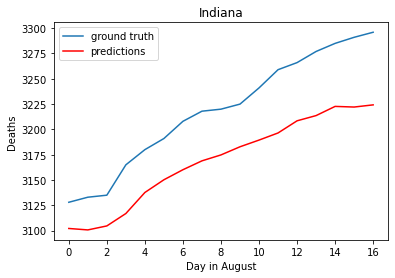

Date: 2020-09-01 00:00:00, predicted=3310.526832
Date: 2020-09-02 00:00:00, predicted=3315.564951
Date: 2020-09-03 00:00:00, predicted=3317.973669
Date: 2020-09-04 00:00:00, predicted=3328.891269
Date: 2020-09-05 00:00:00, predicted=3338.614567
Date: 2020-09-06 00:00:00, predicted=3329.425654
Date: 2020-09-07 00:00:00, predicted=3320.989715
Date: 2020-09-08 00:00:00, predicted=3329.867675
Date: 2020-09-09 00:00:00, predicted=3336.708177
Date: 2020-09-10 00:00:00, predicted=3342.185146
Date: 2020-09-11 00:00:00, predicted=3348.041642
Date: 2020-09-12 00:00:00, predicted=3345.286214
Date: 2020-09-13 00:00:00, predicted=3338.715197
Date: 2020-09-14 00:00:00, predicted=3337.113408
Date: 2020-09-15 00:00:00, predicted=3340.679867
Date: 2020-09-16 00:00:00, predicted=3341.595838
Date: 2020-09-17 00:00:00, predicted=3342.579594
Date: 2020-09-18 00:00:00, predicted=3345.051871
Date: 2020-09-19 00:00:00, predicted=3345.861414
Date: 2020-09-20 00:00:00, predicted=3342.828276
Date: 2020-09-21 00:

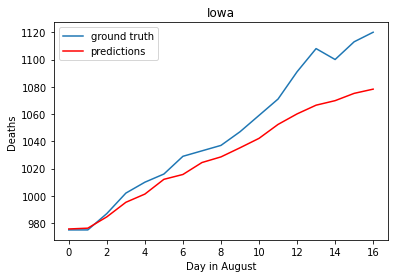

Date: 2020-09-01 00:00:00, predicted=1126.325113
Date: 2020-09-02 00:00:00, predicted=1143.446271
Date: 2020-09-03 00:00:00, predicted=1161.363392
Date: 2020-09-04 00:00:00, predicted=1169.322803
Date: 2020-09-05 00:00:00, predicted=1175.153080
Date: 2020-09-06 00:00:00, predicted=1186.384140
Date: 2020-09-07 00:00:00, predicted=1193.462484
Date: 2020-09-08 00:00:00, predicted=1202.291578
Date: 2020-09-09 00:00:00, predicted=1219.312514
Date: 2020-09-10 00:00:00, predicted=1230.230972
Date: 2020-09-11 00:00:00, predicted=1243.214131
Date: 2020-09-12 00:00:00, predicted=1253.208111
Date: 2020-09-13 00:00:00, predicted=1258.659643
Date: 2020-09-14 00:00:00, predicted=1266.477844
Date: 2020-09-15 00:00:00, predicted=1279.639278
Date: 2020-09-16 00:00:00, predicted=1295.148288
Date: 2020-09-17 00:00:00, predicted=1303.323703
Date: 2020-09-18 00:00:00, predicted=1314.116499
Date: 2020-09-19 00:00:00, predicted=1324.786227
Date: 2020-09-20 00:00:00, predicted=1328.868067
Date: 2020-09-21 00:

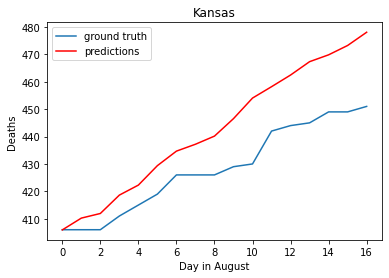

Date: 2020-09-01 00:00:00, predicted=451.539524
Date: 2020-09-02 00:00:00, predicted=456.875125
Date: 2020-09-03 00:00:00, predicted=463.743714
Date: 2020-09-04 00:00:00, predicted=464.183454
Date: 2020-09-05 00:00:00, predicted=465.848507
Date: 2020-09-06 00:00:00, predicted=464.438794
Date: 2020-09-07 00:00:00, predicted=466.530299
Date: 2020-09-08 00:00:00, predicted=470.037428
Date: 2020-09-09 00:00:00, predicted=472.555158
Date: 2020-09-10 00:00:00, predicted=477.753549
Date: 2020-09-11 00:00:00, predicted=481.919587
Date: 2020-09-12 00:00:00, predicted=483.161157
Date: 2020-09-13 00:00:00, predicted=485.616192
Date: 2020-09-14 00:00:00, predicted=485.393182
Date: 2020-09-15 00:00:00, predicted=486.354446
Date: 2020-09-16 00:00:00, predicted=490.136362
Date: 2020-09-17 00:00:00, predicted=493.838142
Date: 2020-09-18 00:00:00, predicted=497.983472
Date: 2020-09-19 00:00:00, predicted=498.347628
Date: 2020-09-20 00:00:00, predicted=499.141812
Date: 2020-09-21 00:00:00, predicted=501

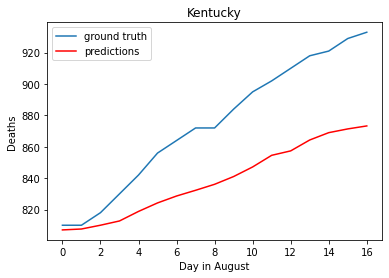

Date: 2020-09-01 00:00:00, predicted=940.094726
Date: 2020-09-02 00:00:00, predicted=951.119374
Date: 2020-09-03 00:00:00, predicted=957.547562
Date: 2020-09-04 00:00:00, predicted=967.691373
Date: 2020-09-05 00:00:00, predicted=974.389803
Date: 2020-09-06 00:00:00, predicted=978.117335
Date: 2020-09-07 00:00:00, predicted=985.333478
Date: 2020-09-08 00:00:00, predicted=992.566241
Date: 2020-09-09 00:00:00, predicted=1001.388537
Date: 2020-09-10 00:00:00, predicted=1007.298257
Date: 2020-09-11 00:00:00, predicted=1013.982162
Date: 2020-09-12 00:00:00, predicted=1018.932282
Date: 2020-09-13 00:00:00, predicted=1023.901848
Date: 2020-09-14 00:00:00, predicted=1030.184421
Date: 2020-09-15 00:00:00, predicted=1039.495721
Date: 2020-09-16 00:00:00, predicted=1048.147105
Date: 2020-09-17 00:00:00, predicted=1056.225508
Date: 2020-09-18 00:00:00, predicted=1064.025478
Date: 2020-09-19 00:00:00, predicted=1070.909076
Date: 2020-09-20 00:00:00, predicted=1077.715825
Date: 2020-09-21 00:00:00, p

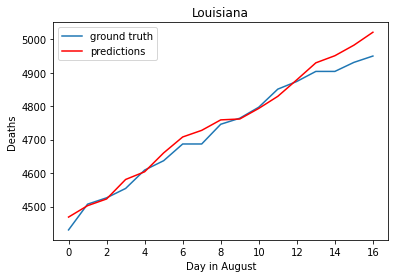

Date: 2020-09-01 00:00:00, predicted=4985.202633
Date: 2020-09-02 00:00:00, predicted=5015.046077
Date: 2020-09-03 00:00:00, predicted=5047.620741
Date: 2020-09-04 00:00:00, predicted=5088.167748
Date: 2020-09-05 00:00:00, predicted=5110.616751
Date: 2020-09-06 00:00:00, predicted=5140.303518
Date: 2020-09-07 00:00:00, predicted=5145.738834
Date: 2020-09-08 00:00:00, predicted=5184.624802
Date: 2020-09-09 00:00:00, predicted=5212.654655
Date: 2020-09-10 00:00:00, predicted=5238.120463
Date: 2020-09-11 00:00:00, predicted=5275.883781
Date: 2020-09-12 00:00:00, predicted=5274.878245
Date: 2020-09-13 00:00:00, predicted=5297.440812
Date: 2020-09-14 00:00:00, predicted=5312.622362
Date: 2020-09-15 00:00:00, predicted=5342.634374
Date: 2020-09-16 00:00:00, predicted=5366.063252
Date: 2020-09-17 00:00:00, predicted=5390.167214
Date: 2020-09-18 00:00:00, predicted=5425.617720
Date: 2020-09-19 00:00:00, predicted=5437.318251
Date: 2020-09-20 00:00:00, predicted=5457.081990
Date: 2020-09-21 00:

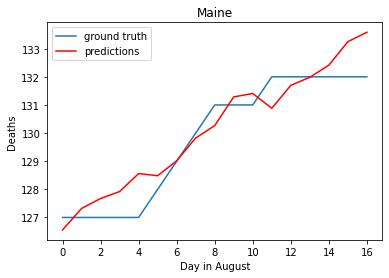

Date: 2020-09-01 00:00:00, predicted=132.114518
Date: 2020-09-02 00:00:00, predicted=132.471929
Date: 2020-09-03 00:00:00, predicted=133.430688
Date: 2020-09-04 00:00:00, predicted=133.332495
Date: 2020-09-05 00:00:00, predicted=133.448768
Date: 2020-09-06 00:00:00, predicted=133.694180
Date: 2020-09-07 00:00:00, predicted=133.096527
Date: 2020-09-08 00:00:00, predicted=133.203780
Date: 2020-09-09 00:00:00, predicted=134.190837
Date: 2020-09-10 00:00:00, predicted=133.774069
Date: 2020-09-11 00:00:00, predicted=134.349829
Date: 2020-09-12 00:00:00, predicted=134.651159
Date: 2020-09-13 00:00:00, predicted=134.495805
Date: 2020-09-14 00:00:00, predicted=135.225566
Date: 2020-09-15 00:00:00, predicted=135.352329
Date: 2020-09-16 00:00:00, predicted=135.629835
Date: 2020-09-17 00:00:00, predicted=136.474369
Date: 2020-09-18 00:00:00, predicted=136.226749
Date: 2020-09-19 00:00:00, predicted=136.204133
Date: 2020-09-20 00:00:00, predicted=136.476032
Date: 2020-09-21 00:00:00, predicted=136

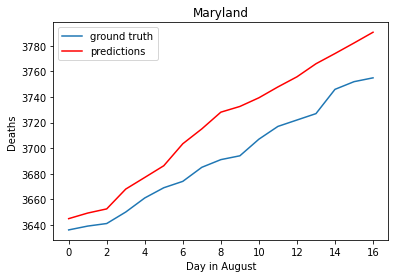

Date: 2020-09-01 00:00:00, predicted=3764.026385
Date: 2020-09-02 00:00:00, predicted=3771.998123
Date: 2020-09-03 00:00:00, predicted=3779.092450
Date: 2020-09-04 00:00:00, predicted=3780.641438
Date: 2020-09-05 00:00:00, predicted=9311373752.907597
Date: 2020-09-06 00:00:00, predicted=9311373752.907597
Date: 2020-09-07 00:00:00, predicted=9311373752.907597
Date: 2020-09-08 00:00:00, predicted=9311373752.907597
Date: 2020-09-09 00:00:00, predicted=9311373752.907597
Date: 2020-09-10 00:00:00, predicted=9311373752.907597
Date: 2020-09-11 00:00:00, predicted=9311373752.907597
Date: 2020-09-12 00:00:00, predicted=9311373752.907597
Date: 2020-09-13 00:00:00, predicted=9311373752.907597
Date: 2020-09-14 00:00:00, predicted=9311373752.907597
Date: 2020-09-15 00:00:00, predicted=9311373752.907597
Date: 2020-09-16 00:00:00, predicted=9311373752.907597
Date: 2020-09-17 00:00:00, predicted=9311373752.907597
Date: 2020-09-18 00:00:00, predicted=9311373752.907597
Date: 2020-09-19 00:00:00, predict

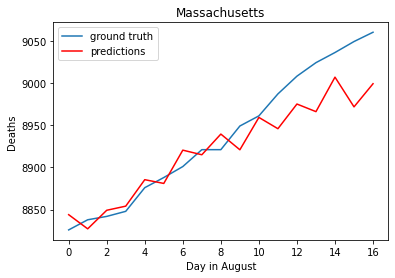

Date: 2020-09-01 00:00:00, predicted=9084.936147
Date: 2020-09-02 00:00:00, predicted=9098.613874
Date: 2020-09-03 00:00:00, predicted=9126.808027
Date: 2020-09-04 00:00:00, predicted=9139.524174
Date: 2020-09-05 00:00:00, predicted=9154.553535
Date: 2020-09-06 00:00:00, predicted=9159.317054
Date: 2020-09-07 00:00:00, predicted=9185.674804
Date: 2020-09-08 00:00:00, predicted=9202.262113
Date: 2020-09-09 00:00:00, predicted=9219.263207
Date: 2020-09-10 00:00:00, predicted=9250.954775
Date: 2020-09-11 00:00:00, predicted=9258.669154
Date: 2020-09-12 00:00:00, predicted=9267.055969
Date: 2020-09-13 00:00:00, predicted=9281.236170
Date: 2020-09-14 00:00:00, predicted=9293.350506
Date: 2020-09-15 00:00:00, predicted=9311.355360
Date: 2020-09-16 00:00:00, predicted=9329.198748
Date: 2020-09-17 00:00:00, predicted=9346.910381
Date: 2020-09-18 00:00:00, predicted=9356.254134
Date: 2020-09-19 00:00:00, predicted=9377.605995
Date: 2020-09-20 00:00:00, predicted=9376.822084
Date: 2020-09-21 00:

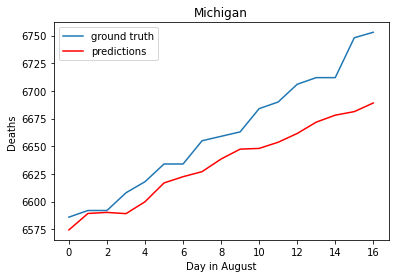

Date: 2020-09-01 00:00:00, predicted=6758.672896
Date: 2020-09-02 00:00:00, predicted=6770.773273
Date: 2020-09-03 00:00:00, predicted=6785.679699
Date: 2020-09-04 00:00:00, predicted=6806.763873
Date: 2020-09-05 00:00:00, predicted=6815.946954
Date: 2020-09-06 00:00:00, predicted=6825.711977
Date: 2020-09-07 00:00:00, predicted=6826.118636
Date: 2020-09-08 00:00:00, predicted=6848.576844
Date: 2020-09-09 00:00:00, predicted=6863.492536
Date: 2020-09-10 00:00:00, predicted=6875.159975
Date: 2020-09-11 00:00:00, predicted=6896.221863
Date: 2020-09-12 00:00:00, predicted=6909.028310
Date: 2020-09-13 00:00:00, predicted=6918.616660
Date: 2020-09-14 00:00:00, predicted=6930.600413
Date: 2020-09-15 00:00:00, predicted=6939.460873
Date: 2020-09-16 00:00:00, predicted=6962.125250
Date: 2020-09-17 00:00:00, predicted=6963.447582
Date: 2020-09-18 00:00:00, predicted=6980.805291
Date: 2020-09-19 00:00:00, predicted=7003.430736
Date: 2020-09-20 00:00:00, predicted=7012.511691
Date: 2020-09-21 00:

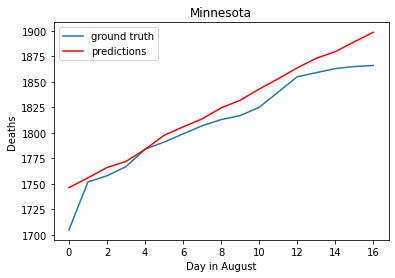

Date: 2020-09-01 00:00:00, predicted=1888.836210
Date: 2020-09-02 00:00:00, predicted=1890.661766
Date: 2020-09-03 00:00:00, predicted=1892.279972
Date: 2020-09-04 00:00:00, predicted=1905.279439
Date: 2020-09-05 00:00:00, predicted=1901.303325
Date: 2020-09-06 00:00:00, predicted=1911.569521
Date: 2020-09-07 00:00:00, predicted=1914.037500
Date: 2020-09-08 00:00:00, predicted=1913.579023
Date: 2020-09-09 00:00:00, predicted=1921.752487
Date: 2020-09-10 00:00:00, predicted=1933.542748
Date: 2020-09-11 00:00:00, predicted=1930.800071
Date: 2020-09-12 00:00:00, predicted=1930.852684
Date: 2020-09-13 00:00:00, predicted=1935.415218
Date: 2020-09-14 00:00:00, predicted=1933.289086
Date: 2020-09-15 00:00:00, predicted=1938.580762
Date: 2020-09-16 00:00:00, predicted=1944.152699
Date: 2020-09-17 00:00:00, predicted=1944.490106
Date: 2020-09-18 00:00:00, predicted=1944.484774
Date: 2020-09-19 00:00:00, predicted=1941.413857
Date: 2020-09-20 00:00:00, predicted=1949.945113
Date: 2020-09-21 00:

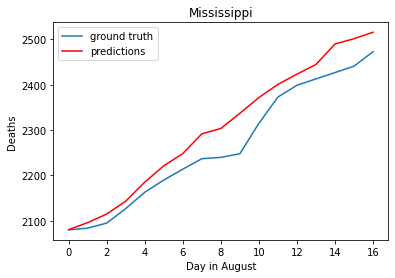

Date: 2020-09-01 00:00:00, predicted=2522.915085
Date: 2020-09-02 00:00:00, predicted=2565.542834
Date: 2020-09-03 00:00:00, predicted=2579.909512
Date: 2020-09-04 00:00:00, predicted=2605.771885
Date: 2020-09-05 00:00:00, predicted=2629.024940
Date: 2020-09-06 00:00:00, predicted=2645.980438
Date: 2020-09-07 00:00:00, predicted=2661.349297
Date: 2020-09-08 00:00:00, predicted=2707.705478
Date: 2020-09-09 00:00:00, predicted=2758.511457
Date: 2020-09-10 00:00:00, predicted=2787.051175
Date: 2020-09-11 00:00:00, predicted=2796.107855
Date: 2020-09-12 00:00:00, predicted=2815.688992
Date: 2020-09-13 00:00:00, predicted=2823.426565
Date: 2020-09-14 00:00:00, predicted=2845.549408
Date: 2020-09-15 00:00:00, predicted=2897.009965
Date: 2020-09-16 00:00:00, predicted=2943.067601
Date: 2020-09-17 00:00:00, predicted=2964.169664
Date: 2020-09-18 00:00:00, predicted=2978.787384
Date: 2020-09-19 00:00:00, predicted=3004.324423
Date: 2020-09-20 00:00:00, predicted=3022.218728
Date: 2020-09-21 00:

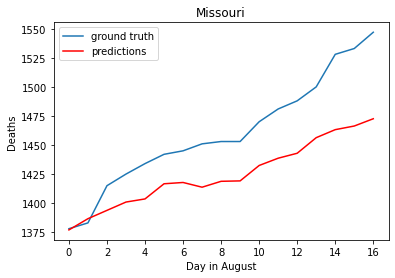

Date: 2020-09-01 00:00:00, predicted=1556.294177
Date: 2020-09-02 00:00:00, predicted=1558.775670
Date: 2020-09-03 00:00:00, predicted=1572.374285
Date: 2020-09-04 00:00:00, predicted=1581.066565
Date: 2020-09-05 00:00:00, predicted=1592.807568
Date: 2020-09-06 00:00:00, predicted=1600.785079
Date: 2020-09-07 00:00:00, predicted=1618.781357
Date: 2020-09-08 00:00:00, predicted=1633.515289
Date: 2020-09-09 00:00:00, predicted=1647.006970
Date: 2020-09-10 00:00:00, predicted=1653.259727
Date: 2020-09-11 00:00:00, predicted=1667.655948
Date: 2020-09-12 00:00:00, predicted=1671.430049
Date: 2020-09-13 00:00:00, predicted=1676.665700
Date: 2020-09-14 00:00:00, predicted=1683.401300
Date: 2020-09-15 00:00:00, predicted=1690.953065
Date: 2020-09-16 00:00:00, predicted=1699.459866
Date: 2020-09-17 00:00:00, predicted=1709.423131
Date: 2020-09-18 00:00:00, predicted=1716.761015
Date: 2020-09-19 00:00:00, predicted=1740.475851
Date: 2020-09-20 00:00:00, predicted=1751.716473
Date: 2020-09-21 00:

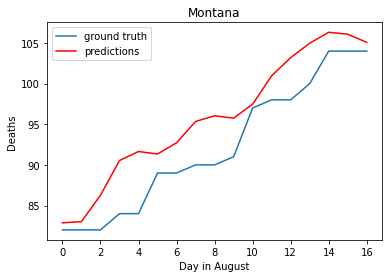

Date: 2020-09-01 00:00:00, predicted=104.541970
Date: 2020-09-02 00:00:00, predicted=106.512226
Date: 2020-09-03 00:00:00, predicted=107.281328
Date: 2020-09-04 00:00:00, predicted=108.609266
Date: 2020-09-05 00:00:00, predicted=109.923549
Date: 2020-09-06 00:00:00, predicted=111.657122
Date: 2020-09-07 00:00:00, predicted=112.648462
Date: 2020-09-08 00:00:00, predicted=112.182939
Date: 2020-09-09 00:00:00, predicted=114.144915
Date: 2020-09-10 00:00:00, predicted=115.593468
Date: 2020-09-11 00:00:00, predicted=117.998462
Date: 2020-09-12 00:00:00, predicted=119.377748
Date: 2020-09-13 00:00:00, predicted=117.742497
Date: 2020-09-14 00:00:00, predicted=118.966836
Date: 2020-09-15 00:00:00, predicted=121.266917
Date: 2020-09-16 00:00:00, predicted=123.106914
Date: 2020-09-17 00:00:00, predicted=123.645419
Date: 2020-09-18 00:00:00, predicted=124.959232
Date: 2020-09-19 00:00:00, predicted=126.907158
Date: 2020-09-20 00:00:00, predicted=128.152316
Date: 2020-09-21 00:00:00, predicted=128

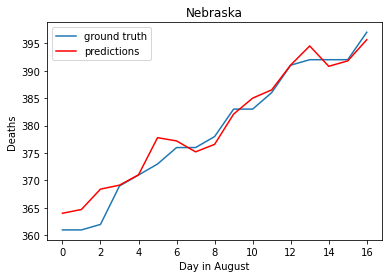

Date: 2020-09-01 00:00:00, predicted=398.117390
Date: 2020-09-02 00:00:00, predicted=400.983561
Date: 2020-09-03 00:00:00, predicted=406.002497
Date: 2020-09-04 00:00:00, predicted=407.402626
Date: 2020-09-05 00:00:00, predicted=408.804998
Date: 2020-09-06 00:00:00, predicted=410.377919
Date: 2020-09-07 00:00:00, predicted=411.313636
Date: 2020-09-08 00:00:00, predicted=414.550045
Date: 2020-09-09 00:00:00, predicted=418.463451
Date: 2020-09-10 00:00:00, predicted=420.752706
Date: 2020-09-11 00:00:00, predicted=422.169019
Date: 2020-09-12 00:00:00, predicted=423.628839
Date: 2020-09-13 00:00:00, predicted=425.526367
Date: 2020-09-14 00:00:00, predicted=425.833683
Date: 2020-09-15 00:00:00, predicted=429.764703
Date: 2020-09-16 00:00:00, predicted=433.321994
Date: 2020-09-17 00:00:00, predicted=435.787548
Date: 2020-09-18 00:00:00, predicted=437.866322
Date: 2020-09-19 00:00:00, predicted=439.232186
Date: 2020-09-20 00:00:00, predicted=440.136753
Date: 2020-09-21 00:00:00, predicted=441

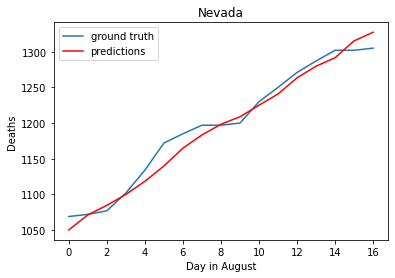

Date: 2020-09-01 00:00:00, predicted=1328.529104
Date: 2020-09-02 00:00:00, predicted=1346.697128
Date: 2020-09-03 00:00:00, predicted=1360.400415
Date: 2020-09-04 00:00:00, predicted=1379.658591
Date: 2020-09-05 00:00:00, predicted=1386.927594
Date: 2020-09-06 00:00:00, predicted=1387.737869
Date: 2020-09-07 00:00:00, predicted=1392.751686
Date: 2020-09-08 00:00:00, predicted=1401.794590
Date: 2020-09-09 00:00:00, predicted=1425.276039
Date: 2020-09-10 00:00:00, predicted=1441.793492
Date: 2020-09-11 00:00:00, predicted=1452.839973
Date: 2020-09-12 00:00:00, predicted=1453.714741
Date: 2020-09-13 00:00:00, predicted=1446.111513
Date: 2020-09-14 00:00:00, predicted=1451.391170
Date: 2020-09-15 00:00:00, predicted=1458.246216
Date: 2020-09-16 00:00:00, predicted=1474.640501
Date: 2020-09-17 00:00:00, predicted=1487.116345
Date: 2020-09-18 00:00:00, predicted=1497.261961
Date: 2020-09-19 00:00:00, predicted=1499.811481
Date: 2020-09-20 00:00:00, predicted=1487.500636
Date: 2020-09-21 00:

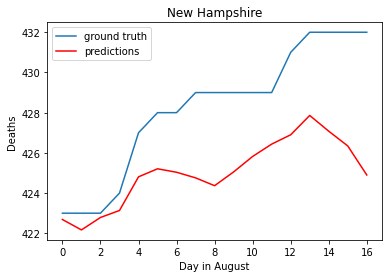

Date: 2020-09-01 00:00:00, predicted=431.077436
Date: 2020-09-02 00:00:00, predicted=431.549215
Date: 2020-09-03 00:00:00, predicted=431.688830
Date: 2020-09-04 00:00:00, predicted=432.588169
Date: 2020-09-05 00:00:00, predicted=432.201069
Date: 2020-09-06 00:00:00, predicted=431.846112
Date: 2020-09-07 00:00:00, predicted=431.644267
Date: 2020-09-08 00:00:00, predicted=432.363295
Date: 2020-09-09 00:00:00, predicted=432.642342
Date: 2020-09-10 00:00:00, predicted=431.473700
Date: 2020-09-11 00:00:00, predicted=432.374393
Date: 2020-09-12 00:00:00, predicted=432.488014
Date: 2020-09-13 00:00:00, predicted=433.072436
Date: 2020-09-14 00:00:00, predicted=432.608780
Date: 2020-09-15 00:00:00, predicted=432.488422
Date: 2020-09-16 00:00:00, predicted=433.001614
Date: 2020-09-17 00:00:00, predicted=433.472083
Date: 2020-09-18 00:00:00, predicted=433.252309
Date: 2020-09-19 00:00:00, predicted=433.483371
Date: 2020-09-20 00:00:00, predicted=433.152267
Date: 2020-09-21 00:00:00, predicted=432

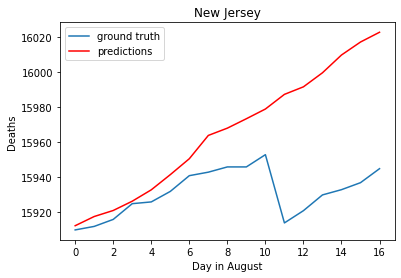

Date: 2020-09-01 00:00:00, predicted=15946.672229
Date: 2020-09-02 00:00:00, predicted=15947.085100
Date: 2020-09-03 00:00:00, predicted=15947.721773
Date: 2020-09-04 00:00:00, predicted=15949.347358
Date: 2020-09-05 00:00:00, predicted=15955.107186
Date: 2020-09-06 00:00:00, predicted=15960.179572
Date: 2020-09-07 00:00:00, predicted=15959.378507
Date: 2020-09-08 00:00:00, predicted=15960.602175
Date: 2020-09-09 00:00:00, predicted=15958.183188
Date: 2020-09-10 00:00:00, predicted=15958.845743
Date: 2020-09-11 00:00:00, predicted=15958.379227
Date: 2020-09-12 00:00:00, predicted=15963.906126
Date: 2020-09-13 00:00:00, predicted=15966.339636
Date: 2020-09-14 00:00:00, predicted=15968.852619
Date: 2020-09-15 00:00:00, predicted=15968.997387
Date: 2020-09-16 00:00:00, predicted=15968.722114
Date: 2020-09-17 00:00:00, predicted=15968.744720
Date: 2020-09-18 00:00:00, predicted=15970.637210
Date: 2020-09-19 00:00:00, predicted=15975.762104
Date: 2020-09-20 00:00:00, predicted=15978.294938


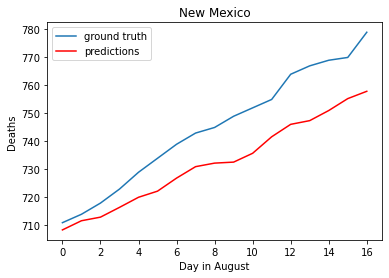

Date: 2020-09-01 00:00:00, predicted=782.785475
Date: 2020-09-02 00:00:00, predicted=785.893109
Date: 2020-09-03 00:00:00, predicted=790.099673
Date: 2020-09-04 00:00:00, predicted=795.747314
Date: 2020-09-05 00:00:00, predicted=798.899915
Date: 2020-09-06 00:00:00, predicted=804.430131
Date: 2020-09-07 00:00:00, predicted=808.127614
Date: 2020-09-08 00:00:00, predicted=812.500817
Date: 2020-09-09 00:00:00, predicted=816.862931
Date: 2020-09-10 00:00:00, predicted=821.443840
Date: 2020-09-11 00:00:00, predicted=826.529132
Date: 2020-09-12 00:00:00, predicted=829.773069
Date: 2020-09-13 00:00:00, predicted=834.294440
Date: 2020-09-14 00:00:00, predicted=838.604065
Date: 2020-09-15 00:00:00, predicted=840.709434
Date: 2020-09-16 00:00:00, predicted=847.178169
Date: 2020-09-17 00:00:00, predicted=850.743460
Date: 2020-09-18 00:00:00, predicted=854.499432
Date: 2020-09-19 00:00:00, predicted=858.334819
Date: 2020-09-20 00:00:00, predicted=863.000027
Date: 2020-09-21 00:00:00, predicted=868

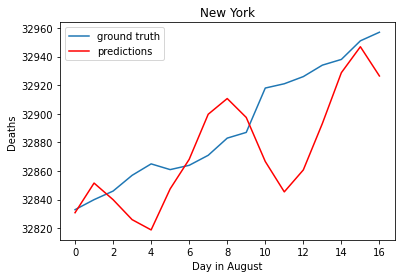

Date: 2020-09-01 00:00:00, predicted=32984.009860
Date: 2020-09-02 00:00:00, predicted=33001.053511
Date: 2020-09-03 00:00:00, predicted=33025.032134
Date: 2020-09-04 00:00:00, predicted=33037.223923
Date: 2020-09-05 00:00:00, predicted=33057.079081
Date: 2020-09-06 00:00:00, predicted=33053.991840
Date: 2020-09-07 00:00:00, predicted=33063.620943
Date: 2020-09-08 00:00:00, predicted=33088.333614
Date: 2020-09-09 00:00:00, predicted=33112.134074
Date: 2020-09-10 00:00:00, predicted=33134.443033
Date: 2020-09-11 00:00:00, predicted=33170.804707
Date: 2020-09-12 00:00:00, predicted=33198.664185
Date: 2020-09-13 00:00:00, predicted=33193.736519
Date: 2020-09-14 00:00:00, predicted=33209.534041
Date: 2020-09-15 00:00:00, predicted=33227.831247
Date: 2020-09-16 00:00:00, predicted=33244.483277
Date: 2020-09-17 00:00:00, predicted=33278.976782
Date: 2020-09-18 00:00:00, predicted=33320.569670
Date: 2020-09-19 00:00:00, predicted=33363.642716
Date: 2020-09-20 00:00:00, predicted=33368.160334


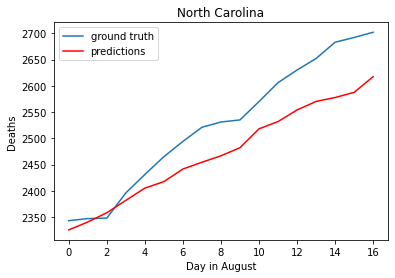

Date: 2020-09-01 00:00:00, predicted=2729.459376
Date: 2020-09-02 00:00:00, predicted=2748.872848
Date: 2020-09-03 00:00:00, predicted=2787.723051
Date: 2020-09-04 00:00:00, predicted=2807.814130
Date: 2020-09-05 00:00:00, predicted=2829.549563
Date: 2020-09-06 00:00:00, predicted=2834.948631
Date: 2020-09-07 00:00:00, predicted=2846.075120
Date: 2020-09-08 00:00:00, predicted=2868.309086
Date: 2020-09-09 00:00:00, predicted=2899.288317
Date: 2020-09-10 00:00:00, predicted=2923.344595
Date: 2020-09-11 00:00:00, predicted=2940.646556
Date: 2020-09-12 00:00:00, predicted=2972.314263
Date: 2020-09-13 00:00:00, predicted=2991.198691
Date: 2020-09-14 00:00:00, predicted=3003.924888
Date: 2020-09-15 00:00:00, predicted=3029.670314
Date: 2020-09-16 00:00:00, predicted=3057.649420
Date: 2020-09-17 00:00:00, predicted=3084.698317
Date: 2020-09-18 00:00:00, predicted=3113.407132
Date: 2020-09-19 00:00:00, predicted=3134.329859
Date: 2020-09-20 00:00:00, predicted=3149.165145
Date: 2020-09-21 00:

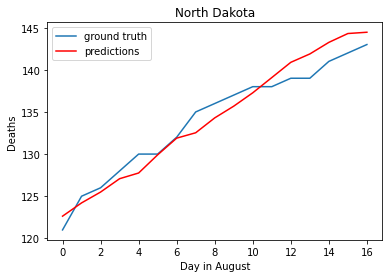

Date: 2020-09-01 00:00:00, predicted=144.713489
Date: 2020-09-02 00:00:00, predicted=145.609756
Date: 2020-09-03 00:00:00, predicted=147.659034
Date: 2020-09-04 00:00:00, predicted=148.466930
Date: 2020-09-05 00:00:00, predicted=149.338759
Date: 2020-09-06 00:00:00, predicted=150.495259
Date: 2020-09-07 00:00:00, predicted=151.228815
Date: 2020-09-08 00:00:00, predicted=152.689997
Date: 2020-09-09 00:00:00, predicted=154.104775
Date: 2020-09-10 00:00:00, predicted=154.570870
Date: 2020-09-11 00:00:00, predicted=155.671228
Date: 2020-09-12 00:00:00, predicted=156.922978
Date: 2020-09-13 00:00:00, predicted=157.740899
Date: 2020-09-14 00:00:00, predicted=157.672583
Date: 2020-09-15 00:00:00, predicted=160.280796
Date: 2020-09-16 00:00:00, predicted=162.053520
Date: 2020-09-17 00:00:00, predicted=162.190917
Date: 2020-09-18 00:00:00, predicted=162.181857
Date: 2020-09-19 00:00:00, predicted=163.351648
Date: 2020-09-20 00:00:00, predicted=164.345709
Date: 2020-09-21 00:00:00, predicted=166

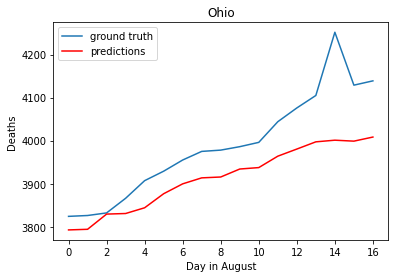

Date: 2020-09-01 00:00:00, predicted=4150.447868
Date: 2020-09-02 00:00:00, predicted=4184.005991
Date: 2020-09-03 00:00:00, predicted=4200.321698
Date: 2020-09-04 00:00:00, predicted=4252.378058
Date: 2020-09-05 00:00:00, predicted=4310.092571
Date: 2020-09-06 00:00:00, predicted=4302.371587
Date: 2020-09-07 00:00:00, predicted=4305.965910
Date: 2020-09-08 00:00:00, predicted=4314.989352
Date: 2020-09-09 00:00:00, predicted=4355.763772
Date: 2020-09-10 00:00:00, predicted=4347.883105
Date: 2020-09-11 00:00:00, predicted=4428.413850
Date: 2020-09-12 00:00:00, predicted=4458.395426
Date: 2020-09-13 00:00:00, predicted=4443.692374
Date: 2020-09-14 00:00:00, predicted=4463.505233
Date: 2020-09-15 00:00:00, predicted=4471.114885
Date: 2020-09-16 00:00:00, predicted=4496.904780
Date: 2020-09-17 00:00:00, predicted=4509.245512
Date: 2020-09-18 00:00:00, predicted=4555.356478
Date: 2020-09-19 00:00:00, predicted=4613.575935
Date: 2020-09-20 00:00:00, predicted=4613.009265
Date: 2020-09-21 00:

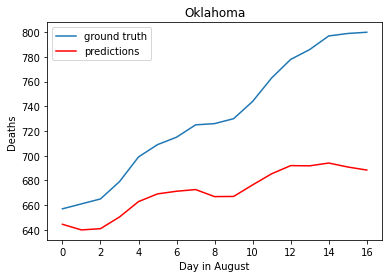

Date: 2020-09-01 00:00:00, predicted=814.679330
Date: 2020-09-02 00:00:00, predicted=834.643791
Date: 2020-09-03 00:00:00, predicted=848.753203
Date: 2020-09-04 00:00:00, predicted=859.165596
Date: 2020-09-05 00:00:00, predicted=869.301424
Date: 2020-09-06 00:00:00, predicted=870.628185
Date: 2020-09-07 00:00:00, predicted=876.120352
Date: 2020-09-08 00:00:00, predicted=889.200576
Date: 2020-09-09 00:00:00, predicted=907.462930
Date: 2020-09-10 00:00:00, predicted=919.113416
Date: 2020-09-11 00:00:00, predicted=928.213737
Date: 2020-09-12 00:00:00, predicted=937.767648
Date: 2020-09-13 00:00:00, predicted=943.223497
Date: 2020-09-14 00:00:00, predicted=946.998754
Date: 2020-09-15 00:00:00, predicted=960.087512
Date: 2020-09-16 00:00:00, predicted=978.418934
Date: 2020-09-17 00:00:00, predicted=991.856524
Date: 2020-09-18 00:00:00, predicted=1001.245156
Date: 2020-09-19 00:00:00, predicted=1010.707695
Date: 2020-09-20 00:00:00, predicted=1013.394888
Date: 2020-09-21 00:00:00, predicted=

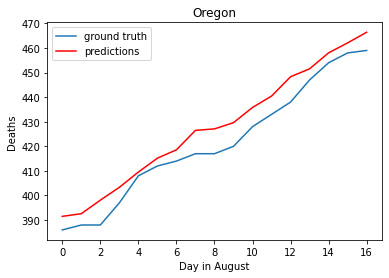

Date: 2020-09-01 00:00:00, predicted=468.492884
Date: 2020-09-02 00:00:00, predicted=477.740673
Date: 2020-09-03 00:00:00, predicted=481.757828
Date: 2020-09-04 00:00:00, predicted=485.505083
Date: 2020-09-05 00:00:00, predicted=486.484667
Date: 2020-09-06 00:00:00, predicted=490.130833
Date: 2020-09-07 00:00:00, predicted=490.516608
Date: 2020-09-08 00:00:00, predicted=499.066446
Date: 2020-09-09 00:00:00, predicted=509.531854
Date: 2020-09-10 00:00:00, predicted=514.739981
Date: 2020-09-11 00:00:00, predicted=519.559434
Date: 2020-09-12 00:00:00, predicted=526.616915
Date: 2020-09-13 00:00:00, predicted=530.237215
Date: 2020-09-14 00:00:00, predicted=533.960834
Date: 2020-09-15 00:00:00, predicted=540.378107
Date: 2020-09-16 00:00:00, predicted=546.773775
Date: 2020-09-17 00:00:00, predicted=553.433017
Date: 2020-09-18 00:00:00, predicted=558.829842
Date: 2020-09-19 00:00:00, predicted=562.714001
Date: 2020-09-20 00:00:00, predicted=567.049048
Date: 2020-09-21 00:00:00, predicted=567

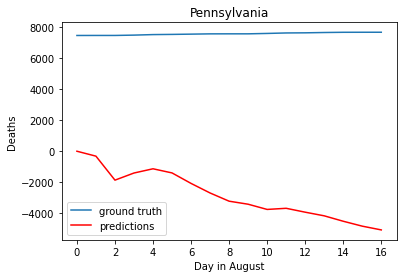

Date: 2020-09-01 00:00:00, predicted=-3751.491331
Date: 2020-09-02 00:00:00, predicted=-7701.769353
Date: 2020-09-03 00:00:00, predicted=-10522.811086
Date: 2020-09-04 00:00:00, predicted=-11572.633050
Date: 2020-09-05 00:00:00, predicted=-11912.755878
Date: 2020-09-06 00:00:00, predicted=-12572.635203
Date: 2020-09-07 00:00:00, predicted=-12628.456968
Date: 2020-09-08 00:00:00, predicted=-12592.038493
Date: 2020-09-09 00:00:00, predicted=-12971.168173
Date: 2020-09-10 00:00:00, predicted=-13494.875717
Date: 2020-09-11 00:00:00, predicted=-13782.192822
Date: 2020-09-12 00:00:00, predicted=-13872.012474
Date: 2020-09-13 00:00:00, predicted=-14050.194443
Date: 2020-09-14 00:00:00, predicted=-13973.626120
Date: 2020-09-15 00:00:00, predicted=-13957.981146
Date: 2020-09-16 00:00:00, predicted=-14103.341024
Date: 2020-09-17 00:00:00, predicted=-14409.779796
Date: 2020-09-18 00:00:00, predicted=-14672.435286
Date: 2020-09-19 00:00:00, predicted=-14609.928053
Date: 2020-09-20 00:00:00, predic

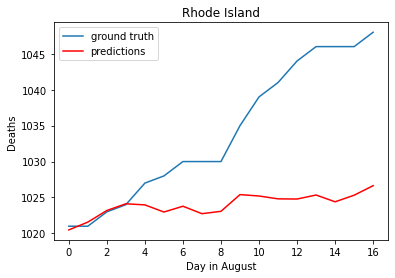

Date: 2020-09-01 00:00:00, predicted=1049.750058
Date: 2020-09-02 00:00:00, predicted=1051.218647
Date: 2020-09-03 00:00:00, predicted=1052.161819
Date: 2020-09-04 00:00:00, predicted=1053.421590
Date: 2020-09-05 00:00:00, predicted=1053.768829
Date: 2020-09-06 00:00:00, predicted=1055.456844
Date: 2020-09-07 00:00:00, predicted=1058.532392
Date: 2020-09-08 00:00:00, predicted=1060.230851
Date: 2020-09-09 00:00:00, predicted=1062.039239
Date: 2020-09-10 00:00:00, predicted=1064.239314
Date: 2020-09-11 00:00:00, predicted=1065.464601
Date: 2020-09-12 00:00:00, predicted=1066.053378
Date: 2020-09-13 00:00:00, predicted=1068.795745
Date: 2020-09-14 00:00:00, predicted=1072.271066
Date: 2020-09-15 00:00:00, predicted=1074.235447
Date: 2020-09-16 00:00:00, predicted=1075.718085
Date: 2020-09-17 00:00:00, predicted=1077.501484
Date: 2020-09-18 00:00:00, predicted=1078.679963
Date: 2020-09-19 00:00:00, predicted=1079.109428
Date: 2020-09-20 00:00:00, predicted=1081.834967
Date: 2020-09-21 00:

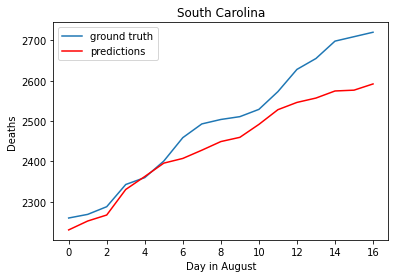

Date: 2020-09-01 00:00:00, predicted=2759.691678
Date: 2020-09-02 00:00:00, predicted=2798.176860
Date: 2020-09-03 00:00:00, predicted=2838.913351
Date: 2020-09-04 00:00:00, predicted=2891.999178
Date: 2020-09-05 00:00:00, predicted=2932.951625
Date: 2020-09-06 00:00:00, predicted=2937.139739
Date: 2020-09-07 00:00:00, predicted=2962.709059
Date: 2020-09-08 00:00:00, predicted=2996.599932
Date: 2020-09-09 00:00:00, predicted=3030.664973
Date: 2020-09-10 00:00:00, predicted=3077.866860
Date: 2020-09-11 00:00:00, predicted=3119.637513
Date: 2020-09-12 00:00:00, predicted=3153.027550
Date: 2020-09-13 00:00:00, predicted=3163.902948
Date: 2020-09-14 00:00:00, predicted=3193.638251
Date: 2020-09-15 00:00:00, predicted=3221.762437
Date: 2020-09-16 00:00:00, predicted=3256.781087
Date: 2020-09-17 00:00:00, predicted=3304.307143
Date: 2020-09-18 00:00:00, predicted=3337.637231
Date: 2020-09-19 00:00:00, predicted=3371.461589
Date: 2020-09-20 00:00:00, predicted=3385.428521
Date: 2020-09-21 00:

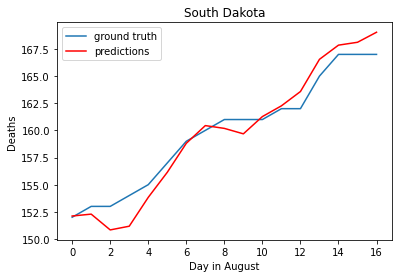

Date: 2020-09-01 00:00:00, predicted=167.024382
Date: 2020-09-02 00:00:00, predicted=168.239368
Date: 2020-09-03 00:00:00, predicted=170.409569
Date: 2020-09-04 00:00:00, predicted=171.818524
Date: 2020-09-05 00:00:00, predicted=173.715468
Date: 2020-09-06 00:00:00, predicted=174.829314
Date: 2020-09-07 00:00:00, predicted=176.175803
Date: 2020-09-08 00:00:00, predicted=176.899371
Date: 2020-09-09 00:00:00, predicted=177.234762
Date: 2020-09-10 00:00:00, predicted=178.869138
Date: 2020-09-11 00:00:00, predicted=181.921091
Date: 2020-09-12 00:00:00, predicted=183.120382
Date: 2020-09-13 00:00:00, predicted=184.242939
Date: 2020-09-14 00:00:00, predicted=184.707229
Date: 2020-09-15 00:00:00, predicted=185.096963
Date: 2020-09-16 00:00:00, predicted=186.475314
Date: 2020-09-17 00:00:00, predicted=188.634260
Date: 2020-09-18 00:00:00, predicted=190.435782
Date: 2020-09-19 00:00:00, predicted=192.427980
Date: 2020-09-20 00:00:00, predicted=193.337009
Date: 2020-09-21 00:00:00, predicted=193

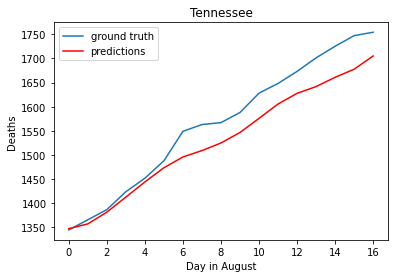

Date: 2020-09-01 00:00:00, predicted=1789.620742
Date: 2020-09-02 00:00:00, predicted=1827.034982
Date: 2020-09-03 00:00:00, predicted=1868.954428
Date: 2020-09-04 00:00:00, predicted=1911.702271
Date: 2020-09-05 00:00:00, predicted=1923.260017
Date: 2020-09-06 00:00:00, predicted=1940.377248
Date: 2020-09-07 00:00:00, predicted=1957.842266
Date: 2020-09-08 00:00:00, predicted=1988.115941
Date: 2020-09-09 00:00:00, predicted=2018.806145
Date: 2020-09-10 00:00:00, predicted=2039.997700
Date: 2020-09-11 00:00:00, predicted=2070.807232
Date: 2020-09-12 00:00:00, predicted=2088.102762
Date: 2020-09-13 00:00:00, predicted=2108.046524
Date: 2020-09-14 00:00:00, predicted=2132.162111
Date: 2020-09-15 00:00:00, predicted=2165.364600
Date: 2020-09-16 00:00:00, predicted=2204.484877
Date: 2020-09-17 00:00:00, predicted=2246.279148
Date: 2020-09-18 00:00:00, predicted=2291.744089
Date: 2020-09-19 00:00:00, predicted=2316.427874
Date: 2020-09-20 00:00:00, predicted=2334.035818
Date: 2020-09-21 00:

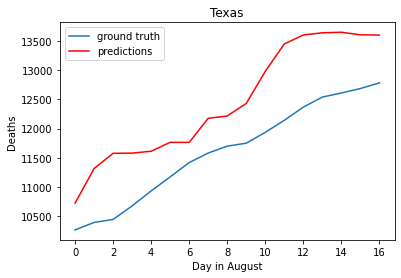

Date: 2020-09-01 00:00:00, predicted=12885.765235
Date: 2020-09-02 00:00:00, predicted=13113.522639
Date: 2020-09-03 00:00:00, predicted=13474.079229
Date: 2020-09-04 00:00:00, predicted=13783.861678
Date: 2020-09-05 00:00:00, predicted=13836.606996
Date: 2020-09-06 00:00:00, predicted=13880.761318
Date: 2020-09-07 00:00:00, predicted=13694.137690
Date: 2020-09-08 00:00:00, predicted=13771.666497
Date: 2020-09-09 00:00:00, predicted=13841.574666
Date: 2020-09-10 00:00:00, predicted=14020.165046
Date: 2020-09-11 00:00:00, predicted=14170.765731
Date: 2020-09-12 00:00:00, predicted=14338.807862
Date: 2020-09-13 00:00:00, predicted=14393.893242
Date: 2020-09-14 00:00:00, predicted=14421.898191
Date: 2020-09-15 00:00:00, predicted=14536.301348
Date: 2020-09-16 00:00:00, predicted=14708.797352
Date: 2020-09-17 00:00:00, predicted=14875.098187
Date: 2020-09-18 00:00:00, predicted=15017.808780
Date: 2020-09-19 00:00:00, predicted=15098.963717
Date: 2020-09-20 00:00:00, predicted=15130.947429


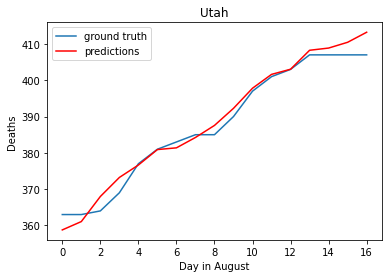

Date: 2020-09-01 00:00:00, predicted=412.013957
Date: 2020-09-02 00:00:00, predicted=416.727681
Date: 2020-09-03 00:00:00, predicted=421.637353
Date: 2020-09-04 00:00:00, predicted=419.676322
Date: 2020-09-05 00:00:00, predicted=421.815609
Date: 2020-09-06 00:00:00, predicted=424.050628
Date: 2020-09-07 00:00:00, predicted=424.646027
Date: 2020-09-08 00:00:00, predicted=428.681000
Date: 2020-09-09 00:00:00, predicted=430.829820
Date: 2020-09-10 00:00:00, predicted=435.359562
Date: 2020-09-11 00:00:00, predicted=439.934350
Date: 2020-09-12 00:00:00, predicted=440.362121
Date: 2020-09-13 00:00:00, predicted=439.328675
Date: 2020-09-14 00:00:00, predicted=441.974317
Date: 2020-09-15 00:00:00, predicted=447.704946
Date: 2020-09-16 00:00:00, predicted=451.259239
Date: 2020-09-17 00:00:00, predicted=454.292302
Date: 2020-09-18 00:00:00, predicted=455.522354
Date: 2020-09-19 00:00:00, predicted=455.588632
Date: 2020-09-20 00:00:00, predicted=457.934304
Date: 2020-09-21 00:00:00, predicted=461

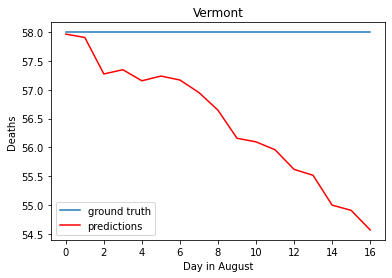

Date: 2020-09-01 00:00:00, predicted=58.128668
Date: 2020-09-02 00:00:00, predicted=58.016106
Date: 2020-09-03 00:00:00, predicted=57.782235
Date: 2020-09-04 00:00:00, predicted=57.679581
Date: 2020-09-05 00:00:00, predicted=57.739713
Date: 2020-09-06 00:00:00, predicted=57.868638
Date: 2020-09-07 00:00:00, predicted=57.741825
Date: 2020-09-08 00:00:00, predicted=57.790520
Date: 2020-09-09 00:00:00, predicted=57.665985
Date: 2020-09-10 00:00:00, predicted=57.642362
Date: 2020-09-11 00:00:00, predicted=57.400587
Date: 2020-09-12 00:00:00, predicted=57.458244
Date: 2020-09-13 00:00:00, predicted=57.444327
Date: 2020-09-14 00:00:00, predicted=57.322645
Date: 2020-09-15 00:00:00, predicted=57.289812
Date: 2020-09-16 00:00:00, predicted=57.212696
Date: 2020-09-17 00:00:00, predicted=57.352462
Date: 2020-09-18 00:00:00, predicted=57.190900
Date: 2020-09-19 00:00:00, predicted=57.092015
Date: 2020-09-20 00:00:00, predicted=57.063973
Date: 2020-09-21 00:00:00, predicted=57.019484
Date: 2020-09

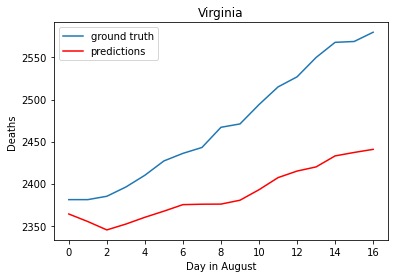

Date: 2020-09-01 00:00:00, predicted=2598.654626
Date: 2020-09-02 00:00:00, predicted=2622.074512
Date: 2020-09-03 00:00:00, predicted=2639.704268
Date: 2020-09-04 00:00:00, predicted=2656.577823
Date: 2020-09-05 00:00:00, predicted=2677.575590
Date: 2020-09-06 00:00:00, predicted=2685.132186
Date: 2020-09-07 00:00:00, predicted=2687.598720
Date: 2020-09-08 00:00:00, predicted=2702.603469
Date: 2020-09-09 00:00:00, predicted=2725.470796
Date: 2020-09-10 00:00:00, predicted=2740.385737
Date: 2020-09-11 00:00:00, predicted=2747.558308
Date: 2020-09-12 00:00:00, predicted=2761.108410
Date: 2020-09-13 00:00:00, predicted=2764.902679
Date: 2020-09-14 00:00:00, predicted=2767.932046
Date: 2020-09-15 00:00:00, predicted=2778.077946
Date: 2020-09-16 00:00:00, predicted=2793.541223
Date: 2020-09-17 00:00:00, predicted=2810.356406
Date: 2020-09-18 00:00:00, predicted=2821.264797
Date: 2020-09-19 00:00:00, predicted=2832.307078
Date: 2020-09-20 00:00:00, predicted=2838.469857
Date: 2020-09-21 00:

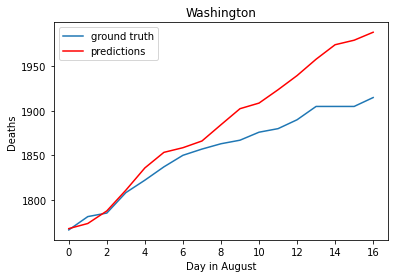

Date: 2020-09-01 00:00:00, predicted=1924.008346
Date: 2020-09-02 00:00:00, predicted=1926.350765
Date: 2020-09-03 00:00:00, predicted=1942.618565
Date: 2020-09-04 00:00:00, predicted=1946.010858
Date: 2020-09-05 00:00:00, predicted=1950.977234
Date: 2020-09-06 00:00:00, predicted=1953.395406
Date: 2020-09-07 00:00:00, predicted=1961.209903
Date: 2020-09-08 00:00:00, predicted=1974.657736
Date: 2020-09-09 00:00:00, predicted=1975.624249
Date: 2020-09-10 00:00:00, predicted=1984.657814
Date: 2020-09-11 00:00:00, predicted=1984.631254
Date: 2020-09-12 00:00:00, predicted=1990.297647
Date: 2020-09-13 00:00:00, predicted=1989.266357
Date: 2020-09-14 00:00:00, predicted=1992.548916
Date: 2020-09-15 00:00:00, predicted=1999.655079
Date: 2020-09-16 00:00:00, predicted=2001.053061
Date: 2020-09-17 00:00:00, predicted=2014.871681
Date: 2020-09-18 00:00:00, predicted=2025.521665
Date: 2020-09-19 00:00:00, predicted=2027.576000
Date: 2020-09-20 00:00:00, predicted=2031.711978
Date: 2020-09-21 00:

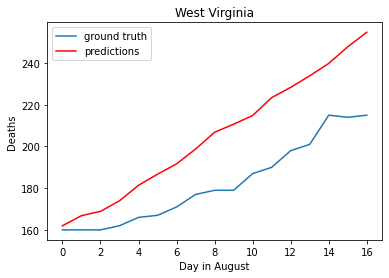

Date: 2020-09-01 00:00:00, predicted=218.362362
Date: 2020-09-02 00:00:00, predicted=224.025510
Date: 2020-09-03 00:00:00, predicted=225.771284
Date: 2020-09-04 00:00:00, predicted=226.104025
Date: 2020-09-05 00:00:00, predicted=230.896978
Date: 2020-09-06 00:00:00, predicted=234.786502
Date: 2020-09-07 00:00:00, predicted=234.267574
Date: 2020-09-08 00:00:00, predicted=241.837051
Date: 2020-09-09 00:00:00, predicted=247.530008
Date: 2020-09-10 00:00:00, predicted=251.922886
Date: 2020-09-11 00:00:00, predicted=251.446677
Date: 2020-09-12 00:00:00, predicted=259.247146
Date: 2020-09-13 00:00:00, predicted=264.017650
Date: 2020-09-14 00:00:00, predicted=265.650936
Date: 2020-09-15 00:00:00, predicted=270.455597
Date: 2020-09-16 00:00:00, predicted=277.315157
Date: 2020-09-17 00:00:00, predicted=278.194976
Date: 2020-09-18 00:00:00, predicted=281.079065
Date: 2020-09-19 00:00:00, predicted=287.281389
Date: 2020-09-20 00:00:00, predicted=291.709713
Date: 2020-09-21 00:00:00, predicted=293

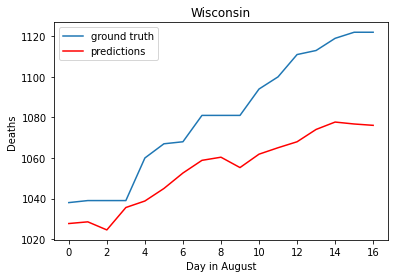

Date: 2020-09-01 00:00:00, predicted=1134.836154
Date: 2020-09-02 00:00:00, predicted=1141.652703
Date: 2020-09-03 00:00:00, predicted=1147.093841
Date: 2020-09-04 00:00:00, predicted=1154.116309
Date: 2020-09-05 00:00:00, predicted=1158.441290
Date: 2020-09-06 00:00:00, predicted=1163.009446
Date: 2020-09-07 00:00:00, predicted=1165.675467
Date: 2020-09-08 00:00:00, predicted=1168.177325
Date: 2020-09-09 00:00:00, predicted=1180.694419
Date: 2020-09-10 00:00:00, predicted=1187.210326
Date: 2020-09-11 00:00:00, predicted=1188.699616
Date: 2020-09-12 00:00:00, predicted=1196.765584
Date: 2020-09-13 00:00:00, predicted=1203.212147
Date: 2020-09-14 00:00:00, predicted=1206.915288
Date: 2020-09-15 00:00:00, predicted=1214.192444
Date: 2020-09-16 00:00:00, predicted=1224.419994
Date: 2020-09-17 00:00:00, predicted=1231.961711
Date: 2020-09-18 00:00:00, predicted=1233.458601
Date: 2020-09-19 00:00:00, predicted=1244.844777
Date: 2020-09-20 00:00:00, predicted=1250.916334
Date: 2020-09-21 00:

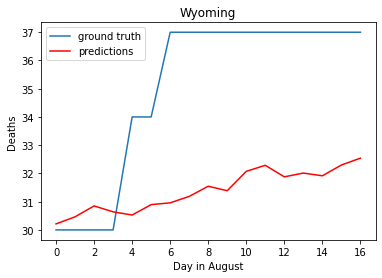

Date: 2020-09-01 00:00:00, predicted=36.615959
Date: 2020-09-02 00:00:00, predicted=37.608817
Date: 2020-09-03 00:00:00, predicted=36.880115
Date: 2020-09-04 00:00:00, predicted=37.255603
Date: 2020-09-05 00:00:00, predicted=37.319900
Date: 2020-09-06 00:00:00, predicted=37.657747
Date: 2020-09-07 00:00:00, predicted=37.335353
Date: 2020-09-08 00:00:00, predicted=37.752651
Date: 2020-09-09 00:00:00, predicted=37.390080
Date: 2020-09-10 00:00:00, predicted=37.542203
Date: 2020-09-11 00:00:00, predicted=38.262841
Date: 2020-09-12 00:00:00, predicted=38.492380
Date: 2020-09-13 00:00:00, predicted=38.803044
Date: 2020-09-14 00:00:00, predicted=39.529862
Date: 2020-09-15 00:00:00, predicted=39.585419
Date: 2020-09-16 00:00:00, predicted=40.860093
Date: 2020-09-17 00:00:00, predicted=41.427923
Date: 2020-09-18 00:00:00, predicted=41.595527
Date: 2020-09-19 00:00:00, predicted=41.904520
Date: 2020-09-20 00:00:00, predicted=41.958748
Date: 2020-09-21 00:00:00, predicted=41.827588
Date: 2020-09

In [29]:
cumulative_MAPE = 0
deaths_output_df = pd.DataFrame()

for state in state_names:
    results, err = evaluate_ARIMA_model(deaths_train, deaths_test, state)
    cumulative_MAPE += err
    deaths_output_df = deaths_output_df.append(results)
    
overall_average_MAPE = cumulative_MAPE/50

In [34]:
# Adjust MAPE for troublesome values (Pennsylvania)
# Reason for negative predictions likely a result of bit overflow or something with the distributions
overall_average_MAPE = ((overall_average_MAPE*50)-126.703)/49

print("Average MAPE for Deaths: {}%".format(overall_average_MAPE))
f = open("ARIMA_Deaths_MAPE.txt", "w")
f.write(str(overall_average_MAPE))
f.close()

# Actual Effective MAPE = 2.5367

Average MAPE for Deaths: -2.3250065301897984%


Running ARIMA for Pennsylvania
Date: 2020-08-15 00:00:00, predicted=7443.172399, expected=7451.000000
Date: 2020-08-16 00:00:00, predicted=7452.975155, expected=7453.000000
Date: 2020-08-17 00:00:00, predicted=7463.019451, expected=7453.000000
Date: 2020-08-18 00:00:00, predicted=7491.456968, expected=7474.000000
Date: 2020-08-19 00:00:00, predicted=7504.893584, expected=7508.000000
Date: 2020-08-20 00:00:00, predicted=7536.856475, expected=7520.000000
Date: 2020-08-21 00:00:00, predicted=7560.299967, expected=7537.000000
Date: 2020-08-22 00:00:00, predicted=7584.903476, expected=7555.000000
Date: 2020-08-23 00:00:00, predicted=7580.546474, expected=7557.000000
Date: 2020-08-24 00:00:00, predicted=7591.593374, expected=7557.000000
Date: 2020-08-25 00:00:00, predicted=7613.516314, expected=7582.000000
Date: 2020-08-26 00:00:00, predicted=7631.922064, expected=7613.000000
Date: 2020-08-27 00:00:00, predicted=7665.605211, expected=7622.000000
Date: 2020-08-28 00:00:00, predicted=7696.0225

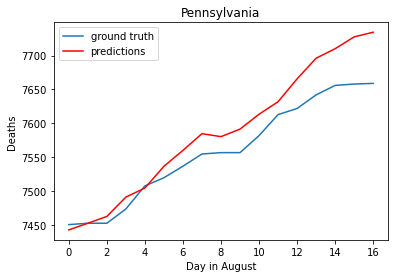

Date: 2020-09-01 00:00:00, predicted=7697.833477
Date: 2020-09-02 00:00:00, predicted=7712.854914
Date: 2020-09-03 00:00:00, predicted=7715.774413
Date: 2020-09-04 00:00:00, predicted=7732.111305
Date: 2020-09-05 00:00:00, predicted=7734.167598
Date: 2020-09-06 00:00:00, predicted=7731.452823
Date: 2020-09-07 00:00:00, predicted=7729.686018
Date: 2020-09-08 00:00:00, predicted=7750.808195
Date: 2020-09-09 00:00:00, predicted=7780.969154
Date: 2020-09-10 00:00:00, predicted=7787.158340
Date: 2020-09-11 00:00:00, predicted=7804.898297
Date: 2020-09-12 00:00:00, predicted=7807.684579
Date: 2020-09-13 00:00:00, predicted=7797.906508
Date: 2020-09-14 00:00:00, predicted=7803.498588
Date: 2020-09-15 00:00:00, predicted=7830.099929
Date: 2020-09-16 00:00:00, predicted=7854.084712
Date: 2020-09-17 00:00:00, predicted=7867.663828
Date: 2020-09-18 00:00:00, predicted=7873.874522
Date: 2020-09-19 00:00:00, predicted=7876.534101
Date: 2020-09-20 00:00:00, predicted=7865.200153
Date: 2020-09-21 00:

In [42]:
temp = deaths_output_df[deaths_output_df.Province_State != 'Pennsylvania']

# Need to redo Pennsylvania because model predictions often become negative with high PR value
results, _ = evaluate_ARIMA_model(deaths_train, deaths_test, 'Pennsylvania', (35,1,0))
temp = temp.append(results)

In [43]:
deaths_output_df = temp
deaths_output_df = deaths_output_df.sort_values(by=['Date', 'Province_State'])
deaths_output_df.to_csv('ARIMA_Deaths_Predictions.csv', index=False)

# Create Required Submission

In [54]:
test_df = pd.read_csv('test.csv')
test_df.head()

ForecastID Province_State        Date  Confirmed  Deaths
0           0        Alabama  09-01-2020         -1      -1
1           1         Alaska  09-01-2020         -1      -1
2           2        Arizona  09-01-2020         -1      -1
3           3       Arkansas  09-01-2020         -1      -1
4           4     California  09-01-2020         -1      -1

In [55]:
confirmed_predictions = pd.read_csv('ARIMA_Confirmed_Predictions.csv')
confirmed_predictions.head()

Province_State        Date      Confirmed
0        Alabama  2020-09-01  127413.853159
1         Alaska  2020-09-01    5321.012704
2        Arizona  2020-09-01  202304.483038
3       Arkansas  2020-09-01   61895.320446
4     California  2020-09-01  716226.452507

In [56]:
deaths_predictions = pd.read_csv('ARIMA_Deaths_Predictions.csv')
deaths_predictions.head()

Province_State        Date        Deaths
0        Alabama  2020-09-01   2194.110899
1         Alaska  2020-09-01     37.819526
2        Arizona  2020-09-01   5050.169255
3       Arkansas  2020-09-01    811.007998
4     California  2020-09-01  13121.019514

In [57]:
test_df['Confirmed'] = confirmed_predictions['Confirmed']
test_df['Deaths'] = deaths_predictions['Deaths']

In [58]:
test_df[test_df.Province_State == 'Pennsylvania']

ForecastID Province_State        Date      Confirmed       Deaths
37            37   Pennsylvania  09-01-2020  139476.171006  7697.833477
87            87   Pennsylvania  09-02-2020  140001.426283  7712.854914
137          137   Pennsylvania  09-03-2020  140652.236812  7715.774413
187          187   Pennsylvania  09-04-2020  141387.245862  7732.111305
237          237   Pennsylvania  09-05-2020  142020.444478  7734.167598
287          287   Pennsylvania  09-06-2020  142521.208100  7731.452823
337          337   Pennsylvania  09-07-2020  143116.773830  7729.686018
387          387   Pennsylvania  09-08-2020  143680.108176  7750.808195
437          437   Pennsylvania  09-09-2020  144196.342546  7780.969154
487          487   Pennsylvania  09-10-2020  144709.893722  7787.158340
537          537   Pennsylvania  09-11-2020  145371.322437  7804.898297
587          587   Pennsylvania  09-12-2020  145921.098154  7807.684579
637          637   Pennsylvania  09-13-2020  146457.363787  7797.906508
687          687   Pennsylvania  09-14-2020  147133.624713  7803.498588
737          737   Pennsylvania  09-15-2020  147723.237134  7830.099929
787          787   Pennsylvania  09-16-2020  148337.586100  7854.084712
837          837   Pennsylvania  09-17-2020  148961.622507  7867.663828
887          887   Pennsylvania  09-18-2020  149610.279621  7873.874522
937          937   Pennsylvania  09-19-2020  150226.286152  7876.534101
987          987   Pennsylvania  09-20-2020  150735.753894  7865.200153
1037        1037   Pennsylvania  09-21-2020  151304.372210  7850.516138
1087        1087   Pennsylvania  09-22-2020  151857.447948  7870.054720
1137        1137   Pennsylvania  09-23-2020  152458.664191  7888.805323
1187        1187   Pennsylvania  09-24-2020  153026.029003  7895.726376
1237        1237   Pennsylvania  09-25-2020  153645.142747  7908.951632
1287        1287   Pennsylvania  09-26-2020  154222.121013  7908.185641

In [52]:
test_df.drop(['Province_State','Date'], inplace=True, axis=1)
test_df.head()

ForecastID      Confirmed        Deaths
0           0  127413.853159   2194.110899
1           1    5321.012704     37.819526
2           2  202304.483038   5050.169255
3           3   61895.320446    811.007998
4           4  716226.452507  13121.019514

In [53]:
test_df.to_csv('ARIMA_submission.csv', index=False)